<div class="alert alert-block alert-info">
<h1> Analyse Agilent peak table + one hot encoded metadata</h1>
</div>

- [0 - Import modules](#0---Import-modules)
- [0 - Import data](#0---Import-data)
- [1 - Preprocess data](#1---Preprocess-data)
  - [a - Split peak table between metadata and peak intensities](#a---Split-peak-table-between-metadata-and-peak-intensities)
  - [b - Drop metadata columns with more than N% of missing values over the samples](#b---Drop-metadata-columns-with-more-than-N%-of-missing-values-over-the-samples)
  - [c - Keep only quantitative metadata and remove Blanks rows](#c---Keep-only-quantitative-metadata-and-remove-Blanks-rows)
  - [d - Check missing values in intensities](#d---Check-missing-values-in-intensities)
- [2 - Impute missing values](#2---Impute-missing-values)
  - [a - Impute intensities with 1's](#a---Impute-intensities-with-1's)
  - [b - Convert all intensities columns to integers](#b---Convert-all-intensities-columns-to-integers)
  - [c - Impute quantitative metadata with half min value of column](#c---Impute-quantitative-metadata-with-half-min-value-of-column)
- [3 - Concat preprocessed metadata (*metadata2_no_Blanks_quanti_imp_halfmin*) and preprocessed intensities (*intensities_imp1*)](#3---Concat-preprocessed-metadata-(*metadata2_no_Blanks_quanti_imp_halfmin*)-and-preprocessed-intensities-(*intensities_imp1*))
- [4 - Standard scale imputed peak table (metadata + intensities)](#4---Standard-scale-imputed-peak-table-(metadata-+-intensities))
- [5 - Dimensionality reduction](#5---Dimensionality-reduction)
  - [a - PCA then t-SNE](#a---PCA-then-t-SNE)
- [6 - Clustering](#6---Clustering)
  - [a - Kmeans](#a---Kmeans)
  - [b - Affinity propagation](#b---Affinity-propagation)
  - [c - Hierarchical clustering](#c---Hierarchical-clustering)

# 0 - Import modules

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import re
pwd = ! pwd
pwd = re.sub('notebooks/analyse_Agilent', '', pwd[0])
print(f'Working directory : {pwd}')

Working directory : /home/jovyan/work/


In [3]:
# Tune the visual settings for figures in seaborn
sns.set_context(
    "notebook", font_scale=1.2, rc={"figure.figsize": (15,10), "axes.titlesize": 15}
)

from matplotlib import rcParams

rcParams["figure.figsize"] = 15, 10

sns.set_theme(style="darkgrid")

In [4]:
import sys
sys.path.append(pwd + 'bin/')

# 0 - Import data

In [5]:
peakTable_Agilent = pd.read_csv(pwd + 'data/prepare_HCC_data/usable_peakTables/finally_processed_data/metadata_OneHotEncoded-peakTable-Agilent-186_samples.csv',
                                sep=',', decimal='.', na_values='NA')
print(peakTable_Agilent.shape)
peakTable_Agilent.head()

(186, 3594)


Idepic_Bio     Idepic_Samp    SampleID  \
0  41____41041872   41041872-s2#C1  LivCan_153   
1  41____41046868   41046868-s2#C1  LivCan_154   
2  41____41074588   41074588-s1#B1  LivCan_267   
3  41____41089214   41089214-s1#B1  LivCan_268   
4  21____21103888   21103888-s1#B1  LivCan_299   

                                      SampleID_full         Id_Bma  \
0  EPIC_Liver_Cancer_NR160614_007_41-LivCan_153_007  41-LivCan_153   
1  EPIC_Liver_Cancer_NR160614_008_41-LivCan_154_008  41-LivCan_154   
2  EPIC_Liver_Cancer_NR160614_009_41-LivCan_267_009  41-LivCan_267   
3  EPIC_Liver_Cancer_NR160614_010_41-LivCan_268_010  41-LivCan_268   
4  EPIC_Liver_Cancer_NR160614_014_21-LivCan_299_014  21-LivCan_299   

      Id Aliquot  CaseCtrl  ID_split_HCC          Idepic  Age_Blood  ...  \
0  41041872-s2#C  Incident    41041872.0  41____41041872     72.994  ...   
1  41046868-s2#C  Non-case    41046868.0  41____41046868     72.966  ...   
2  41074588-s1#B  Incident    41074588.0  41____41074588     53.977  ...   
3  41089214-s1#B  Non-case    41089214.0  41____41089214     53.544  ...   
4  21103888-s1#B  Incident    21103888.0  21____21103888     64.559  ...   

   225.1218@0.86389714  398.7578@8.768545  288.1272@6.883725  \
0                  NaN            98959.0            20987.0   
1               2414.0            93145.0            28323.0   
2                  NaN            93997.0            16393.0   
3               1378.0            93555.0                NaN   
4                  NaN            96460.0                NaN   

   126.0287@1.5353005  429.2873@6.211831  419.2505@8.916426  \
0            178906.0                NaN           184072.0   
1                 NaN                NaN                NaN   
2            171962.0                NaN           125149.0   
3                 NaN             4293.0           140514.0   
4            158917.0             9750.0           154104.0   

   518.2205@6.2066946  400.2586@7.130359  103.0998@7.112515  267.142@6.969883  
0              2547.0             6454.0                NaN          149023.0  
1              1043.0             6390.0           403011.0          164386.0  
2                 NaN             9443.0                NaN           99967.0  
3              4280.0             5900.0           399109.0          164202.0  
4             12004.0                NaN           264003.0          105903.0  

[5 rows x 3594 columns]

# 1 - Preprocess data

In [6]:
from explore_data_functions import *

## a - Split peak table between metadata and peak intensities

### Last metadata column is *Wcrf_Pf_Cal* (as we created the file in the notebook *08-keep_relevant_metadata.ipynb*)

In [7]:
metadata = peakTable_Agilent.loc[:, :'onehotencoder__Gallst_Yes']
metadata

Idepic_Bio     Idepic_Samp    SampleID  \
0    41____41041872   41041872-s2#C1  LivCan_153   
1    41____41046868   41046868-s2#C1  LivCan_154   
2    41____41074588   41074588-s1#B1  LivCan_267   
3    41____41089214   41089214-s1#B1  LivCan_268   
4    21____21103888   21103888-s1#B1  LivCan_299   
..               ...             ...         ...   
181  32____32253231   32253231-s3#C1  LivCan_080   
182  22____22281416   22281416-s1#B1  LivCan_375   
183  22____22281701   22281701-s1#B1  LivCan_376   
184  71____71000065   71000065-s2#C1  LivCan_165   
185  71____71000216   71000216-s2#C1  LivCan_166   

                                        SampleID_full                 Id_Bma  \
0    EPIC_Liver_Cancer_NR160614_007_41-LivCan_153_007          41-LivCan_153   
1    EPIC_Liver_Cancer_NR160614_008_41-LivCan_154_008          41-LivCan_154   
2    EPIC_Liver_Cancer_NR160614_009_41-LivCan_267_009          41-LivCan_267   
3    EPIC_Liver_Cancer_NR160614_010_41-LivCan_268_010          41-LivCan_268   
4    EPIC_Liver_Cancer_NR160614_014_21-LivCan_299_014          21-LivCan_299   
..                                                ...                    ...   
181  EPIC_Liver_Cancer_NR160614_275_32-LivCan_080_275  275_32-LivCan_080_275   
182  EPIC_Liver_Cancer_NR160614_281_22-LivCan_375_281  281_22-LivCan_375_281   
183  EPIC_Liver_Cancer_NR160614_282_22-LivCan_376_282  282_22-LivCan_376_282   
184  EPIC_Liver_Cancer_NR160614_283_71-LivCan_165_283  283_71-LivCan_165_283   
185  EPIC_Liver_Cancer_NR160614_284_71-LivCan_166_284  284_71-LivCan_166_284   

        Id Aliquot  CaseCtrl  ID_split_HCC          Idepic  Age_Blood  ...  \
0    41041872-s2#C  Incident    41041872.0  41____41041872     72.994  ...   
1    41046868-s2#C  Non-case    41046868.0  41____41046868     72.966  ...   
2    41074588-s1#B  Incident    41074588.0  41____41074588     53.977  ...   
3    41089214-s1#B  Non-case    41089214.0  41____41089214     53.544  ...   
4    21103888-s1#B  Incident    21103888.0  21____21103888     64.559  ...   
..             ...       ...           ...             ...        ...  ...   
181  32253231-s3#C  Non-case    32253231.0  32____3208004E     66.445  ...   
182  22281416-s1#B  Incident    22281416.0  22____22281416     71.619  ...   
183  22281701-s1#B  Non-case    22281701.0  22____22281701     71.543  ...   
184  71000065-s2#C  Incident    71000065.0  71____71000825     51.340  ...   
185  71000216-s2#C  Non-case    71000216.0  71____71001996     50.932  ...   

     onehotencoder__Lab_25OH_VitD2_<1.56  \
0                                    1.0   
1                                    1.0   
2                                    1.0   
3                                    1.0   
4                                    1.0   
..                                   ...   
181                                  1.0   
182                                  1.0   
183                                  1.0   
184                                  1.0   
185                                  1.0   

     onehotencoder__Lab_25OH_VitD2_Unknown  onehotencoder__Hyperl_Do not k  \
0                                      0.0                             0.0   
1                                      0.0                             0.0   
2                                      0.0                             0.0   
3                                      0.0                             0.0   
4                                      0.0                             0.0   
..                                     ...                             ...   
181                                    0.0                             0.0   
182                                    0.0                             0.0   
183                                    0.0                             0.0   
184                                    0.0                             0.0   
185                                    0.0                             0.0   

     onehotencoder__H

In [8]:
intensities = peakTable_Agilent.drop(metadata.columns, axis=1)
intensities

89.9697@0.5505152  90.973@0.55399996  939.813@0.56963736  \
0              4195138              40495             42242.0   
1              4306680              38555             49922.0   
2              4457872              41892             49890.0   
3              4128863              39711             33517.0   
4              4438077              43225             62259.0   
..                 ...                ...                 ...   
181            4416705              40954             47502.0   
182            4727455              44619             65454.0   
183            4643850              44234             62270.0   
184            4107050              38737             27127.0   
185            4671588              42617             66228.0   

     157.9574@0.5643974  871.8258@0.5736113  803.8387@0.5745634  \
0               2794282             50841.0             60628.0   
1               2930790             61613.0             73916.0   
2               2974132             61331.0             73473.0   
3               2769811             40177.0             46566.0   
4               2976035             74326.0             93735.0   
..                  ...                 ...                 ...   
181             3017039             56174.0             69562.0   
182             3237331             80203.0             99917.0   
183             3170819             75882.0             94129.0   
184             2681910             30093.0             39345.0   
185             3178603             80117.0            101130.0   

     973.8083@0.56959826  599.8754@0.5742488  811.8258@0.57766384  \
0                74517.0            100523.0              64318.0   
1                84277.0            120525.0              69334.0   
2                86310.0            116998.0              69140.0   
3                60449.0             80091.0              62495.0   
4               102111.0            138763.0              59839.0   
..                   ...                 ...                  ...   
181              81828.0             93578.0              64371.0   
182             114212.0            127797.0              59777.0   
183             104118.0            120689.0              60576.0   
184              52179.0             57230.0              56211.0   
185             113785.0            129753.0              59497.0   

     667.8631@0.57489955  ...  225.1218@0.86389714  398.7578@8.768545  \
0               108194.0  ...                  NaN            98959.0   
1               133694.0  ...               2414.0            93145.0   
2               132044.0  ...                  NaN            93997.0   
3                87292.0  ...               1378.0            93555.0   
4               163759.0  ...                  NaN            96460.0   
..                   ...  ...                  ...                ...   
181             122940.0  ...                  NaN            97137.0   
182             169132.0  ...               4823.0                NaN   
183             159518.0  ...               4761.0                NaN   
184              67452.0  ...              38674.0            89525.0   
185             173083.0  ...              12552.0            77676.0   

     288.1272@6.883725  126.0287@1.5353005  429.2873@6.211831  \
0              20987.0            178906.0                NaN   
1              28323.0                 NaN                NaN   
2              16393.0            171962.0                NaN   
3                  NaN                 NaN             4293.0   
4                  NaN            158917.0             9750.0   
..                 ...                 ...                ...   
181            24680.0             96880.0             1965.0   
182            17378.0             93893.0             9988.0   
183            16624.0            108831.0             3127.0   
184            11619.0            105422.0             3152.0  

In [9]:
intensitiesata_index = metadata.loc[:, :'Idepic']
metadata = metadata.drop(metadata_index.columns, axis=1)
metadata_index

Idepic_Bio     Idepic_Samp    SampleID  \
0    41____41041872   41041872-s2#C1  LivCan_153   
1    41____41046868   41046868-s2#C1  LivCan_154   
2    41____41074588   41074588-s1#B1  LivCan_267   
3    41____41089214   41089214-s1#B1  LivCan_268   
4    21____21103888   21103888-s1#B1  LivCan_299   
..               ...             ...         ...   
181  32____32253231   32253231-s3#C1  LivCan_080   
182  22____22281416   22281416-s1#B1  LivCan_375   
183  22____22281701   22281701-s1#B1  LivCan_376   
184  71____71000065   71000065-s2#C1  LivCan_165   
185  71____71000216   71000216-s2#C1  LivCan_166   

                                        SampleID_full                 Id_Bma  \
0    EPIC_Liver_Cancer_NR160614_007_41-LivCan_153_007          41-LivCan_153   
1    EPIC_Liver_Cancer_NR160614_008_41-LivCan_154_008          41-LivCan_154   
2    EPIC_Liver_Cancer_NR160614_009_41-LivCan_267_009          41-LivCan_267   
3    EPIC_Liver_Cancer_NR160614_010_41-LivCan_268_010          41-LivCan_268   
4    EPIC_Liver_Cancer_NR160614_014_21-LivCan_299_014          21-LivCan_299   
..                                                ...                    ...   
181  EPIC_Liver_Cancer_NR160614_275_32-LivCan_080_275  275_32-LivCan_080_275   
182  EPIC_Liver_Cancer_NR160614_281_22-LivCan_375_281  281_22-LivCan_375_281   
183  EPIC_Liver_Cancer_NR160614_282_22-LivCan_376_282  282_22-LivCan_376_282   
184  EPIC_Liver_Cancer_NR160614_283_71-LivCan_165_283  283_71-LivCan_165_283   
185  EPIC_Liver_Cancer_NR160614_284_71-LivCan_166_284  284_71-LivCan_166_284   

        Id Aliquot  CaseCtrl  ID_split_HCC          Idepic  
0    41041872-s2#C  Incident    41041872.0  41____41041872  
1    41046868-s2#C  Non-case    41046868.0  41____41046868  
2    41074588-s1#B  Incident    41074588.0  41____41074588  
3    41089214-s1#B  Non-case    41089214.0  41____41089214  
4    21103888-s1#B  Incident    21103888.0  21____21103888  
..             ...       ...           ...             ...  
181  32253231-s3#C  Non-case    32253231.0  32____3208004E  
182  22281416-s1#B  Incident    22281416.0  22____22281416  
183  22281701-s1#B  Non-case    22281701.0  22____22281701  
184  71000065-s2#C  Incident    71000065.0  71____71000825  
185  71000216-s2#C  Non-case    71000216.0  71____71001996  

[186 rows x 9 columns]

In [10]:
metadata

Age_Blood  Age_Recr  Height_Adj  Weight_Adj  Hip_Adj  Waist_Adj  Whr_Adj  \
0       72.994  73.01300       190.5       119.0    124.5      121.2     0.97   
1       72.966  72.98289       166.2        81.2    101.0       91.0     0.90   
2       53.977  53.99863       154.7        61.4    102.0       80.2     0.79   
3       53.544  53.56331       163.3        58.8     96.1       71.0     0.74   
4       64.559  64.55852       150.5        57.7     92.0       88.0     0.96   
..         ...       ...         ...         ...      ...        ...      ...   
181     66.445  66.33539       154.5        74.0    100.0      101.0     1.01   
182     71.619  71.61944       157.5        78.0    116.7       96.4     0.83   
183     71.543  71.54278       154.5        77.3    108.3       96.5     0.89   
184     51.340  51.34018       180.0        95.5    108.0       96.0     0.89   
185     50.932  50.93224       180.5        84.5    100.0       95.0     0.95   

     Bmi_Adj  Height_C  Weight_C  ...  onehotencoder__Lab_25OH_VitD2_<1.56  \
0      32.79     190.5     119.0  ...                                  1.0   
1      29.40     166.2      81.2  ...                                  1.0   
2      25.66     154.7      61.4  ...                                  1.0   
3      22.05     163.3      58.8  ...                                  1.0   
4      25.47     150.5      57.7  ...                                  1.0   
..       ...       ...       ...  ...                                  ...   
181    31.00     154.5      74.0  ...                                  1.0   
182    31.44     157.5      78.0  ...                                  1.0   
183    32.38     154.5      77.3  ...                                  1.0   
184    29.48     180.0      95.5  ...                                  1.0   
185    25.94     180.5      84.5  ...                                  1.0   

     onehotencoder__Lab_25OH_VitD2_Unknown  onehotencoder__Hyperl_Do not k  \
0                                      0.0                             0.0   
1                                      0.0                             0.0   
2                                      0.0                             0.0   
3                                      0.0                             0.0   
4                                      0.0                             0.0   
..                                     ...                             ...   
181                                    0.0                             0.0   
182                                    0.0                             0.0   
183                                    0.0                             0.0   
184                                    0.0                             0.0   
185                                    0.0                             0.0   

     onehotencoder__Hyperl_No  onehotencoder__Hyperl_Unknown  \
0                         0.0                            1.0   
1                         0.0                            1.0   
2                         0.0                            1.0   
3                         0.0                            1.0   
4                         1.0                            0.0   
..                        ...                            ...   
181                       0.0                            0.0   
182                       1.0                            0.0   
183                       1.0                            0.0   
184                       0.0                            0.0   
185                       0.0                            0.0   

     onehotencoder__Hyperl_Yes  onehotencoder__Gallst_Do not k  \
0                          0.0                             0.0   
1                          0.0                             0.0   
2                          0.0                             0.0   
3                          0.0                             0.0   
4                          0.0                             

### Below are the columns in intensities which are identified compounds

In [11]:
intensities[intensities.columns[~intensities.columns.str.contains('@')]]

N-Methylnicotinamide  Epinephrine  creatinine  guanidoacetate  L-Alanine  \
0                 16317.0     619389.0     9954784         33626.0    2012405   
1                  6821.0     487724.0     7650518         37680.0    2142388   
2                 31293.0     542448.0     5740433         36394.0    1709989   
3                 35613.0     600196.0     5808618         43734.0    2196168   
4                 54019.0     604457.0     6060199         28381.0    1648747   
..                    ...          ...         ...             ...        ...   
181               19846.0     700091.0     6583229         32422.0    1661337   
182               91603.0     870683.0     4511929         26181.0    1729412   
183               45385.0     685327.0     5477736         36539.0    2413415   
184               57053.0     793778.0     5547938         33981.0    1472494   
185               33317.0     848489.0     6696412         35722.0    1176551   

     glutamine  4-Oxoproline (HMDB0304793)  Citrulline  \
0      2677295                    697127.0      218078   
1      2910535                    729157.0      118980   
2      3836300                    931217.0      159983   
3      3957359                    995137.0      300643   
4      2651813                    666284.0      164054   
..         ...                         ...         ...   
181    2065337                    553258.0      101618   
182    2194687                    582026.0      153977   
183    2569445                    674639.0      129895   
184    2894056                    752951.0      128780   
185    3133766                    813005.0      114669   

     3-Aminoisobutyric acid  5-Aminopentanoic acid  ...  L-Homoserine  \
0                  211265.0              9757283.0  ...        670461   
1                  444865.0             12702719.0  ...       1133997   
2                  228391.0              6182871.0  ...        955009   
3                  167522.0             10165748.0  ...       1067774   
4                 1373778.0             12825743.0  ...       1237210   
..                      ...                    ...  ...           ...   
181                227041.0              9270083.0  ...        725281   
182                299443.0              7411834.0  ...        907552   
183                159141.0              6928192.0  ...        575087   
184                290696.0             12484099.0  ...        757089   
185                163555.0              8292581.0  ...        610564   

     N1-Acetylspermidine  4-Pyridoxic acid  N-Acetylglycine  L-Rhamnulose  \
0                15899.0           10884.0           3238.0       12173.0   
1                14470.0            5579.0           3929.0        6931.0   
2                16989.0            4683.0           8758.0           NaN   
3                15367.0            4172.0           7190.0           NaN   
4                17352.0            4552.0           2674.0           NaN   
..                   ...               ...              ...           ...   
181              14545.0            5908.0           1449.0       12866.0   
182              27392.0            6259.0           6054.0       24382.0   
183              18239.0            4284.0          12353.0       24981.0   
184              20838.0            3681.0           9994.0       23876.0   
185              15400.0            5794.0          20775.0       21482.0   

     Dimethylsulfone  Sphingosine  Proline betaine +2.3243585  homocysteine  \
0            30351.0       4539.0                     13775.0        6492.0   
1            23718.0          NaN                     12220.0        5767.0   
2            33668.0      12379.0                      8787.0       14543.0   
3            34086.0      11644.0                     13848.0       13178.0   
4            22224.0       8635.0                      3921.0        7444.0   
..               ...          ...                         .

## b - Check missing values in metadata

In [12]:
metadata.isna().sum().sum()

0

#### There is no missing values as we imputed it in the previous notebook

## c - Check data types in metadata

In [13]:
metadata.dtypes.value_counts()

float64    2370
dtype: int64

In [14]:
metadata_index.dtypes.value_counts()

object     8
float64    1
dtype: int64

#### Object columns correspond to sample IDs

In [15]:
metadata_index.select_dtypes(include=['float64'])

ID_split_HCC
0      41041872.0
1      41046868.0
2      41074588.0
3      41089214.0
4      21103888.0
..            ...
181    32253231.0
182    22281416.0
183    22281701.0
184    71000065.0
185    71000216.0

[186 rows x 1 columns]

#### Convert splited ID to string

In [16]:
metadata_index['ID_split_HCC'] = metadata_index['ID_split_HCC'].astype(str)

In [17]:
metadata_index.dtypes.value_counts()

object    9
dtype: int64

## d - Choose features in metadata that will be targets for statistical tests, classification and clustering algorithms

In [18]:
targets = []

targets.extend(metadata.columns[metadata.columns.str.contains('Case_HCC')].to_list())
targets.extend(metadata.columns[metadata.columns.str.contains('CaseCtrl')].to_list())
targets.extend(metadata.columns[metadata.columns.str.contains('Cncr_Caco')].to_list())

targets

['onehotencoder__Case_HCC_Wide_No',
 'onehotencoder__Case_HCC_Wide_Yes',
 'onehotencoder__Case_HCC_No',
 'onehotencoder__Case_HCC_Yes',
 'onehotencoder__CaseCtrl_Incident',
 'onehotencoder__CaseCtrl_Non-case',
 'onehotencoder__Cncr_Caco_Live_Case',
 'onehotencoder__Cncr_Caco_Live_Control']

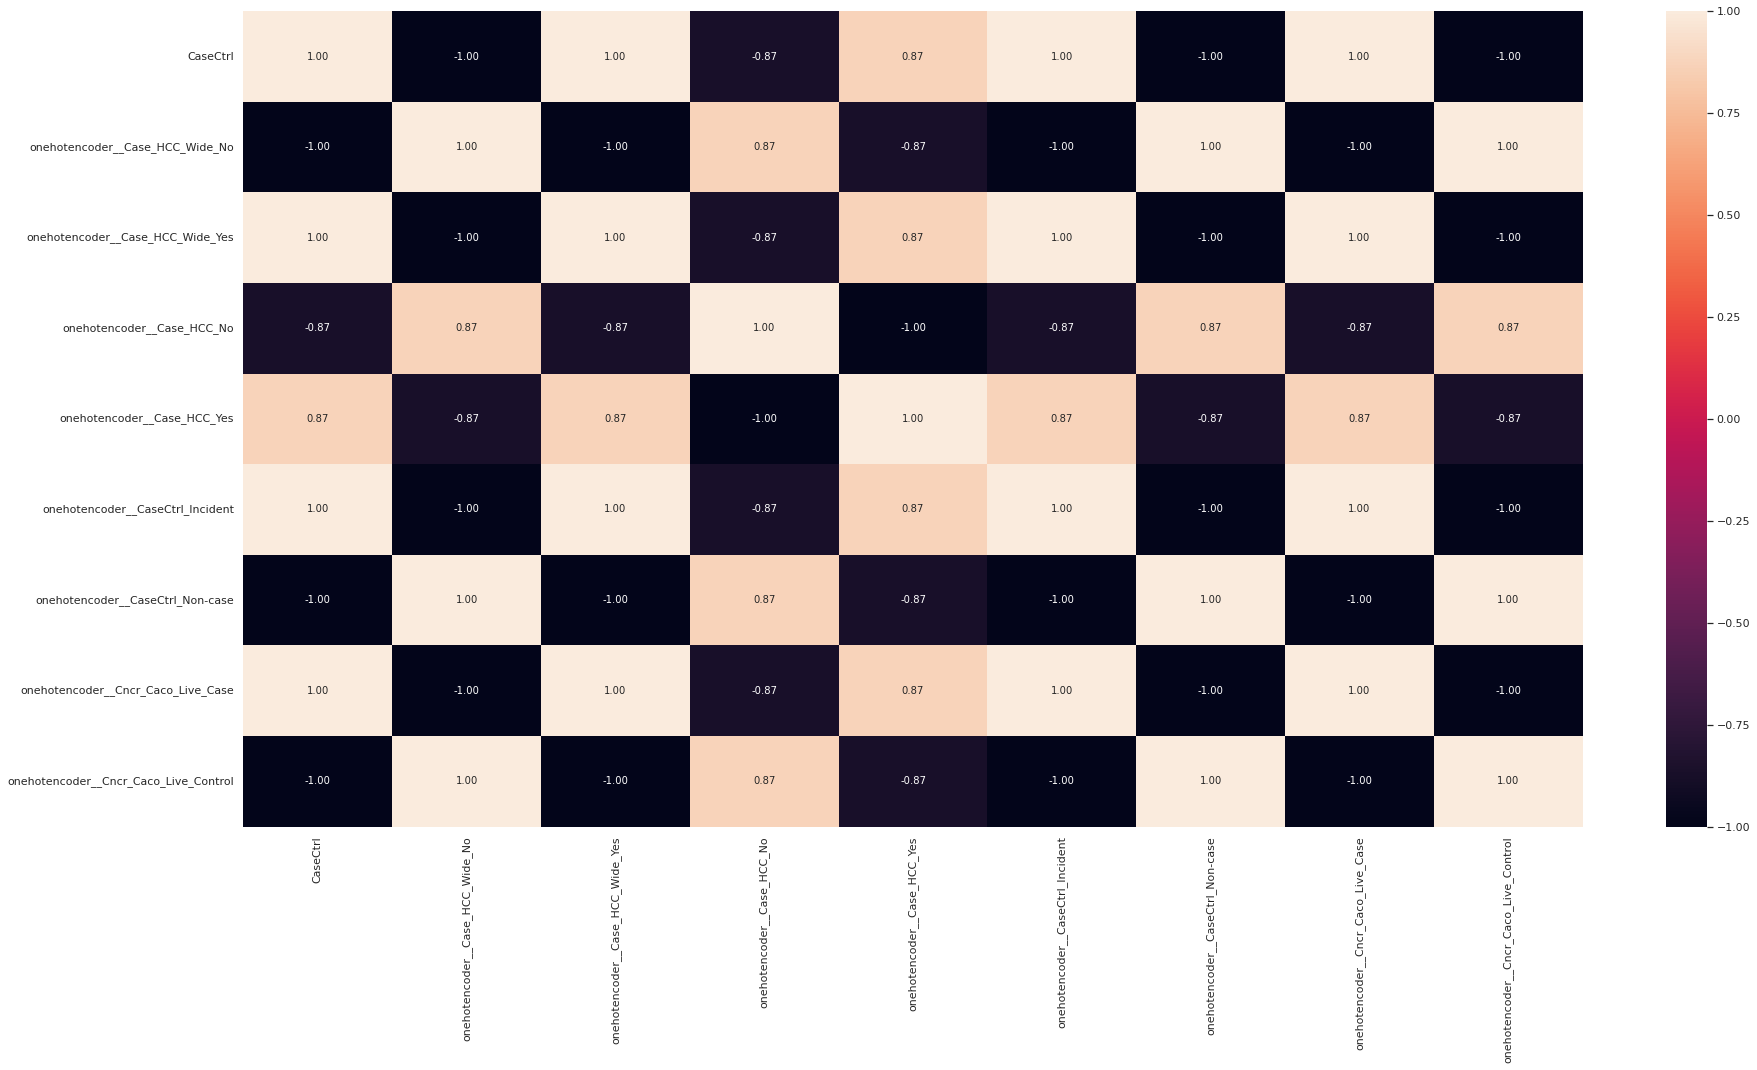

In [19]:
casectrl = pd.concat([metadata_index['CaseCtrl'], metadata[targets]], axis=1)

from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
casectrl['CaseCtrl'] = enc.fit_transform(casectrl['CaseCtrl'])
casectrl['CaseCtrl'] = (casectrl['CaseCtrl'] - 1).abs()

plt.figure(figsize=(30,15))
sns.heatmap(casectrl.corr(method='spearman'), annot=True, fmt='.2f')
plt.show()

#### We can see that <code>CaseCtrl</code> (which should be the ground truth) is not correlated to 1 (or -1) with <code>Case_HCC</code>. We will use <code>CaseCtrl</code> as target for the following analysis.

In [20]:
metadata = metadata.drop(targets, axis=1)
metadata

Age_Blood  Age_Recr  Height_Adj  Weight_Adj  Hip_Adj  Waist_Adj  Whr_Adj  \
0       72.994  73.01300       190.5       119.0    124.5      121.2     0.97   
1       72.966  72.98289       166.2        81.2    101.0       91.0     0.90   
2       53.977  53.99863       154.7        61.4    102.0       80.2     0.79   
3       53.544  53.56331       163.3        58.8     96.1       71.0     0.74   
4       64.559  64.55852       150.5        57.7     92.0       88.0     0.96   
..         ...       ...         ...         ...      ...        ...      ...   
181     66.445  66.33539       154.5        74.0    100.0      101.0     1.01   
182     71.619  71.61944       157.5        78.0    116.7       96.4     0.83   
183     71.543  71.54278       154.5        77.3    108.3       96.5     0.89   
184     51.340  51.34018       180.0        95.5    108.0       96.0     0.89   
185     50.932  50.93224       180.5        84.5    100.0       95.0     0.95   

     Bmi_Adj  Height_C  Weight_C  ...  onehotencoder__Lab_25OH_VitD2_<1.56  \
0      32.79     190.5     119.0  ...                                  1.0   
1      29.40     166.2      81.2  ...                                  1.0   
2      25.66     154.7      61.4  ...                                  1.0   
3      22.05     163.3      58.8  ...                                  1.0   
4      25.47     150.5      57.7  ...                                  1.0   
..       ...       ...       ...  ...                                  ...   
181    31.00     154.5      74.0  ...                                  1.0   
182    31.44     157.5      78.0  ...                                  1.0   
183    32.38     154.5      77.3  ...                                  1.0   
184    29.48     180.0      95.5  ...                                  1.0   
185    25.94     180.5      84.5  ...                                  1.0   

     onehotencoder__Lab_25OH_VitD2_Unknown  onehotencoder__Hyperl_Do not k  \
0                                      0.0                             0.0   
1                                      0.0                             0.0   
2                                      0.0                             0.0   
3                                      0.0                             0.0   
4                                      0.0                             0.0   
..                                     ...                             ...   
181                                    0.0                             0.0   
182                                    0.0                             0.0   
183                                    0.0                             0.0   
184                                    0.0                             0.0   
185                                    0.0                             0.0   

     onehotencoder__Hyperl_No  onehotencoder__Hyperl_Unknown  \
0                         0.0                            1.0   
1                         0.0                            1.0   
2                         0.0                            1.0   
3                         0.0                            1.0   
4                         1.0                            0.0   
..                        ...                            ...   
181                       0.0                            0.0   
182                       1.0                            0.0   
183                       1.0                            0.0   
184                       0.0                            0.0   
185                       0.0                            0.0   

     onehotencoder__Hyperl_Yes  onehotencoder__Gallst_Do not k  \
0                          0.0                             0.0   
1                          0.0                             0.0   
2                          0.0                             0.0   
3                          0.0                             0.0   
4                          0.0                             

## e - Remove features in metadata with should not be taken into account :
- <code>onehotencoder__Vit_Stat_Alive</code> and <code>onehotencoder__Vit_Stat_Dead</code> : either patient is dead or alive. It is a too strong explanatory feature here, it classifies great the two groups Incident vs. Non-case but don't give any biological new discovery

In [21]:
non_relevant_metadata_features = []

non_relevant_metadata_features.extend(['onehotencoder__Vit_Stat_Alive', 'onehotencoder__Vit_Stat_Dead'])
non_relevant_metadata_features

['onehotencoder__Vit_Stat_Alive', 'onehotencoder__Vit_Stat_Dead']

In [22]:
metadata = metadata.drop(non_relevant_metadata_features, axis=1)
metadata

Age_Blood  Age_Recr  Height_Adj  Weight_Adj  Hip_Adj  Waist_Adj  Whr_Adj  \
0       72.994  73.01300       190.5       119.0    124.5      121.2     0.97   
1       72.966  72.98289       166.2        81.2    101.0       91.0     0.90   
2       53.977  53.99863       154.7        61.4    102.0       80.2     0.79   
3       53.544  53.56331       163.3        58.8     96.1       71.0     0.74   
4       64.559  64.55852       150.5        57.7     92.0       88.0     0.96   
..         ...       ...         ...         ...      ...        ...      ...   
181     66.445  66.33539       154.5        74.0    100.0      101.0     1.01   
182     71.619  71.61944       157.5        78.0    116.7       96.4     0.83   
183     71.543  71.54278       154.5        77.3    108.3       96.5     0.89   
184     51.340  51.34018       180.0        95.5    108.0       96.0     0.89   
185     50.932  50.93224       180.5        84.5    100.0       95.0     0.95   

     Bmi_Adj  Height_C  Weight_C  ...  onehotencoder__Lab_25OH_VitD2_<1.56  \
0      32.79     190.5     119.0  ...                                  1.0   
1      29.40     166.2      81.2  ...                                  1.0   
2      25.66     154.7      61.4  ...                                  1.0   
3      22.05     163.3      58.8  ...                                  1.0   
4      25.47     150.5      57.7  ...                                  1.0   
..       ...       ...       ...  ...                                  ...   
181    31.00     154.5      74.0  ...                                  1.0   
182    31.44     157.5      78.0  ...                                  1.0   
183    32.38     154.5      77.3  ...                                  1.0   
184    29.48     180.0      95.5  ...                                  1.0   
185    25.94     180.5      84.5  ...                                  1.0   

     onehotencoder__Lab_25OH_VitD2_Unknown  onehotencoder__Hyperl_Do not k  \
0                                      0.0                             0.0   
1                                      0.0                             0.0   
2                                      0.0                             0.0   
3                                      0.0                             0.0   
4                                      0.0                             0.0   
..                                     ...                             ...   
181                                    0.0                             0.0   
182                                    0.0                             0.0   
183                                    0.0                             0.0   
184                                    0.0                             0.0   
185                                    0.0                             0.0   

     onehotencoder__Hyperl_No  onehotencoder__Hyperl_Unknown  \
0                         0.0                            1.0   
1                         0.0                            1.0   
2                         0.0                            1.0   
3                         0.0                            1.0   
4                         1.0                            0.0   
..                        ...                            ...   
181                       0.0                            0.0   
182                       1.0                            0.0   
183                       1.0                            0.0   
184                       0.0                            0.0   
185                       0.0                            0.0   

     onehotencoder__Hyperl_Yes  onehotencoder__Gallst_Do not k  \
0                          0.0                             0.0   
1                          0.0                             0.0   
2                          0.0                             0.0   
3                          0.0                             0.0   
4                          0.0                             

## f - Remove correlated features in metadata

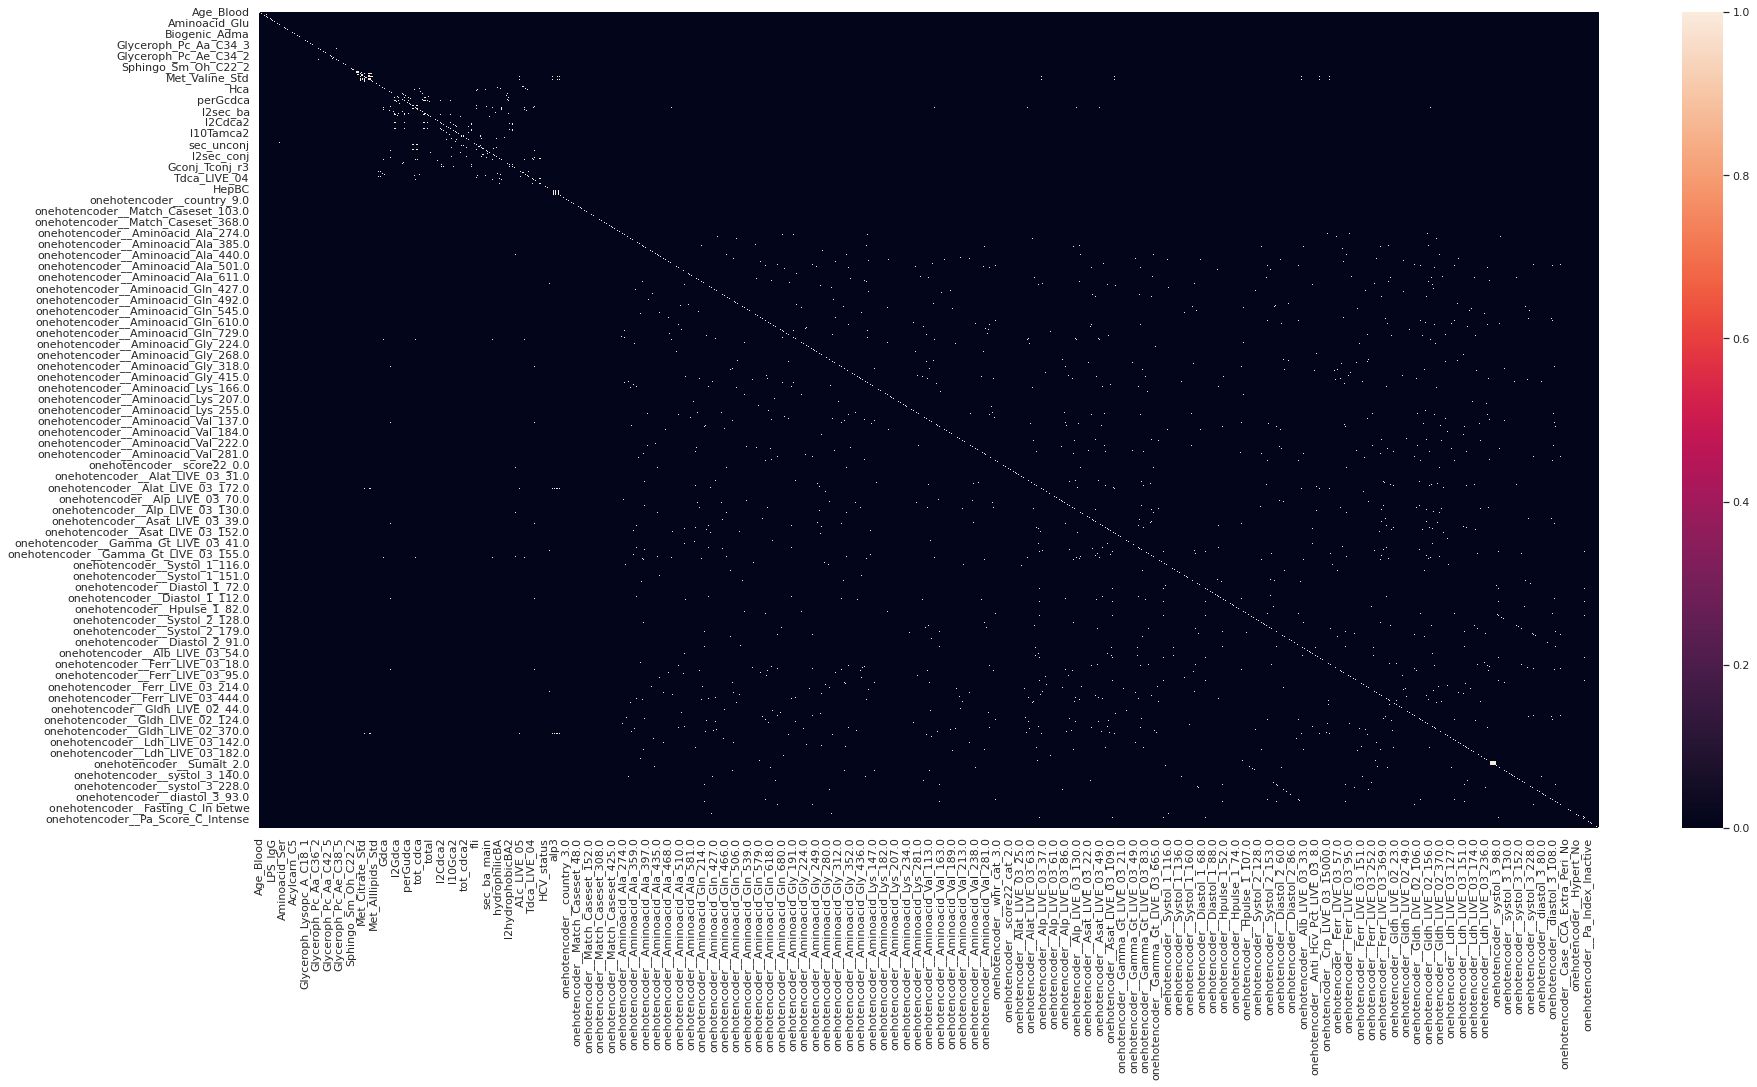

In [23]:
plt.figure(figsize=(30,15))
sns.heatmap((metadata.corr(method='pearson') > 0.9) | (metadata.corr(method='pearson') < -0.9))
plt.show()

In [24]:
metadata_remove_corr = remove_correlated_features(metadata)
metadata_remove_corr

Initial shape : (186, 2360)
Final shape : (186, 1310)

Time to compute : 00h00m02s

 ######################################################################################################################################################






Age_Blood  Height_Adj  Weight_Adj  Hip_Adj  Waist_Adj  Whr_Adj  Bmi_Adj  \
0       72.994       190.5       119.0    124.5      121.2     0.97    32.79   
1       72.966       166.2        81.2    101.0       91.0     0.90    29.40   
2       53.977       154.7        61.4    102.0       80.2     0.79    25.66   
3       53.544       163.3        58.8     96.1       71.0     0.74    22.05   
4       64.559       150.5        57.7     92.0       88.0     0.96    25.47   
..         ...         ...         ...      ...        ...      ...      ...   
181     66.445       154.5        74.0    100.0      101.0     1.01    31.00   
182     71.619       157.5        78.0    116.7       96.4     0.83    31.44   
183     71.543       154.5        77.3    108.3       96.5     0.89    32.38   
184     51.340       180.0        95.5    108.0       96.0     0.89    29.48   
185     50.932       180.5        84.5    100.0       95.0     0.95    25.94   

     Height_C  Weight_C  Bmi_C  ...  onehotencoder__Pa_Total_Sx_Moderate  \
0       190.5     119.0  32.79  ...                                  1.0   
1       166.2      81.2  29.40  ...                                  1.0   
2       154.7      61.4  25.66  ...                                  1.0   
3       163.3      58.8  22.05  ...                                  0.0   
4       150.5      57.7  25.47  ...                                  1.0   
..        ...       ...    ...  ...                                  ...   
181     154.5      74.0  31.00  ...                                  1.0   
182     157.5      78.0  31.44  ...                                  1.0   
183     154.5      77.3  32.38  ...                                  1.0   
184     180.0      95.5  29.48  ...                                  1.0   
185     180.5      84.5  25.94  ...                                  1.0   

     onehotencoder__Lab_25OH_VitD2_<1.56  onehotencoder__Hyperl_Do not k  \
0                                    1.0                             0.0   
1                                    1.0                             0.0   
2                                    1.0                             0.0   
3                                    1.0                             0.0   
4                                    1.0                             0.0   
..                                   ...                             ...   
181                                  1.0                             0.0   
182                                  1.0                             0.0   
183                                  1.0                             0.0   
184                                  1.0                             0.0   
185                                  1.0                             0.0   

     onehotencoder__Hyperl_No  onehotencoder__Hyperl_Unknown  \
0                         0.0                            1.0   
1                         0.0                            1.0   
2                         0.0                            1.0   
3                         0.0                            1.0   
4                         1.0                            0.0   
..                        ...                            ...   
181                       0.0                            0.0   
182                       1.0                            0.0   
183                       1.0                            0.0   
184                       0.0                            0.0   
185                       0.0                            0.0   

     onehotencoder__Hyperl_Yes  onehotencoder__Gallst_Do not k  \
0                          0.0                             0.0   
1                          0.0                             0.0   
2                          0.0                             0.0   
3                          0.0                             0.0   
4                          0.0                             0.0   
..                         ...                       

## g - Check missing values in intensities

(186, 1215)


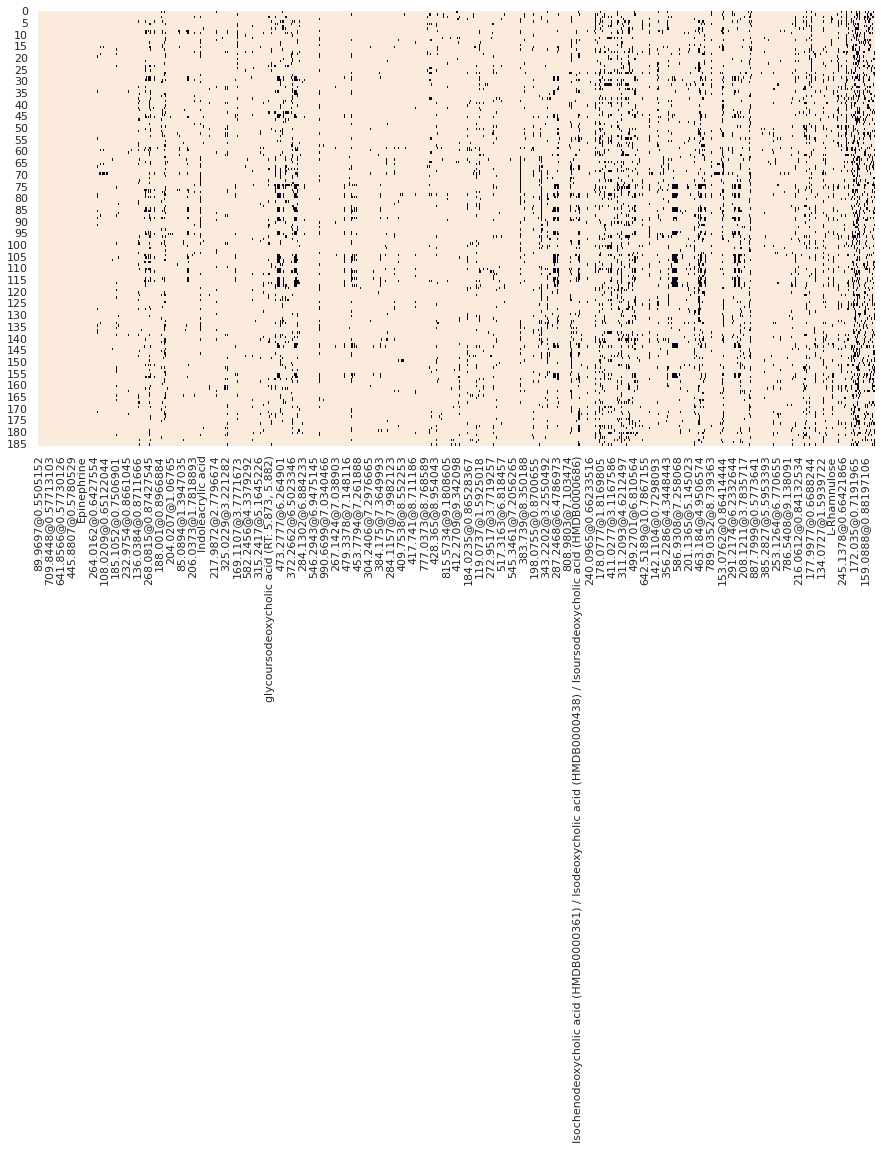

In [25]:
plt.figure(figsize=(15,8))
print(intensities.shape)
sns.heatmap(intensities.notna(), cbar=False);

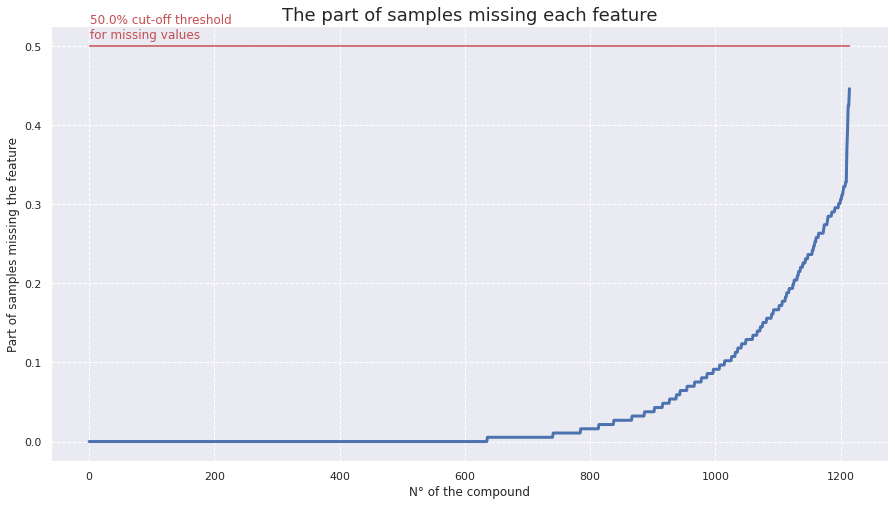

In [26]:
perc_mv = intensities.isna().sum() / intensities.shape[0]
threshold = 0.5
plt.figure(figsize=(15,8))
plt.plot(perc_mv.sort_values().values, color='b', linewidth=3)
plt.hlines(y=threshold, xmin=0, xmax=len(perc_mv), color ='r')
plt.text(x=2, y=threshold+0.01, s=f'{threshold*100}% cut-off threshold \nfor missing values', color='r', fontsize=12)
plt.xlabel('N° of the compound', fontsize=12)
plt.ylabel('Part of samples missing the feature', fontsize=12)
plt.title('The part of samples missing each feature', fontsize=18)
plt.grid(linestyle='--', linewidth=1)
plt.show()

#### There is no compound with more than 50% of missing values

# 2 - Impute missing values

## a - Impute intensities with 1's

In [27]:
from missing_value_imputation_functions import *

In [28]:
intensities_imp1 = const_imputer(intensities, 1)
intensities_imp1

89.9697@0.5505152  90.973@0.55399996  939.813@0.56963736  \
0              4195138              40495             42242.0   
1              4306680              38555             49922.0   
2              4457872              41892             49890.0   
3              4128863              39711             33517.0   
4              4438077              43225             62259.0   
..                 ...                ...                 ...   
181            4416705              40954             47502.0   
182            4727455              44619             65454.0   
183            4643850              44234             62270.0   
184            4107050              38737             27127.0   
185            4671588              42617             66228.0   

     157.9574@0.5643974  871.8258@0.5736113  803.8387@0.5745634  \
0               2794282             50841.0             60628.0   
1               2930790             61613.0             73916.0   
2               2974132             61331.0             73473.0   
3               2769811             40177.0             46566.0   
4               2976035             74326.0             93735.0   
..                  ...                 ...                 ...   
181             3017039             56174.0             69562.0   
182             3237331             80203.0             99917.0   
183             3170819             75882.0             94129.0   
184             2681910             30093.0             39345.0   
185             3178603             80117.0            101130.0   

     973.8083@0.56959826  599.8754@0.5742488  811.8258@0.57766384  \
0                74517.0            100523.0              64318.0   
1                84277.0            120525.0              69334.0   
2                86310.0            116998.0              69140.0   
3                60449.0             80091.0              62495.0   
4               102111.0            138763.0              59839.0   
..                   ...                 ...                  ...   
181              81828.0             93578.0              64371.0   
182             114212.0            127797.0              59777.0   
183             104118.0            120689.0              60576.0   
184              52179.0             57230.0              56211.0   
185             113785.0            129753.0              59497.0   

     667.8631@0.57489955  ...  225.1218@0.86389714  398.7578@8.768545  \
0               108194.0  ...                  1.0            98959.0   
1               133694.0  ...               2414.0            93145.0   
2               132044.0  ...                  1.0            93997.0   
3                87292.0  ...               1378.0            93555.0   
4               163759.0  ...                  1.0            96460.0   
..                   ...  ...                  ...                ...   
181             122940.0  ...                  1.0            97137.0   
182             169132.0  ...               4823.0                1.0   
183             159518.0  ...               4761.0                1.0   
184              67452.0  ...              38674.0            89525.0   
185             173083.0  ...              12552.0            77676.0   

     288.1272@6.883725  126.0287@1.5353005  429.2873@6.211831  \
0              20987.0            178906.0                1.0   
1              28323.0                 1.0                1.0   
2              16393.0            171962.0                1.0   
3                  1.0                 1.0             4293.0   
4                  1.0            158917.0             9750.0   
..                 ...                 ...                ...   
181            24680.0             96880.0             1965.0   
182            17378.0             93893.0             9988.0   
183            16624.0            108831.0             3127.0   
184            11619.0            105422.0             3152.0  

## b - Convert all intensities columns to integers

#### During preprocessing, pandas modules converts ints to floats when there are NaNs in the column. We can re-convert all intensities columns to int

In [29]:
intensities_imp1.dtypes.value_counts()

float64    1153
int64        62
dtype: int64

In [30]:
intensities_imp1.select_dtypes(include=['int64'])

89.9697@0.5505152  90.973@0.55399996  157.9574@0.5643974  \
0              4195138              40495             2794282   
1              4306680              38555             2930790   
2              4457872              41892             2974132   
3              4128863              39711             2769811   
4              4438077              43225             2976035   
..                 ...                ...                 ...   
181            4416705              40954             3017039   
182            4727455              44619             3237331   
183            4643850              44234             3170819   
184            4107050              38737             2681910   
185            4671588              42617             3178603   

     225.9447@0.5745108  361.92@0.5759258  105.9431@0.5759475  \
0              11633231           2084234              224455   
1              12533167           2267190              199344   
2              12519280           2271568              198422   
3              11341544           1973798              269227   
4              12882379           2345672              150544   
..                  ...               ...                 ...   
181            12547882           2150224              223734   
182            13643925           2356231              171694   
183            13297854           2310653              175541   
184            10733343           1781652              328135   
185            13481347           2357590              158998   

     241.9199@0.57671624  103.1@0.59041923  creatinine  105.0425@0.62294775  \
0                2189519           6956331     9954784               188204   
1                1987975          10031965     7650518               259359   
2                2035706           5936173     5740433               280771   
3                2638099           7705453     5808618               338114   
4                1529466           7132603     6060199               265645   
..                   ...               ...         ...                  ...   
181              2017261           7368889     6583229               168193   
182              1522009           7615510     4511929               252894   
183              1560211           5345075     5477736               187914   
184              2711324           7713904     5547938               161944   
185              1430718           4391686     6696412               138864   

     ...  607.376@4.1568255  638.9637@7.4877768  Taurine  101.0479@0.638489  \
0    ...               9341               34372   191460              67859   
1    ...               9264               36528   361072             116133   
2    ...              99263               24717   426498              97657   
3    ...              76663               34776   488963             112323   
4    ...               3505               23310   121989             115428   
..   ...                ...                 ...      ...                ...   
181  ...              83217               58450   285593              76726   
182  ...               2768               40116   271997              93436   
183  ...               2862               42589   209224              62260   
184  ...               7140               42507   433733              80130   
185  ...               4767               39349   125071              68906   

     158.0556@0.74035805  230.979@0.8689297  398.2486@8.142346  L-Homoserine  \
0                  25883              57132              40736        670461   
1                  16354              34212              26456       1133997   
2                  21431              30134              45065        955009   
3                  23408              35916              36895       1067774   
4                  40839              19954              62631       1237210   
..                   ...                ...                ...   

In [31]:
intensities_imp1.select_dtypes(include=['float64'])

939.813@0.56963736  871.8258@0.5736113  803.8387@0.5745634  \
0               42242.0             50841.0             60628.0   
1               49922.0             61613.0             73916.0   
2               49890.0             61331.0             73473.0   
3               33517.0             40177.0             46566.0   
4               62259.0             74326.0             93735.0   
..                  ...                 ...                 ...   
181             47502.0             56174.0             69562.0   
182             65454.0             80203.0             99917.0   
183             62270.0             75882.0             94129.0   
184             27127.0             30093.0             39345.0   
185             66228.0             80117.0            101130.0   

     973.8083@0.56959826  599.8754@0.5742488  811.8258@0.57766384  \
0                74517.0            100523.0              64318.0   
1                84277.0            120525.0              69334.0   
2                86310.0            116998.0              69140.0   
3                60449.0             80091.0              62495.0   
4               102111.0            138763.0              59839.0   
..                   ...                 ...                  ...   
181              81828.0             93578.0              64371.0   
182             114212.0            127797.0              59777.0   
183             104118.0            120689.0              60576.0   
184              52179.0             57230.0              56211.0   
185             113785.0            129753.0              59497.0   

     667.8631@0.57489955  293.933@0.5723928  218.076@0.5792143  \
0               108194.0          1302422.0            48927.0   
1               133694.0          1366091.0            81471.0   
2               132044.0          1373347.0            88602.0   
3                87292.0          1266035.0            82236.0   
4               163759.0          1350075.0           119411.0   
..                   ...                ...                ...   
181             122940.0          1187045.0            71503.0   
182             169132.0          1289934.0            78768.0   
183             159518.0          1259722.0            74924.0   
184              67452.0          1001685.0            80562.0   
185             173083.0          1264956.0            65457.0   

     777.8291@0.57725763  ...  225.1218@0.86389714  398.7578@8.768545  \
0                76655.0  ...                  1.0            98959.0   
1                80010.0  ...               2414.0            93145.0   
2                78117.0  ...                  1.0            93997.0   
3                74259.0  ...               1378.0            93555.0   
4                71551.0  ...                  1.0            96460.0   
..                   ...  ...                  ...                ...   
181              75547.0  ...                  1.0            97137.0   
182              73255.0  ...               4823.0                1.0   
183              71217.0  ...               4761.0                1.0   
184              62191.0  ...              38674.0            89525.0   
185              70633.0  ...              12552.0            77676.0   

     288.1272@6.883725  126.0287@1.5353005  429.2873@6.211831  \
0              20987.0            178906.0                1.0   
1              28323.0                 1.0                1.0   
2              16393.0            171962.0                1.0   
3                  1.0                 1.0             4293.0   
4                  1.0            158917.0             9750.0   
..                 ...                 ...                ...   
181            24680.0             96880.0             1965.0   
182            17378.0             93893.0             9988.0   
183            16624.0            108831.0             3127.0   
184            11619.0            105422.0         

In [32]:
intensities_imp1 = intensities_imp1.astype(int)
intensities_imp1

89.9697@0.5505152  90.973@0.55399996  939.813@0.56963736  \
0              4195138              40495               42242   
1              4306680              38555               49922   
2              4457872              41892               49890   
3              4128863              39711               33517   
4              4438077              43225               62259   
..                 ...                ...                 ...   
181            4416705              40954               47502   
182            4727455              44619               65454   
183            4643850              44234               62270   
184            4107050              38737               27127   
185            4671588              42617               66228   

     157.9574@0.5643974  871.8258@0.5736113  803.8387@0.5745634  \
0               2794282               50841               60628   
1               2930790               61613               73916   
2               2974132               61331               73473   
3               2769811               40177               46566   
4               2976035               74326               93735   
..                  ...                 ...                 ...   
181             3017039               56174               69562   
182             3237331               80203               99917   
183             3170819               75882               94129   
184             2681910               30093               39345   
185             3178603               80117              101130   

     973.8083@0.56959826  599.8754@0.5742488  811.8258@0.57766384  \
0                  74517              100523                64318   
1                  84277              120525                69334   
2                  86310              116998                69140   
3                  60449               80091                62495   
4                 102111              138763                59839   
..                   ...                 ...                  ...   
181                81828               93578                64371   
182               114212              127797                59777   
183               104118              120689                60576   
184                52179               57230                56211   
185               113785              129753                59497   

     667.8631@0.57489955  ...  225.1218@0.86389714  398.7578@8.768545  \
0                 108194  ...                    1              98959   
1                 133694  ...                 2414              93145   
2                 132044  ...                    1              93997   
3                  87292  ...                 1378              93555   
4                 163759  ...                    1              96460   
..                   ...  ...                  ...                ...   
181               122940  ...                    1              97137   
182               169132  ...                 4823                  1   
183               159518  ...                 4761                  1   
184                67452  ...                38674              89525   
185               173083  ...                12552              77676   

     288.1272@6.883725  126.0287@1.5353005  429.2873@6.211831  \
0                20987              178906                  1   
1                28323                   1                  1   
2                16393              171962                  1   
3                    1                   1               4293   
4                    1              158917               9750   
..                 ...                 ...                ...   
181              24680               96880               1965   
182              17378               93893               9988   
183              16624              108831               3127   
184              11619              105422               3152  

In [33]:
intensities_imp1.dtypes.value_counts()

int64    1215
dtype: int64

## c - Remove correlated features in intensities

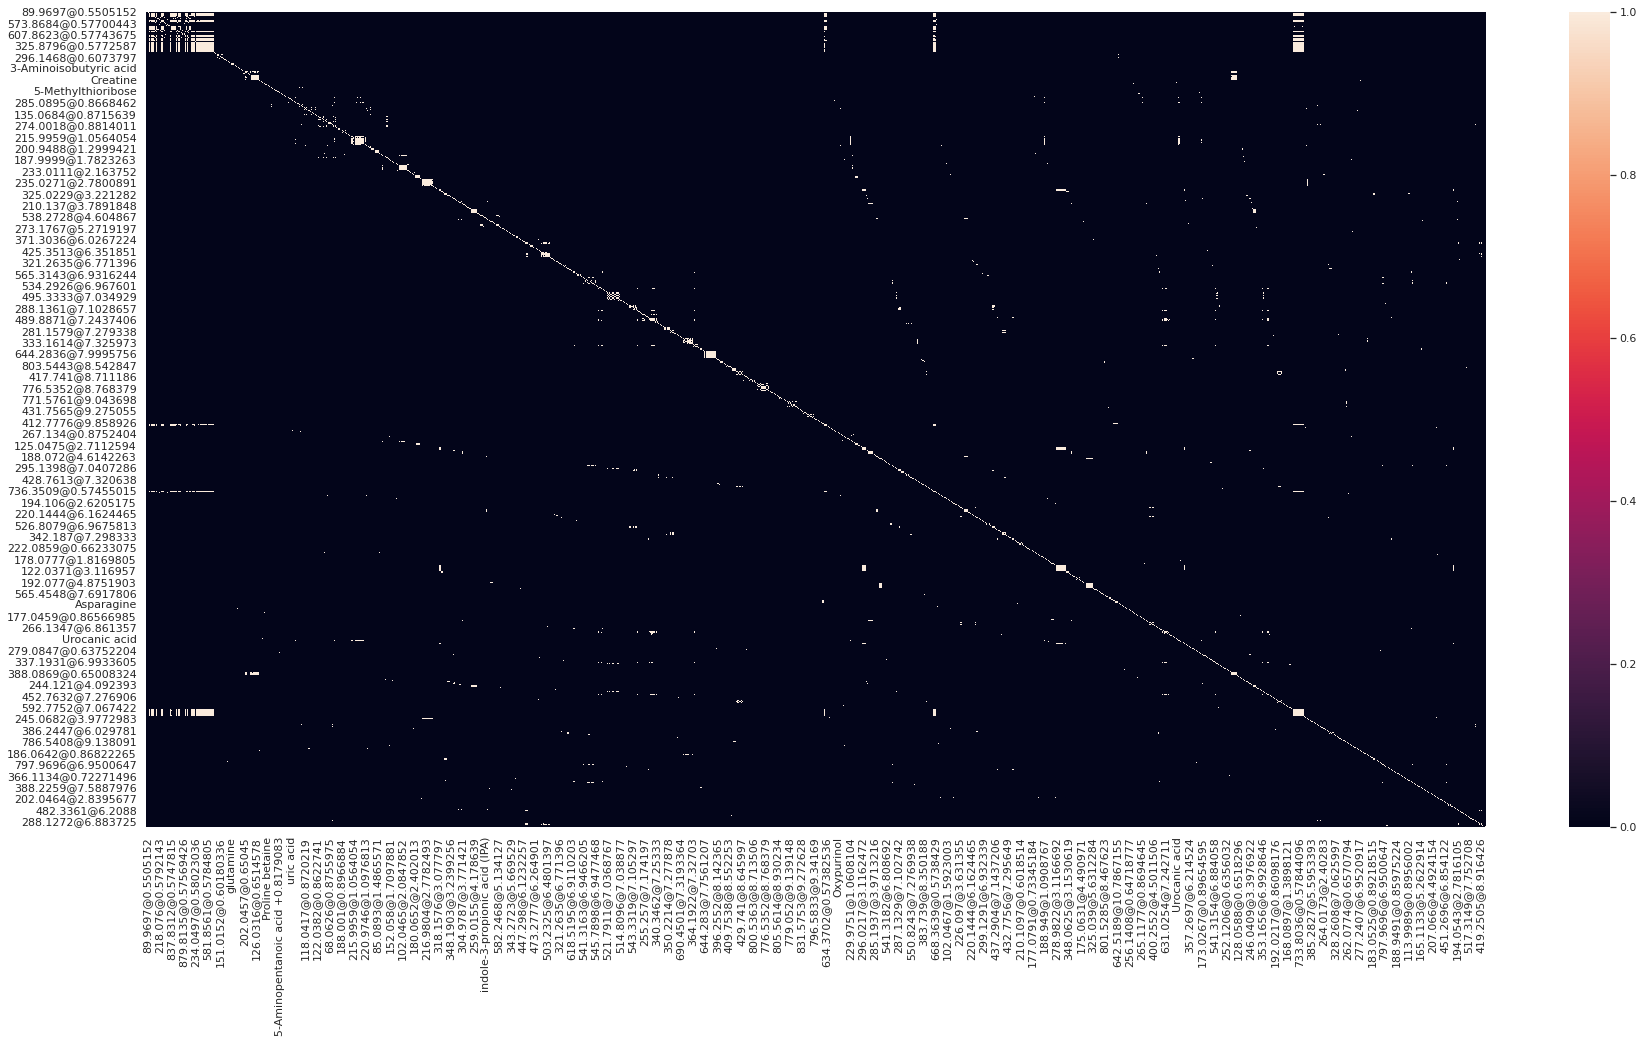

In [34]:
plt.figure(figsize=(30,15))
sns.heatmap((intensities_imp1.corr(method='pearson') > 0.9) | (intensities_imp1.corr(method='pearson') < -0.9))
plt.show()

In [35]:
intensities_imp1_remove_corr = remove_correlated_features(intensities_imp1)
intensities_imp1_remove_corr

Initial shape : (186, 1215)
Final shape : (186, 814)

Time to compute : 00h00m00s

 ######################################################################################################################################################






89.9697@0.5505152  90.973@0.55399996  939.813@0.56963736  \
0              4195138              40495               42242   
1              4306680              38555               49922   
2              4457872              41892               49890   
3              4128863              39711               33517   
4              4438077              43225               62259   
..                 ...                ...                 ...   
181            4416705              40954               47502   
182            4727455              44619               65454   
183            4643850              44234               62270   
184            4107050              38737               27127   
185            4671588              42617               66228   

     811.8258@0.57766384  293.933@0.5723928  218.076@0.5792143  \
0                  64318            1302422              48927   
1                  69334            1366091              81471   
2                  69140            1373347              88602   
3                  62495            1266035              82236   
4                  59839            1350075             119411   
..                   ...                ...                ...   
181                64371            1187045              71503   
182                59777            1289934              78768   
183                60576            1259722              74924   
184                56211            1001685              80562   
185                59497            1264956              65457   

     777.8291@0.57725763  709.8448@0.57713103  573.8684@0.57700443  \
0                  76655               103479                55064   
1                  80010               107556                56424   
2                  78117               104620                54003   
3                  74259                95968                50221   
4                  71551                96049                48336   
..                   ...                  ...                  ...   
181                75547                99353                38645   
182                73255                99925                36634   
183                71217                93289                36109   
184                62191                86920                36778   
185                70633                93455                35018   

     913.8054@0.57497376  ...  159.0888@0.88197106  472.2434@6.9100556  \
0                  41463  ...                14566                   1   
1                  40797  ...                 6629                3909   
2                  41221  ...                    1                   1   
3                  34992  ...                    1                8311   
4                  38707  ...                13912                   1   
..                   ...  ...                  ...                 ...   
181                39130  ...                 1356                2066   
182                38942  ...                10851                   1   
183                37454  ...                 9057                   1   
184                33791  ...                23868                4599   
185                36120  ...                18694               20952   

     342.216@6.782953  429.7409@8.504203  398.7578@8.768545  \
0                4396              46985              98959   
1               52685                  1              93145   
2               20257                  1              93997   
3               11512                  1              93555   
4                8166              26179              96460   
..                ...                ...                ...   
181             15653              23446              97137   
182             13978              23453                  1   
183             17319                  1                  1   
184             11249              23477              89525   
185     

# 3 - Concat metadata (*metadata* dataframe) and imputed intensities (*intensities_imp1* dataframe). We will concat *metadata_index* dataframe later

In [36]:
peakTable_Agilent_imp = pd.concat([metadata_remove_corr, intensities_imp1_remove_corr], axis=1)
peakTable_Agilent_imp

Age_Blood  Height_Adj  Weight_Adj  Hip_Adj  Waist_Adj  Whr_Adj  Bmi_Adj  \
0       72.994       190.5       119.0    124.5      121.2     0.97    32.79   
1       72.966       166.2        81.2    101.0       91.0     0.90    29.40   
2       53.977       154.7        61.4    102.0       80.2     0.79    25.66   
3       53.544       163.3        58.8     96.1       71.0     0.74    22.05   
4       64.559       150.5        57.7     92.0       88.0     0.96    25.47   
..         ...         ...         ...      ...        ...      ...      ...   
181     66.445       154.5        74.0    100.0      101.0     1.01    31.00   
182     71.619       157.5        78.0    116.7       96.4     0.83    31.44   
183     71.543       154.5        77.3    108.3       96.5     0.89    32.38   
184     51.340       180.0        95.5    108.0       96.0     0.89    29.48   
185     50.932       180.5        84.5    100.0       95.0     0.95    25.94   

     Height_C  Weight_C  Bmi_C  ...  159.0888@0.88197106  472.2434@6.9100556  \
0       190.5     119.0  32.79  ...                14566                   1   
1       166.2      81.2  29.40  ...                 6629                3909   
2       154.7      61.4  25.66  ...                    1                   1   
3       163.3      58.8  22.05  ...                    1                8311   
4       150.5      57.7  25.47  ...                13912                   1   
..        ...       ...    ...  ...                  ...                 ...   
181     154.5      74.0  31.00  ...                 1356                2066   
182     157.5      78.0  31.44  ...                10851                   1   
183     154.5      77.3  32.38  ...                 9057                   1   
184     180.0      95.5  29.48  ...                23868                4599   
185     180.5      84.5  25.94  ...                18694               20952   

     342.216@6.782953  429.7409@8.504203  398.7578@8.768545  \
0                4396              46985              98959   
1               52685                  1              93145   
2               20257                  1              93997   
3               11512                  1              93555   
4                8166              26179              96460   
..                ...                ...                ...   
181             15653              23446              97137   
182             13978              23453                  1   
183             17319                  1                  1   
184             11249              23477              89525   
185              2726              22792              77676   

     288.1272@6.883725  126.0287@1.5353005  419.2505@8.916426  \
0                20987              178906             184072   
1                28323                   1                  1   
2                16393              171962             125149   
3                    1                   1             140514   
4                    1              158917             154104   
..                 ...                 ...                ...   
181              24680               96880                  1   
182              17378               93893              87218   
183              16624              108831                  1   
184              11619              105422              89313   
185              17258              168359              64781   

     103.0998@7.112515  267.142@6.969883  
0                    1            149023  
1               403011            164386  
2                    1             99967  
3               399109            164202  
4               264003            105903  
..                 ...               ...  
181             228548            111077  
182             221296             97565  
183             369559                 1  
184             212520                 1  
185             359724                 1  

[186 rows x 2124 columns]

In [37]:
peakTable_Agilent_imp.dtypes.value_counts()

float64    1310
int64       814
dtype: int64

# 4 - Standard scale imputed peak table (metadata + intensities) BUT not binary columns

In [38]:
from normalisation_scaling_functions import *

## a - Subset binary columns

In [39]:
bool_cols = [col for col in peakTable_Agilent_imp if np.isin(peakTable_Agilent_imp[col].dropna().unique(), [0, 1]).all()]
print(len(bool_cols))
print(bool_cols[:10])

982
['Met_Serumclotcontacttime', 'Hepatitis', 'HBV_status', 'HCV_status', 'HbV_status2', 'HcV_status2', 'ALTsc2', 'ASTsc2', 'GGTsc2', 'ALPsc2']


In [40]:
peakTable_Agilent_imp_bool_cols = peakTable_Agilent_imp[bool_cols]
peakTable_Agilent_imp_bool_cols

Met_Serumclotcontacttime  Hepatitis  HBV_status  HCV_status  HbV_status2  \
0                         1.0        0.0         0.0         0.0          0.0   
1                         1.0        0.0         0.0         0.0          0.0   
2                         0.0        0.0         0.0         0.0          1.0   
3                         0.0        0.0         0.0         0.0          1.0   
4                         0.0        0.0         0.0         0.0          0.0   
..                        ...        ...         ...         ...          ...   
181                       1.0        0.0         0.0         0.0          0.0   
182                       0.0        0.0         0.0         0.0          0.0   
183                       0.0        0.0         0.0         0.0          0.0   
184                       1.0        0.0         0.0         0.0          1.0   
185                       0.0        0.0         0.0         0.0          0.0   

     HcV_status2  ALTsc2  ASTsc2  GGTsc2  ALPsc2  ...  \
0            0.0     1.0     1.0     1.0     0.0  ...   
1            0.0     0.0     0.0     0.0     0.0  ...   
2            1.0     0.0     1.0     0.0     0.0  ...   
3            0.0     0.0     0.0     0.0     0.0  ...   
4            1.0     1.0     1.0     1.0     0.0  ...   
..           ...     ...     ...     ...     ...  ...   
181          0.0     0.0     0.0     0.0     0.0  ...   
182          1.0     0.0     0.0     0.0     0.0  ...   
183          0.0     1.0     1.0     0.0     0.0  ...   
184          1.0     0.0     1.0     1.0     0.0  ...   
185          0.0     0.0     0.0     0.0     0.0  ...   

     onehotencoder__Pa_Total_Sx_Moderate  onehotencoder__Lab_25OH_VitD2_<1.56  \
0                                    1.0                                  1.0   
1                                    1.0                                  1.0   
2                                    1.0                                  1.0   
3                                    0.0                                  1.0   
4                                    1.0                                  1.0   
..                                   ...                                  ...   
181                                  1.0                                  1.0   
182                                  1.0                                  1.0   
183                                  1.0                                  1.0   
184                                  1.0                                  1.0   
185                                  1.0                                  1.0   

     onehotencoder__Hyperl_Do not k  onehotencoder__Hyperl_No  \
0                               0.0                       0.0   
1                               0.0                       0.0   
2                               0.0                       0.0   
3                               0.0                       0.0   
4                               0.0                       1.0   
..                              ...                       ...   
181                             0.0                       0.0   
182                             0.0                       1.0   
183                             0.0                       1.0   
184                             0.0                       0.0   
185                             0.0                       0.0   

     onehotencoder__Hyperl_Unknown  onehotencoder__Hyperl_Yes  \
0                              1.0                        0.0   
1                              1.0                        0.0   
2                              1.0                        0.0   
3                              1.0                        0.0   
4                              0.0                        0.0   
..                             ...                        ...   
181                            0.0                        1.0   
182                            0.0                        0.0   
183     

In [41]:
peakTable_Agilent_imp_not_bool_cols = peakTable_Agilent_imp.drop(peakTable_Agilent_imp_bool_cols.columns, axis=1)
peakTable_Agilent_imp_not_bool_cols

Age_Blood  Height_Adj  Weight_Adj  Hip_Adj  Waist_Adj  Whr_Adj  Bmi_Adj  \
0       72.994       190.5       119.0    124.5      121.2     0.97    32.79   
1       72.966       166.2        81.2    101.0       91.0     0.90    29.40   
2       53.977       154.7        61.4    102.0       80.2     0.79    25.66   
3       53.544       163.3        58.8     96.1       71.0     0.74    22.05   
4       64.559       150.5        57.7     92.0       88.0     0.96    25.47   
..         ...         ...         ...      ...        ...      ...      ...   
181     66.445       154.5        74.0    100.0      101.0     1.01    31.00   
182     71.619       157.5        78.0    116.7       96.4     0.83    31.44   
183     71.543       154.5        77.3    108.3       96.5     0.89    32.38   
184     51.340       180.0        95.5    108.0       96.0     0.89    29.48   
185     50.932       180.5        84.5    100.0       95.0     0.95    25.94   

     Height_C  Weight_C  Bmi_C  ...  159.0888@0.88197106  472.2434@6.9100556  \
0       190.5     119.0  32.79  ...                14566                   1   
1       166.2      81.2  29.40  ...                 6629                3909   
2       154.7      61.4  25.66  ...                    1                   1   
3       163.3      58.8  22.05  ...                    1                8311   
4       150.5      57.7  25.47  ...                13912                   1   
..        ...       ...    ...  ...                  ...                 ...   
181     154.5      74.0  31.00  ...                 1356                2066   
182     157.5      78.0  31.44  ...                10851                   1   
183     154.5      77.3  32.38  ...                 9057                   1   
184     180.0      95.5  29.48  ...                23868                4599   
185     180.5      84.5  25.94  ...                18694               20952   

     342.216@6.782953  429.7409@8.504203  398.7578@8.768545  \
0                4396              46985              98959   
1               52685                  1              93145   
2               20257                  1              93997   
3               11512                  1              93555   
4                8166              26179              96460   
..                ...                ...                ...   
181             15653              23446              97137   
182             13978              23453                  1   
183             17319                  1                  1   
184             11249              23477              89525   
185              2726              22792              77676   

     288.1272@6.883725  126.0287@1.5353005  419.2505@8.916426  \
0                20987              178906             184072   
1                28323                   1                  1   
2                16393              171962             125149   
3                    1                   1             140514   
4                    1              158917             154104   
..                 ...                 ...                ...   
181              24680               96880                  1   
182              17378               93893              87218   
183              16624              108831                  1   
184              11619              105422              89313   
185              17258              168359              64781   

     103.0998@7.112515  267.142@6.969883  
0                    1            149023  
1               403011            164386  
2                    1             99967  
3               399109            164202  
4               264003            105903  
..                 ...               ...  
181             228548            111077  
182             221296             97565  
183             369559                 1  
184             212520                 1  
185             359724                 1  

[186 rows x 1142 columns]

## b - Standard scale non-binary metadata and intensities

In [42]:
peakTable_Agilent_imp_not_bool_cols_std = normPeakTable(peakTable_Agilent_imp_not_bool_cols, 'autoscaling', based='metabolites')
peakTable_Agilent_imp_not_bool_cols_std

Age_Blood  Height_Adj  Weight_Adj   Hip_Adj  Waist_Adj   Whr_Adj  \
0     1.870434    1.467763    2.339566  2.463979   2.118128  0.604728   
1     1.866567   -0.040015    0.196500 -0.281109  -0.283039 -0.150892   
2    -0.755844   -0.753572   -0.926059 -0.164297  -1.141734 -1.338294   
3    -0.815642   -0.219955   -1.073466 -0.853489  -1.873215 -1.878022   
4     0.705547   -1.014175   -1.135830 -1.332420  -0.521565  0.496782   
..         ...         ...         ...       ...        ...       ...   
181   0.966007   -0.765982   -0.211704 -0.397922   0.512050  1.036511   
182   1.680544   -0.579836    0.015076  1.552843   0.146309 -0.906511   
183   1.670049   -0.765982   -0.024610  0.571620   0.154260 -0.258837   
184  -1.120018    0.816254    1.007236  0.536577   0.114506 -0.258837   
185  -1.176364    0.847278    0.383593 -0.397922   0.034997  0.388837   

      Bmi_Adj  Height_C  Weight_C     Bmi_C  ...  159.0888@0.88197106  \
0    0.955185  2.156602  2.742696  1.130418  ...            -0.141802   
1    0.338686 -0.154936  0.155702  0.336250  ...            -0.558457   
2   -0.341463 -1.248874 -1.199390 -0.539912  ...            -0.906395   
3   -0.997970 -0.430799 -1.377331 -1.385619  ...            -0.906395   
4   -0.376016 -1.648399 -1.452614 -0.584423  ...            -0.176134   
..        ...       ...       ...       ...  ...                  ...   
181  0.629659 -1.267899 -0.337058  0.711079  ...            -0.835264   
182  0.709677 -0.982524 -0.063302  0.814157  ...            -0.336822   
183  0.880623 -1.267899 -0.111210  1.034369  ...            -0.430998   
184  0.353235  1.157789  1.134380  0.354992  ...             0.346509   
185 -0.290543  1.205352  0.381551 -0.474317  ...             0.074898   

     472.2434@6.9100556  342.216@6.782953  429.7409@8.504203  \
0             -0.894019         -0.336857           1.734889   
1             -0.232423          0.750259          -1.499918   
2             -0.894019          0.020217          -1.499918   
3              0.512803         -0.176656          -1.499918   
4             -0.894019         -0.251984           0.302414   
..                  ...               ...                ...   
181           -0.544430         -0.083431           0.114250   
182           -0.894019         -0.121140           0.114731   
183           -0.894019         -0.045925          -1.499918   
184           -0.115611         -0.182577           0.116384   
185            2.652832         -0.374453           0.069222   

     398.7578@8.768545  288.1272@6.883725  126.0287@1.5353005  \
0             0.556855           0.449726            1.248818   
1             0.376691           1.146810           -1.480012   
2             0.403093           0.013193            1.142901   
3             0.389396          -1.544414           -1.480012   
4             0.479416          -1.544414            0.943927   
..                 ...                ...                 ...   
181           0.500395           0.800643           -0.002321   
182          -2.509648           0.106790           -0.047881   
183          -2.509648           0.035143            0.179967   
184           0.264515          -0.440444            0.127970   
185          -0.102661           0.095387            1.087945   

     419.2505@8.916426  103.0998@7.112515  267.142@6.969883  
0             2.289167          -1.507915          0.464131  
1            -2.463808           1.430052          0.628509  
2             0.767691          -1.507915         -0.060749  
3             1.164437           1.401606          0.626540  
4             1.515350           0.416675          0.002764  
..                 ...                ...               ...  
181          -2.463808           0.158206          0.058124  
182          -0.211741           0.105339         -0.086449  
183          -2.463808           1.186185         -1.130345  
184          -0.157645           0.041361         -1.130345  
185          -0.791

## c - Concat non-binary metadata and intensities that have been standard scaled + binary columns

In [43]:
peakTable_Agilent_imp_std = pd.concat([peakTable_Agilent_imp_not_bool_cols_std, peakTable_Agilent_imp_bool_cols], axis=1)
peakTable_Agilent_imp_std

Age_Blood  Height_Adj  Weight_Adj   Hip_Adj  Waist_Adj   Whr_Adj  \
0     1.870434    1.467763    2.339566  2.463979   2.118128  0.604728   
1     1.866567   -0.040015    0.196500 -0.281109  -0.283039 -0.150892   
2    -0.755844   -0.753572   -0.926059 -0.164297  -1.141734 -1.338294   
3    -0.815642   -0.219955   -1.073466 -0.853489  -1.873215 -1.878022   
4     0.705547   -1.014175   -1.135830 -1.332420  -0.521565  0.496782   
..         ...         ...         ...       ...        ...       ...   
181   0.966007   -0.765982   -0.211704 -0.397922   0.512050  1.036511   
182   1.680544   -0.579836    0.015076  1.552843   0.146309 -0.906511   
183   1.670049   -0.765982   -0.024610  0.571620   0.154260 -0.258837   
184  -1.120018    0.816254    1.007236  0.536577   0.114506 -0.258837   
185  -1.176364    0.847278    0.383593 -0.397922   0.034997  0.388837   

      Bmi_Adj  Height_C  Weight_C     Bmi_C  ...  \
0    0.955185  2.156602  2.742696  1.130418  ...   
1    0.338686 -0.154936  0.155702  0.336250  ...   
2   -0.341463 -1.248874 -1.199390 -0.539912  ...   
3   -0.997970 -0.430799 -1.377331 -1.385619  ...   
4   -0.376016 -1.648399 -1.452614 -0.584423  ...   
..        ...       ...       ...       ...  ...   
181  0.629659 -1.267899 -0.337058  0.711079  ...   
182  0.709677 -0.982524 -0.063302  0.814157  ...   
183  0.880623 -1.267899 -0.111210  1.034369  ...   
184  0.353235  1.157789  1.134380  0.354992  ...   
185 -0.290543  1.205352  0.381551 -0.474317  ...   

     onehotencoder__Pa_Total_Sx_Moderate  onehotencoder__Lab_25OH_VitD2_<1.56  \
0                                    1.0                                  1.0   
1                                    1.0                                  1.0   
2                                    1.0                                  1.0   
3                                    0.0                                  1.0   
4                                    1.0                                  1.0   
..                                   ...                                  ...   
181                                  1.0                                  1.0   
182                                  1.0                                  1.0   
183                                  1.0                                  1.0   
184                                  1.0                                  1.0   
185                                  1.0                                  1.0   

     onehotencoder__Hyperl_Do not k  onehotencoder__Hyperl_No  \
0                               0.0                       0.0   
1                               0.0                       0.0   
2                               0.0                       0.0   
3                               0.0                       0.0   
4                               0.0                       1.0   
..                              ...                       ...   
181                             0.0                       0.0   
182                             0.0                       1.0   
183                             0.0                       1.0   
184                             0.0                       0.0   
185                             0.0                       0.0   

     onehotencoder__Hyperl_Unknown  onehotencoder__Hyperl_Yes  \
0                              1.0                        0.0   
1                              1.0                        0.0   
2                              1.0                        0.0   
3                              1.0                        0.0   
4                              0.0                        0.0   
..                             ...                        ...   
181                            0.0                        1.0   
182                            0.0                        0.0   
183                            0.0                        0.0   
184                            0.0                        1.0   
185                            0.0

## d - Sort columns of concated dataframe (*peakTable_Agilent_imp_std*) in the same order as initially (*peakTable_Agilent_imp*)

In [44]:
peakTable_Agilent_imp_std = peakTable_Agilent_imp_std[peakTable_Agilent_imp.columns]
peakTable_Agilent_imp_std

Age_Blood  Height_Adj  Weight_Adj   Hip_Adj  Waist_Adj   Whr_Adj  \
0     1.870434    1.467763    2.339566  2.463979   2.118128  0.604728   
1     1.866567   -0.040015    0.196500 -0.281109  -0.283039 -0.150892   
2    -0.755844   -0.753572   -0.926059 -0.164297  -1.141734 -1.338294   
3    -0.815642   -0.219955   -1.073466 -0.853489  -1.873215 -1.878022   
4     0.705547   -1.014175   -1.135830 -1.332420  -0.521565  0.496782   
..         ...         ...         ...       ...        ...       ...   
181   0.966007   -0.765982   -0.211704 -0.397922   0.512050  1.036511   
182   1.680544   -0.579836    0.015076  1.552843   0.146309 -0.906511   
183   1.670049   -0.765982   -0.024610  0.571620   0.154260 -0.258837   
184  -1.120018    0.816254    1.007236  0.536577   0.114506 -0.258837   
185  -1.176364    0.847278    0.383593 -0.397922   0.034997  0.388837   

      Bmi_Adj  Height_C  Weight_C     Bmi_C  ...  159.0888@0.88197106  \
0    0.955185  2.156602  2.742696  1.130418  ...            -0.141802   
1    0.338686 -0.154936  0.155702  0.336250  ...            -0.558457   
2   -0.341463 -1.248874 -1.199390 -0.539912  ...            -0.906395   
3   -0.997970 -0.430799 -1.377331 -1.385619  ...            -0.906395   
4   -0.376016 -1.648399 -1.452614 -0.584423  ...            -0.176134   
..        ...       ...       ...       ...  ...                  ...   
181  0.629659 -1.267899 -0.337058  0.711079  ...            -0.835264   
182  0.709677 -0.982524 -0.063302  0.814157  ...            -0.336822   
183  0.880623 -1.267899 -0.111210  1.034369  ...            -0.430998   
184  0.353235  1.157789  1.134380  0.354992  ...             0.346509   
185 -0.290543  1.205352  0.381551 -0.474317  ...             0.074898   

     472.2434@6.9100556  342.216@6.782953  429.7409@8.504203  \
0             -0.894019         -0.336857           1.734889   
1             -0.232423          0.750259          -1.499918   
2             -0.894019          0.020217          -1.499918   
3              0.512803         -0.176656          -1.499918   
4             -0.894019         -0.251984           0.302414   
..                  ...               ...                ...   
181           -0.544430         -0.083431           0.114250   
182           -0.894019         -0.121140           0.114731   
183           -0.894019         -0.045925          -1.499918   
184           -0.115611         -0.182577           0.116384   
185            2.652832         -0.374453           0.069222   

     398.7578@8.768545  288.1272@6.883725  126.0287@1.5353005  \
0             0.556855           0.449726            1.248818   
1             0.376691           1.146810           -1.480012   
2             0.403093           0.013193            1.142901   
3             0.389396          -1.544414           -1.480012   
4             0.479416          -1.544414            0.943927   
..                 ...                ...                 ...   
181           0.500395           0.800643           -0.002321   
182          -2.509648           0.106790           -0.047881   
183          -2.509648           0.035143            0.179967   
184           0.264515          -0.440444            0.127970   
185          -0.102661           0.095387            1.087945   

     419.2505@8.916426  103.0998@7.112515  267.142@6.969883  
0             2.289167          -1.507915          0.464131  
1            -2.463808           1.430052          0.628509  
2             0.767691          -1.507915         -0.060749  
3             1.164437           1.401606          0.626540  
4             1.515350           0.416675          0.002764  
..                 ...                ...               ...  
181          -2.463808           0.158206          0.058124  
182          -0.211741           0.105339         -0.086449  
183          -2.463808           1.186185         -1.130345  
184          -0.157645           0.041361         -1.130345  
185          -0.791

# 5 - Dimensionality reduction

In [45]:
from dimensionality_reduction_functions import *

## a - PCA then t-SNE

#################################################################################################### 



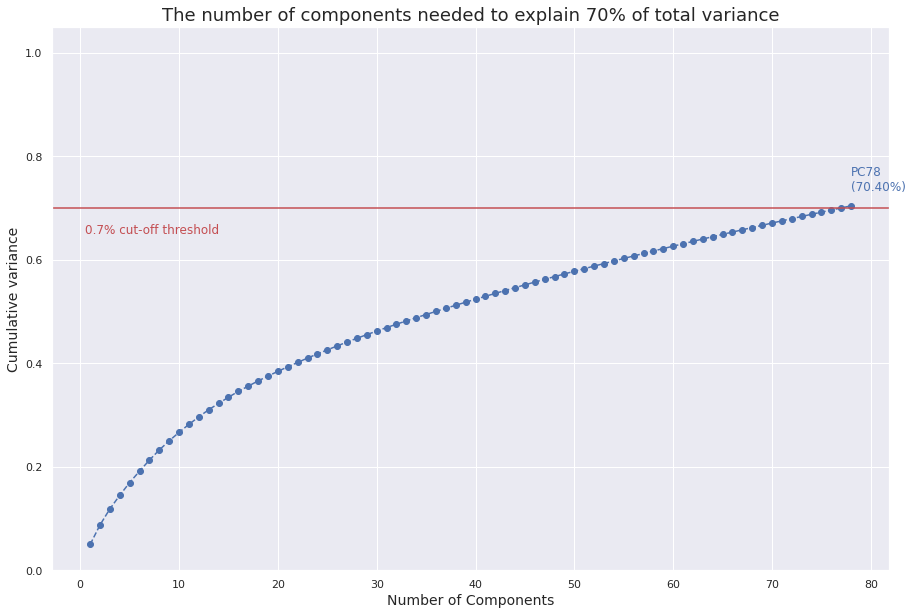

Initial number of dimension : 2124
Final number of dimension : 78


PC1        PC2        PC3       PC4       PC5        PC6  \
0    -9.345504  15.958617   0.113349  5.086288  8.595611 -10.006046   
1   -17.442590  19.724798  -8.652843  1.020953 -8.392677  -5.305960   
2    -6.668427   2.401983 -13.794926  3.886113  7.102612  -5.894922   
3    -8.480738  15.351893  -2.951185  3.332972 -7.415554 -12.124007   
4    13.748550  -3.645433  -8.808443 -2.828962  5.320109  -5.782799   
..         ...        ...        ...       ...       ...        ...   
181  -5.517009   4.172122   2.209346 -0.698499  2.484372   1.227413   
182   6.529379  -5.587020  -7.607925  3.918366  8.366482   5.965516   
183  -0.230550 -12.229755  -3.716462 -1.240285  3.542653   4.571418   
184   2.822459   3.992580   4.260498 -1.624888  1.422914   1.770044   
185  -5.558917 -12.258322  -0.260851 -3.019612  2.246743   5.568384   

           PC7        PC8        PC9       PC10  ...      PC69      PC70  \
0    -6.274736   9.735116   3.384241  -4.070413  ... -1.382003  4.100225   
1     5.590597  -0.235133  -4.382256   2.956007  ... -0.872133  1.309732   
2     3.107157   0.923708 -11.056591  10.349337  ... -0.463402 -3.258614   
3    -6.778348  -0.401368  -9.020305   5.337454  ...  3.383954 -3.877034   
4     4.209898  14.107975   0.196987   2.569879  ... -2.537448 -5.295594   
..         ...        ...        ...        ...  ...       ...       ...   
181 -11.844192  -6.296477  -2.200021 -13.641539  ... -2.899817  4.421886   
182  -8.803666  -3.165124   1.770881   1.816359  ...  2.389403  0.423293   
183  -5.289556  -0.378606  -2.728936  -2.160073  ... -1.167570 -0.066309   
184  -8.808413  -6.912591  -9.890913  -3.836818  ... -5.299592 -1.179582   
185   3.251020  -3.119523  -2.436941   3.392575  ... -7.052905  0.124877   

         PC71      PC72      PC73      PC74      PC75      PC76      PC77  \
0   -7.186832  2.778528 -0.942008  0.016219 -0.524718  0.459356 -6.946363   
1   -1.654587  5.612761  2.893818 -0.435315  1.377533 -6.331153 -1.634473   
2    2.893299  2.791538  0.316261 -0.760069  0.322430 -1.335326  2.976982   
3    0.877478  0.747970  0.691611  1.398727 -5.689021  1.130749 -1.466143   
4    0.964010  0.950651  1.633377  1.370839  3.281400 -1.043748 -0.475106   
..        ...       ...       ...       ...       ...       ...       ...   
181  0.931353 -1.009038  3.557673 -0.708864  1.365247 -1.422871 -1.500086   
182  0.957191 -3.666785  1.591987  1.140153 -2.148126 -1.821318  1.378319   
183  4.063846 -1.644573  0.291415  1.146821  1.015366 -0.174973 -1.057457   
184 -3.515643 -1.933861  0.473617 -0.745677  1.586634  0.245747 -4.131755   
185 -3.931713 -0.075261 -1.828122  0.901362  1.049590 -0.375069  1.151860   

         PC78  
0   -2.586568  
1    1.009198  
2    1.896145  
3    0.418122  
4    6.498776  
..        ...  
181  7.595707  
182  1.538233  
183  0.342399  
184 -0.579041  
185 -4.212729  

[186 rows x 78 columns]


 #################################################################################################### 

Time to compute t-SNE (input dataframe of shape (186, 78)) : 0.41 seconds

----------------------------------------------------------------------------------------------------


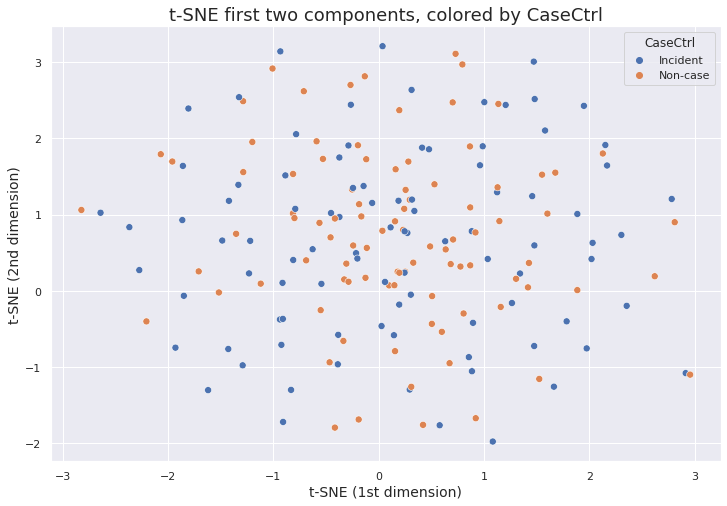

----------------------------------------------------------------------------------------------------


tSNE1     tSNE2
0   -0.932882  3.139906
1   -1.007151  2.915177
2    1.003122  2.474489
3    0.702541  2.471318
4    1.205461  2.437755
..        ...       ...
181 -0.117631  1.725816
182  0.245924  0.238697
183  0.196326  0.237841
184 -0.451676  1.020847
185 -0.415138  0.948713

[186 rows x 2 columns]

In [46]:
print(100 * '#', '\n')

matrix = peakTable_Agilent_imp_std.copy()
#matrix = matrix.drop(targets, axis=1)

peakTable_Agilent_imp_std_PCA, explained_variance = perform_PCA(matrix, part_explained_variance=0.70)
print(f'Initial number of dimension : {matrix.shape[1]}')
print(f'Final number of dimension : {explained_variance.shape[0]}')
display(peakTable_Agilent_imp_std_PCA)

print('\n', 100 * '#', '\n')

n_components = 2
peakTable_Agilent_imp_std_PCA_tSNE = perform_tSNE(peakTable_Agilent_imp_std_PCA, metadata_index, n_components=n_components, targets_plot=['CaseCtrl'])
display(peakTable_Agilent_imp_std_PCA_tSNE)

casectrl = pd.concat([metadata_index['CaseCtrl'], metadata[targets]], axis=1)

from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
casectrl['CaseCtrl'] = enc.fit_transform(casectrl['CaseCtrl'])

casectrl.corr()

## b - Feature selection keeping all features with ANOVA pvalue $\lt \alpha \hspace{0.39cm}$

In [47]:
matrix = peakTable_Agilent_imp_std.copy()
target = metadata_index['CaseCtrl']

peakTable_Agilent_imp_std_fs_anova, feature_scores = select_best_features(matrix, target, alpha=0.01)
print(f'Initial number of dimension : {matrix.shape[1]}')
print(f'Final number of dimension : {feature_scores.shape[0]}')
display(feature_scores)
display(peakTable_Agilent_imp_std_fs_anova)

Initial number of dimension : 2124
Final number of dimension : 371


/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 842 1253 1254 1255 1256 1257 1258 1259 1260 1261] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


features  f_scores  p_values
216                      l2Tca    85.596    0.0000
335                     ASTsc2    80.854    0.0000
209                      l2Gca    67.524    0.0000
220                    l2Tamca    66.605    0.0000
68    Glyceroph_Lysopc_A_C17_0    61.415    0.0000
...                        ...       ...       ...
342                       ggt1     6.875    0.0095
1679         785.0251@8.768451     6.866    0.0095
1673         793.0539@8.713688     6.854    0.0096
1675         801.0364@8.713365     6.828    0.0097
1961       281.9886@0.64297354     6.816    0.0098

[371 rows x 3 columns]

l2Tca  ASTsc2     l2Gca   l2Tamca  Glyceroph_Lysopc_A_C17_0    l2Tca2  \
0   -0.468504     1.0 -0.238263  0.653601                 -0.040850 -1.280393   
1   -0.335723     0.0 -0.619735 -0.207063                  1.265932 -0.039696   
2   -0.899592     1.0 -1.456966  0.104341                 -0.390149 -0.135483   
3   -0.239092     0.0  0.108900 -0.356088                  0.354044 -0.093405   
4    1.117223     1.0  0.884713  2.505444                 -1.189210  1.191783   
..        ...     ...       ...       ...                       ...       ...   
181 -0.179650     0.0  0.019692 -0.477533                  1.123740 -0.189622   
182  0.736917     0.0  0.742902  0.618480                 -1.055518  0.568044   
183 -0.511539     1.0 -0.249971 -0.794774                 -0.487520 -0.448722   
184 -0.014443     1.0 -0.086892 -0.861477                 -1.078702  0.177109   
185 -1.062194     0.0 -0.884990 -0.101045                  0.385728 -0.820652   

     l2tot_ba  GGTsc2  Sphingo_Sm_C18_1  onehotencoder__score22_0.0  ...  \
0    0.588432     1.0         -0.371781                         0.0  ...   
1   -0.569424     0.0          1.486047                         1.0  ...   
2   -1.492940     0.0          0.356102                         0.0  ...   
3   -0.331987     0.0          0.981094                         1.0  ...   
4    0.698518     1.0         -1.791138                         0.0  ...   
..        ...     ...               ...                         ...  ...   
181 -0.114600     0.0          0.165095                         1.0  ...   
182  0.706930     0.0         -0.528490                         1.0  ...   
183 -0.429295     0.0          0.542359                         0.0  ...   
184 -0.226387     1.0         -0.391040                         0.0  ...   
185 -1.016856     0.0          0.796155                         1.0  ...   

     412.2709@9.342098  429.7409@8.504203  265.0028@0.6442324  \
0            -4.368093           1.734889            0.522364   
1            -1.160704          -1.499918           -0.741957   
2            -0.253761          -1.499918            1.808088   
3             0.243056          -1.499918            0.524657   
4            -0.246098           0.302414            1.475573   
..                 ...                ...                 ...   
181           1.194082           0.114250           -1.066828   
182           0.101492           0.114731           -0.808078   
183          -0.958320          -1.499918           -0.074252   
184           0.723835           0.116384           -1.068356   
185          -1.751378           0.069222            0.808250   

     264.0173@2.40283  168.9785@0.6232213  ggt1  785.0251@8.768451  \
0            0.039271           -0.834819   0.0           2.202677   
1           -0.498069            0.732541   0.0           0.696459   
2           -0.789272            0.400802   0.0           1.774869   
3           -0.030951            0.805597   0.0           1.552757   
4           -0.709368           -1.217964   0.0           1.473216   
..                ...                 ...   ...                ...   
181         -1.083008            1.188032   0.0          -0.760369   
182          0.609007            0.854932   0.0          -1.083210   
183          0.148857            0.298820   0.0          -1.650959   
184         -0.256094            2.056954   0.0          -1.344630   
185         -1.083008           -0.761763   0.0          -2.070389   

     793.0539@8.713688  801.0364@8.713365  281.9886@0.64297354  
0            -0.215371           0.260106             1.890256  
1            -0.266564          -0.377201             0.694952  
2            -0.203366          -0.544552             1.959544  
3            -1.268349          -1.053377             1.383565  
4            -0.344399          -0.899292             2.597259  
..                 ...                ...                  ...  
181           1.004895           1.813205    

## c - Feature selection keeping a specific number of features

### Keeping 50 features

In [48]:
matrix = peakTable_Agilent_imp_std.copy()
target = metadata_index['CaseCtrl']

peakTable_Agilent_imp_std_fs_nb_50, feature_scores = select_best_features(matrix, target, k=50)
print(f'Initial number of dimension : {matrix.shape[1]}')
print(f'Final number of dimension : {feature_scores.shape[0]}')
display(feature_scores)
display(peakTable_Agilent_imp_std_fs_nb_50)

Initial number of dimension : 2124
Final number of dimension : 50


/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 842 1253 1254 1255 1256 1257 1258 1259 1260 1261] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


features  f_scores  p_values
216                            l2Tca    85.596       0.0
335                           ASTsc2    80.854       0.0
209                            l2Gca    67.524       0.0
220                          l2Tamca    66.605       0.0
68          Glyceroph_Lysopc_A_C17_0    61.415       0.0
262                           l2Tca2    56.548       0.0
229                         l2tot_ba    56.143       0.0
336                           GGTsc2    55.993       0.0
155                 Sphingo_Sm_C18_1    55.604       0.0
835       onehotencoder__score22_0.0    54.039       0.0
322                             ast6    50.569       0.0
73          Glyceroph_Lysopc_A_C20_4    50.245       0.0
290                              fr2    49.184       0.0
219                          l2Tudca    47.930       0.0
218                           l2Thca    46.957       0.0
150              Sphingo_Sm_Oh_C22_2    46.896       0.0
1611               509.3478@7.160705    46.739       0.0
154                 Sphingo_Sm_C18_0    45.457       0.0
210                          l2Gcdca    45.127       0.0
245                             Tca2    43.272       0.0
212                           l2Ghca    43.156       0.0
841   onehotencoder__score22_cat_2.0    41.688       0.0
246                           Tcdca2    41.365       0.0
1827               550.807@6.9407544    41.129       0.0
234                        l2tot_hca    40.301       0.0
148              Sphingo_Sm_Oh_C16_1    39.902       0.0
217                           l2Tdca    39.696       0.0
281                     l2unconj_ba2    39.068       0.0
340                            HepBC    38.123       0.0
1832               531.3298@7.163808    37.978       0.0
1562              430.3096@6.8488145    37.733       0.0
1761                291.1406@6.93256    36.166       0.0
149              Sphingo_Sm_Oh_C22_1    35.906       0.0
838       onehotencoder__score22_3.0    35.701       0.0
238                             Gca2    34.053       0.0
254                           l2Dca2    33.792       0.0
323                             alp6    33.640       0.0
278                        l2sec_ba2    33.277       0.0
1399              118.0417@0.8720219    32.968       0.0
263                         l2Tcdca2    32.679       0.0
1573               543.3341@6.937076    32.455       0.0
1575                550.305@6.941093    32.350       0.0
1571              565.3143@6.9316244    32.213       0.0
1762              558.2919@6.9406734    32.029       0.0
321                             alt6    31.983       0.0
289                               fr    30.663       0.0
292                       prim_conj2    30.628       0.0
255                           l2Gca2    30.374       0.0
1407              122.0382@0.8622741    29.635       0.0
1920              534.2542@6.4795027    29.393       0.0

l2Tca  ASTsc2     l2Gca   l2Tamca  Glyceroph_Lysopc_A_C17_0    l2Tca2  \
0   -0.468504     1.0 -0.238263  0.653601                 -0.040850 -1.280393   
1   -0.335723     0.0 -0.619735 -0.207063                  1.265932 -0.039696   
2   -0.899592     1.0 -1.456966  0.104341                 -0.390149 -0.135483   
3   -0.239092     0.0  0.108900 -0.356088                  0.354044 -0.093405   
4    1.117223     1.0  0.884713  2.505444                 -1.189210  1.191783   
..        ...     ...       ...       ...                       ...       ...   
181 -0.179650     0.0  0.019692 -0.477533                  1.123740 -0.189622   
182  0.736917     0.0  0.742902  0.618480                 -1.055518  0.568044   
183 -0.511539     1.0 -0.249971 -0.794774                 -0.487520 -0.448722   
184 -0.014443     1.0 -0.086892 -0.861477                 -1.078702  0.177109   
185 -1.062194     0.0 -0.884990 -0.101045                  0.385728 -0.820652   

     l2tot_ba  GGTsc2  Sphingo_Sm_C18_1  onehotencoder__score22_0.0  ...  \
0    0.588432     1.0         -0.371781                         0.0  ...   
1   -0.569424     0.0          1.486047                         1.0  ...   
2   -1.492940     0.0          0.356102                         0.0  ...   
3   -0.331987     0.0          0.981094                         1.0  ...   
4    0.698518     1.0         -1.791138                         0.0  ...   
..        ...     ...               ...                         ...  ...   
181 -0.114600     0.0          0.165095                         1.0  ...   
182  0.706930     0.0         -0.528490                         1.0  ...   
183 -0.429295     0.0          0.542359                         0.0  ...   
184 -0.226387     1.0         -0.391040                         0.0  ...   
185 -1.016856     0.0          0.796155                         1.0  ...   

     543.3341@6.937076  550.305@6.941093  565.3143@6.9316244  \
0             0.016019          0.255443           -0.310724   
1             0.884865          1.686789            0.148824   
2            -0.972619         -1.104387           -1.136236   
3            -0.649068         -0.335092           -1.040184   
4            -1.579067         -2.063501           -1.521710   
..                 ...               ...                 ...   
181           1.311266          1.165278            1.941424   
182          -0.342378          0.164298            0.010082   
183          -0.199469         -0.019847            0.302674   
184           0.105772         -2.223266            0.842231   
185           1.816254         -0.662846            2.687960   

     558.2919@6.9406734      alt6        fr  prim_conj2    l2Gca2  \
0              1.367630  0.794356  1.120415   -1.658370 -1.572723   
1              2.785271 -0.591906  0.746481   -0.137763 -0.465611   
2             -0.435936  0.466962 -0.236815   -1.089497 -0.828344   
3              0.025180 -0.545599  0.459977   -0.268857  0.827648   
4             -1.377567  1.232061 -0.642350    0.809528  0.862128   
..                  ...       ...       ...         ...       ...   
181            0.069982 -0.503422  4.494785    0.196017  0.243860   
182           -0.678265 -0.676852 -0.433742    0.245488  0.516130   
183           -0.664993  1.399297 -0.246311   -0.676219  0.156790   
184           -0.689856 -0.059523  0.715749    0.193324  0.187703   
185            0.355252 -0.326452  1.092976   -0.329475 -0.313236   

     122.0382@0.8622741  534.2542@6.4795027  
0             -1.727168           -0.082302  
1              0.055805           -0.336115  
2             -1.727168           -0.855733  
3              0.036583            0.068805  
4              1.539691            0.796009  
..                  ...                 ...  
181           -0.032382           -0.068051  
182            0.935188            0.508394  
183            0.447742           -0.507207  
184            0.679325           -0.006792  
185            0.1

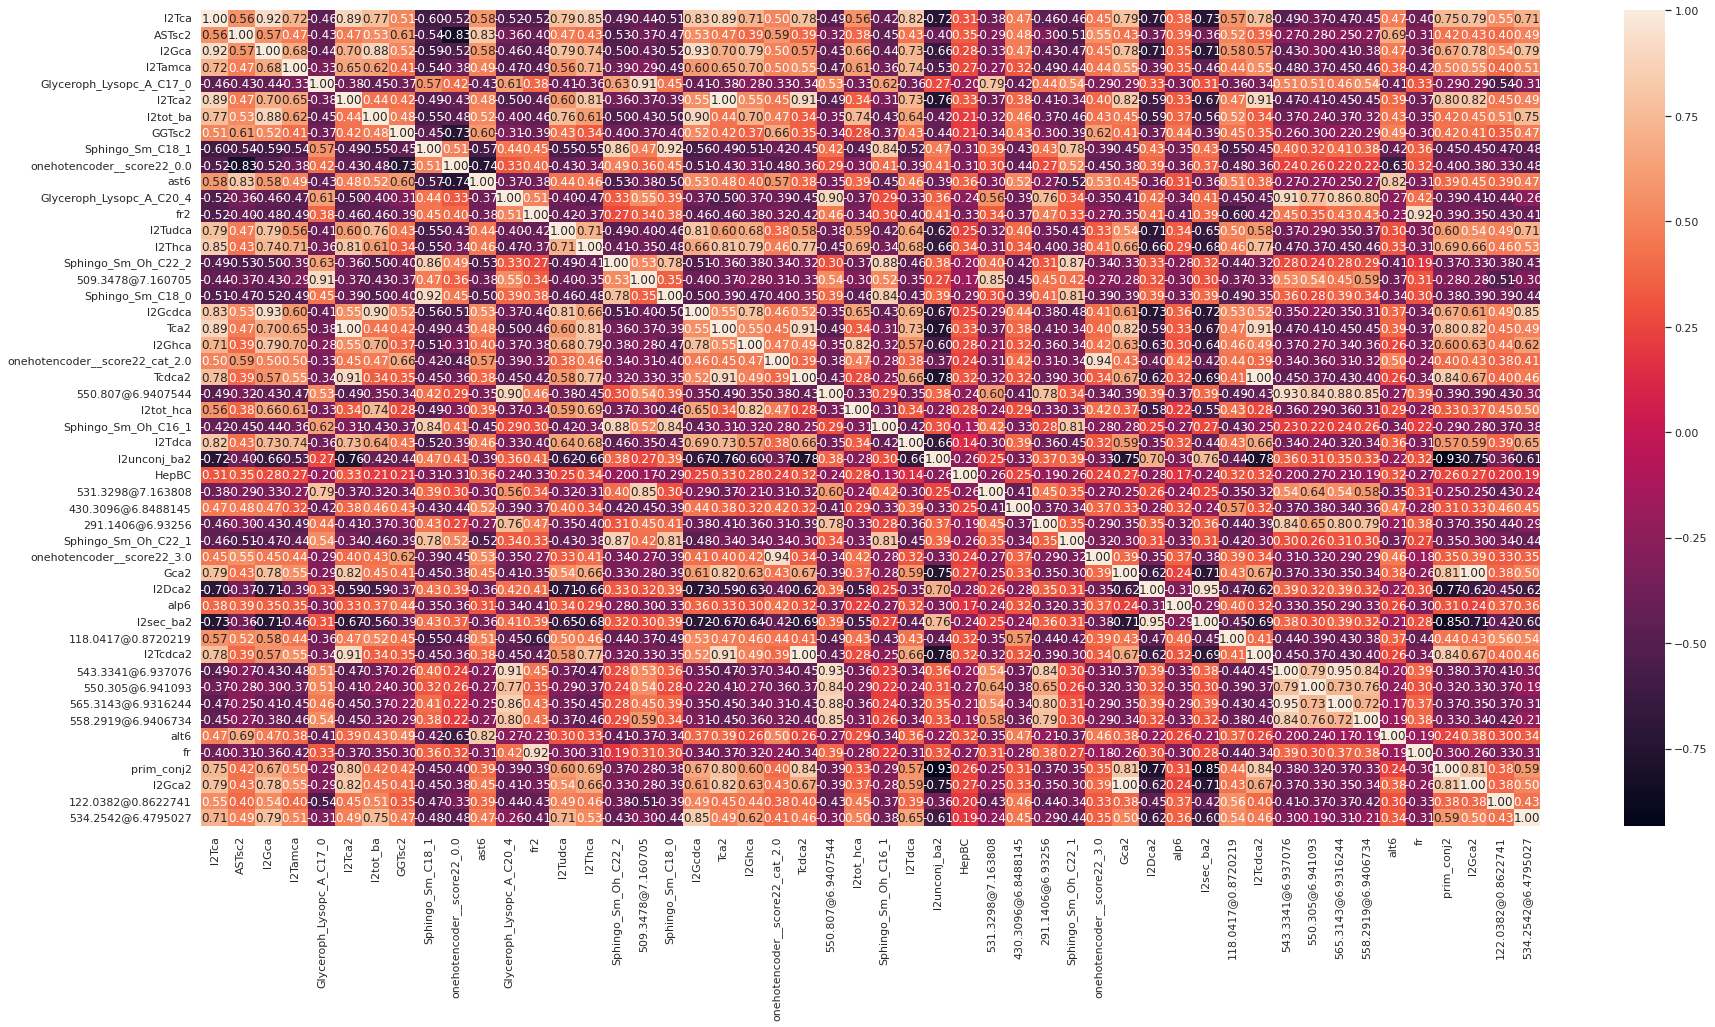

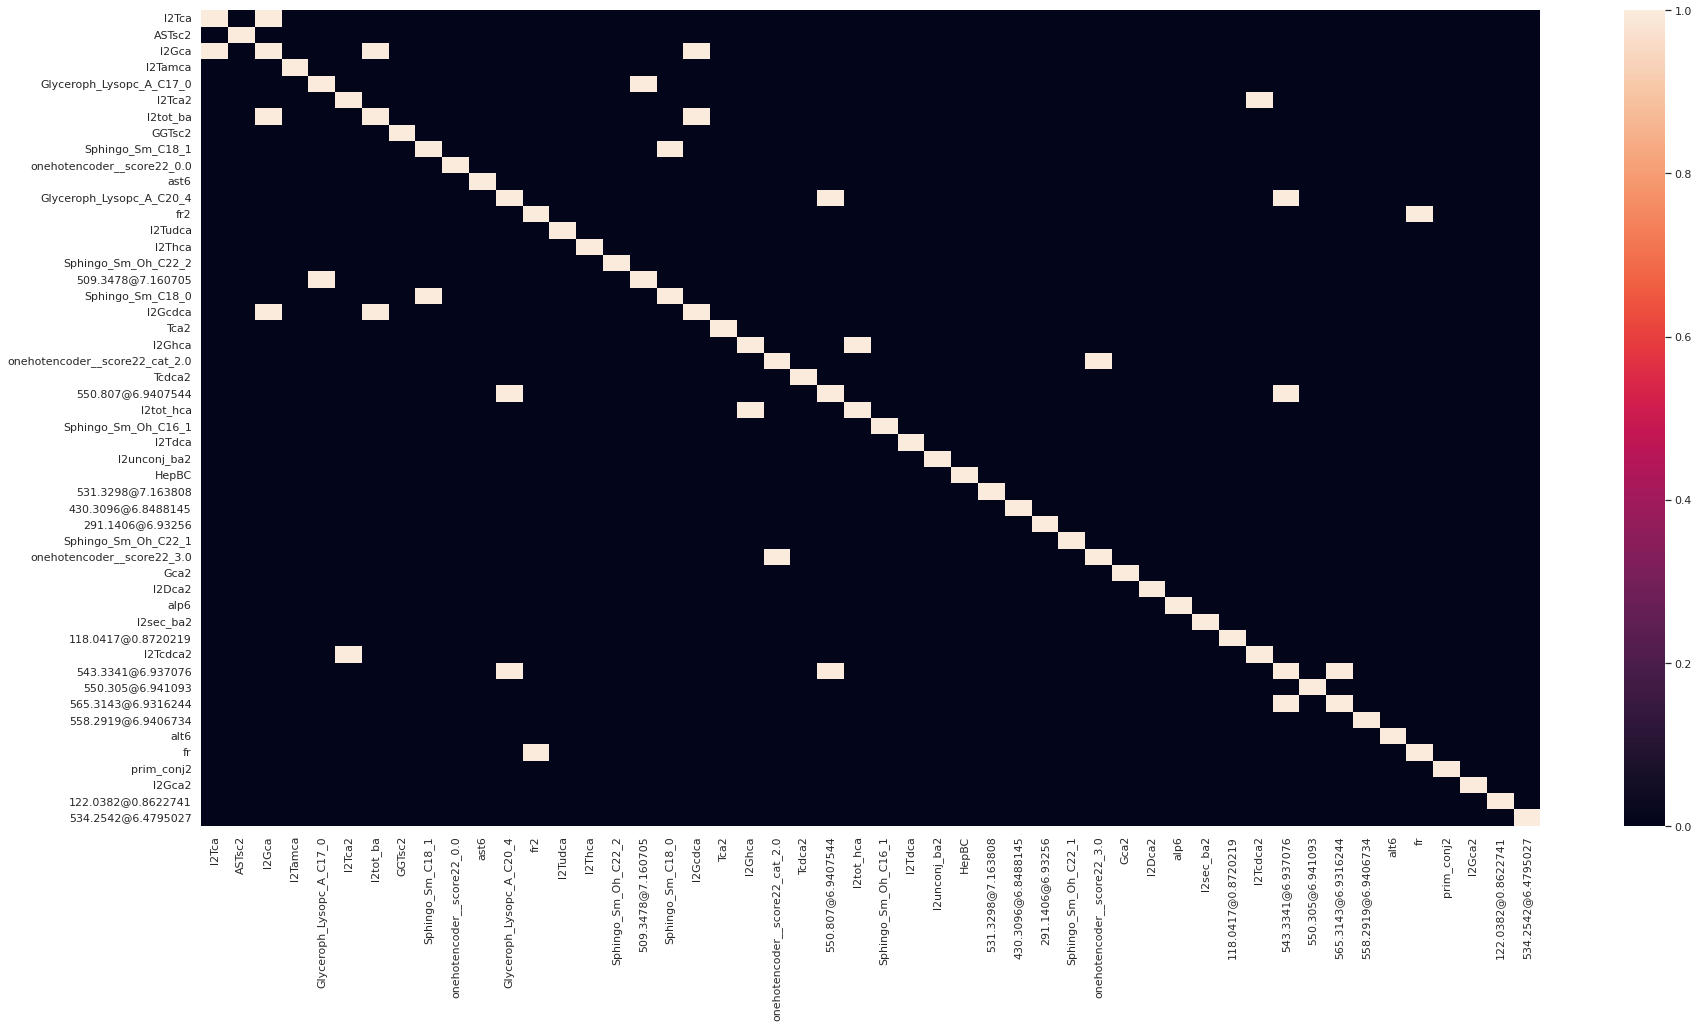

In [49]:
matrix = pd.concat([target, peakTable_Agilent_imp_std_fs_nb_50], axis=1)

plt.figure(figsize=(30,15))
sns.heatmap(matrix.corr(method='spearman'), annot=True, fmt='.2f')
plt.show()

plt.figure(figsize=(30,15))
sns.heatmap((matrix.corr(method='pearson') > 0.9) | (matrix.corr(method='pearson') < -0.9))
plt.show()

### Keeping 10 features

In [50]:
matrix = peakTable_Agilent_imp_std.copy()
target = metadata_index['CaseCtrl']

peakTable_Agilent_imp_std_fs_nb_10, feature_scores = select_best_features(matrix, target, k=10)
print(f'Initial number of dimension : {matrix.shape[1]}')
print(f'Final number of dimension : {feature_scores.shape[0]}')
display(feature_scores)
display(peakTable_Agilent_imp_std_fs_nb_10)

Initial number of dimension : 2124
Final number of dimension : 10


/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 842 1253 1254 1255 1256 1257 1258 1259 1260 1261] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


features  f_scores  p_values
216                       l2Tca    85.596       0.0
335                      ASTsc2    80.854       0.0
209                       l2Gca    67.524       0.0
220                     l2Tamca    66.605       0.0
68     Glyceroph_Lysopc_A_C17_0    61.415       0.0
262                      l2Tca2    56.548       0.0
229                    l2tot_ba    56.143       0.0
336                      GGTsc2    55.993       0.0
155            Sphingo_Sm_C18_1    55.604       0.0
835  onehotencoder__score22_0.0    54.039       0.0

l2Tca  ASTsc2     l2Gca   l2Tamca  Glyceroph_Lysopc_A_C17_0    l2Tca2  \
0   -0.468504     1.0 -0.238263  0.653601                 -0.040850 -1.280393   
1   -0.335723     0.0 -0.619735 -0.207063                  1.265932 -0.039696   
2   -0.899592     1.0 -1.456966  0.104341                 -0.390149 -0.135483   
3   -0.239092     0.0  0.108900 -0.356088                  0.354044 -0.093405   
4    1.117223     1.0  0.884713  2.505444                 -1.189210  1.191783   
..        ...     ...       ...       ...                       ...       ...   
181 -0.179650     0.0  0.019692 -0.477533                  1.123740 -0.189622   
182  0.736917     0.0  0.742902  0.618480                 -1.055518  0.568044   
183 -0.511539     1.0 -0.249971 -0.794774                 -0.487520 -0.448722   
184 -0.014443     1.0 -0.086892 -0.861477                 -1.078702  0.177109   
185 -1.062194     0.0 -0.884990 -0.101045                  0.385728 -0.820652   

     l2tot_ba  GGTsc2  Sphingo_Sm_C18_1  onehotencoder__score22_0.0  
0    0.588432     1.0         -0.371781                         0.0  
1   -0.569424     0.0          1.486047                         1.0  
2   -1.492940     0.0          0.356102                         0.0  
3   -0.331987     0.0          0.981094                         1.0  
4    0.698518     1.0         -1.791138                         0.0  
..        ...     ...               ...                         ...  
181 -0.114600     0.0          0.165095                         1.0  
182  0.706930     0.0         -0.528490                         1.0  
183 -0.429295     0.0          0.542359                         0.0  
184 -0.226387     1.0         -0.391040                         0.0  
185 -1.016856     0.0          0.796155                         1.0  

[186 rows x 10 columns]

### Keeping 5 features

In [51]:
matrix = peakTable_Agilent_imp_std.copy()
target = metadata_index['CaseCtrl']

peakTable_Agilent_imp_std_fs_nb_5, feature_scores = select_best_features(matrix, target, k=5)
print(f'Initial number of dimension : {matrix.shape[1]}')
print(f'Final number of dimension : {feature_scores.shape[0]}')
display(feature_scores)
display(peakTable_Agilent_imp_std_fs_nb_5)

Initial number of dimension : 2124
Final number of dimension : 5


/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 842 1253 1254 1255 1256 1257 1258 1259 1260 1261] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


features  f_scores  p_values
216                     l2Tca    85.596       0.0
335                    ASTsc2    80.854       0.0
209                     l2Gca    67.524       0.0
220                   l2Tamca    66.605       0.0
68   Glyceroph_Lysopc_A_C17_0    61.415       0.0

l2Tca  ASTsc2     l2Gca   l2Tamca  Glyceroph_Lysopc_A_C17_0
0   -0.468504     1.0 -0.238263  0.653601                 -0.040850
1   -0.335723     0.0 -0.619735 -0.207063                  1.265932
2   -0.899592     1.0 -1.456966  0.104341                 -0.390149
3   -0.239092     0.0  0.108900 -0.356088                  0.354044
4    1.117223     1.0  0.884713  2.505444                 -1.189210
..        ...     ...       ...       ...                       ...
181 -0.179650     0.0  0.019692 -0.477533                  1.123740
182  0.736917     0.0  0.742902  0.618480                 -1.055518
183 -0.511539     1.0 -0.249971 -0.794774                 -0.487520
184 -0.014443     1.0 -0.086892 -0.861477                 -1.078702
185 -1.062194     0.0 -0.884990 -0.101045                  0.385728

[186 rows x 5 columns]

### Keeping 1 feature

In [52]:
matrix = peakTable_Agilent_imp_std.copy()
target = metadata_index['CaseCtrl']

peakTable_Agilent_imp_std_fs_nb_1, feature_scores = select_best_features(matrix, target, k=1)
print(f'Initial number of dimension : {matrix.shape[1]}')
print(f'Final number of dimension : {feature_scores.shape[0]}')
display(feature_scores)
display(peakTable_Agilent_imp_std_fs_nb_1)

Initial number of dimension : 2124
Final number of dimension : 1


/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 842 1253 1254 1255 1256 1257 1258 1259 1260 1261] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


features  f_scores  p_values
216    l2Tca    85.596       0.0

l2Tca
0   -0.468504
1   -0.335723
2   -0.899592
3   -0.239092
4    1.117223
..        ...
181 -0.179650
182  0.736917
183 -0.511539
184 -0.014443
185 -1.062194

[186 rows x 1 columns]

#### For further analysis, we have the following reduced dataframes :
- <code>peakTable_Agilent_imp_std_PCA</code> : reduced peak table with PCA keeping 95% of initial explained variance
- <code>peakTable_Agilent_imp_std_PCA_tSNE</code> : reduced peak table with PCA as before + t-SNE reduction to keep only 2 components
- <code>peakTable_Agilent_imp_std_fs_anova</code> : reduced peak table by keeping all features with ANOVA pvalue $\lt \alpha \hspace{0.39cm}$
- <code>peakTable_Agilent_imp_std_fs_nb</code> : reduced peak table by keeping a specific number of features

# 6 - Classification

In [53]:
from classification_functions import *

In [54]:
from sklearn.linear_model import RidgeClassifier, LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

## a - Launch pipeline with differently preprocessed dataframes

### At this point, here are the dataframes we have :
- <code>peakTable_Agilent_imp_std</code>
- <code>peakTable_Agilent_imp_std_PCA</code>
- <code>peakTable_Agilent_imp_std_fs_nb_1</code>
- <code>peakTable_Agilent_imp_std_fs_nb_5</code>
- <code>peakTable_Agilent_imp_std_fs_nb_10</code>
- <code>peakTable_Agilent_imp_std_fs_nb_50</code>
- <code>peakTable_Agilent_imp_std_fs_nb_anova</code>

In [55]:
targets

['onehotencoder__Case_HCC_Wide_No',
 'onehotencoder__Case_HCC_Wide_Yes',
 'onehotencoder__Case_HCC_No',
 'onehotencoder__Case_HCC_Yes',
 'onehotencoder__CaseCtrl_Incident',
 'onehotencoder__CaseCtrl_Non-case',
 'onehotencoder__Cncr_Caco_Live_Case',
 'onehotencoder__Cncr_Caco_Live_Control']

### Classification pipeline on <code>peakTable_Agilent_imp_std_fs_nb_5</code>

#################################################################-----------------###################################################################
################################################################| RidgeClassifier |##################################################################
#################################################################-----------------###################################################################

Corresponding classes to labels : {'Incident': 0, 'Non-case': 1}

Confusion matrix :


Incident  Non-case
true/pred                    
Incident         13        11
Non-case          3        20


Classification report :


precision  recall  f1-score  support
Incident           0.81    0.54      0.65    24.00
Non-case           0.65    0.87      0.74    23.00
accuracy           0.70    0.70      0.70     0.70
macro avg          0.73    0.71      0.70    47.00
weighted avg       0.73    0.70      0.69    47.00

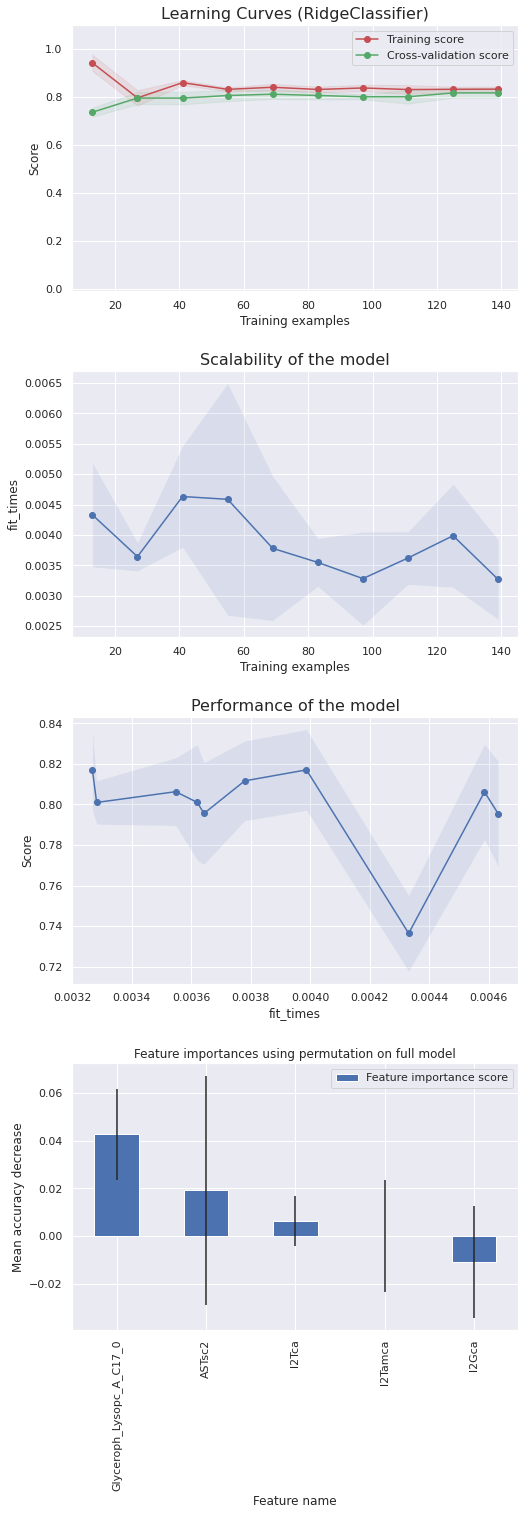




################################################################--------------------#################################################################
###############################################################| LogisticRegression |################################################################
################################################################--------------------#################################################################

Corresponding classes to labels : {'Incident': 0, 'Non-case': 1}

Confusion matrix :


Incident  Non-case
true/pred                    
Incident         17         7
Non-case          4        19


Classification report :


precision  recall  f1-score  support
Incident           0.81    0.71      0.76    24.00
Non-case           0.73    0.83      0.78    23.00
accuracy           0.77    0.77      0.77     0.77
macro avg          0.77    0.77      0.77    47.00
weighted avg       0.77    0.77      0.77    47.00

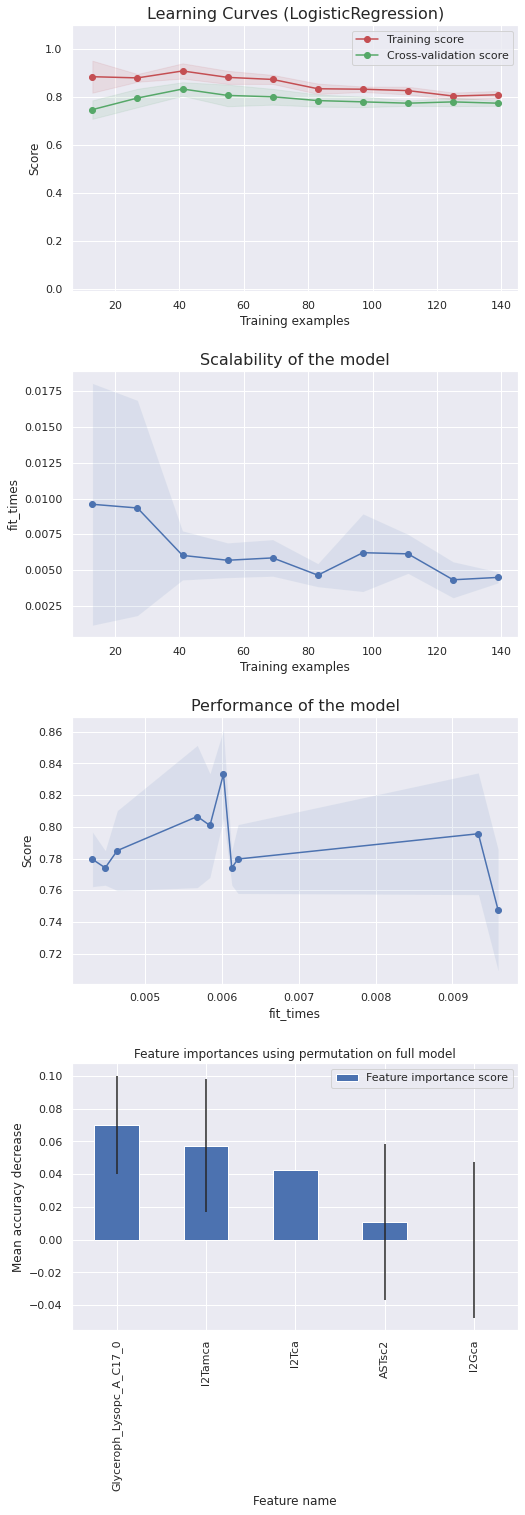




############################################################----------------------------#############################################################
###########################################################| LinearDiscriminantAnalysis |############################################################
############################################################----------------------------#############################################################

Corresponding classes to labels : {'Incident': 0, 'Non-case': 1}

Confusion matrix :


Incident  Non-case
true/pred                    
Incident         13        11
Non-case          3        20


Classification report :


precision  recall  f1-score  support
Incident           0.81    0.54      0.65    24.00
Non-case           0.65    0.87      0.74    23.00
accuracy           0.70    0.70      0.70     0.70
macro avg          0.73    0.71      0.70    47.00
weighted avg       0.73    0.70      0.69    47.00

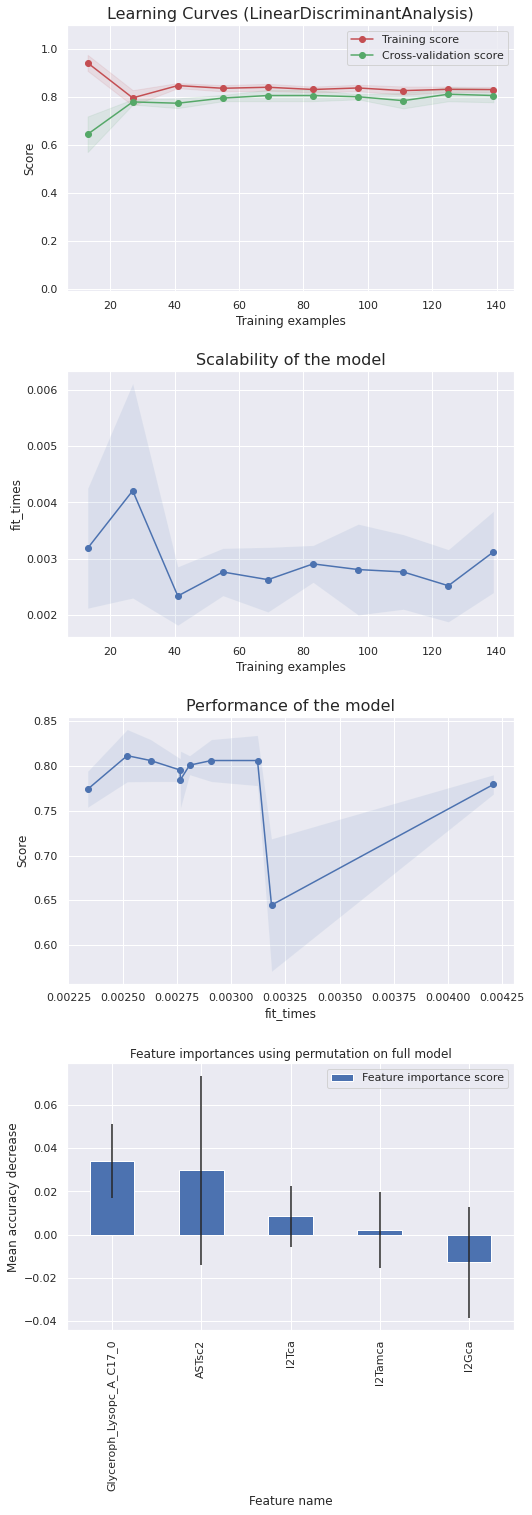




#######################################################################-----#########################################################################
######################################################################| SVC |########################################################################
#######################################################################-----#########################################################################

Corresponding classes to labels : {'Incident': 0, 'Non-case': 1}

Confusion matrix :


Incident  Non-case
true/pred                    
Incident         14        10
Non-case          2        21


Classification report :


precision  recall  f1-score  support
Incident           0.88    0.58      0.70    24.00
Non-case           0.68    0.91      0.78    23.00
accuracy           0.74    0.74      0.74     0.74
macro avg          0.78    0.75      0.74    47.00
weighted avg       0.78    0.74      0.74    47.00

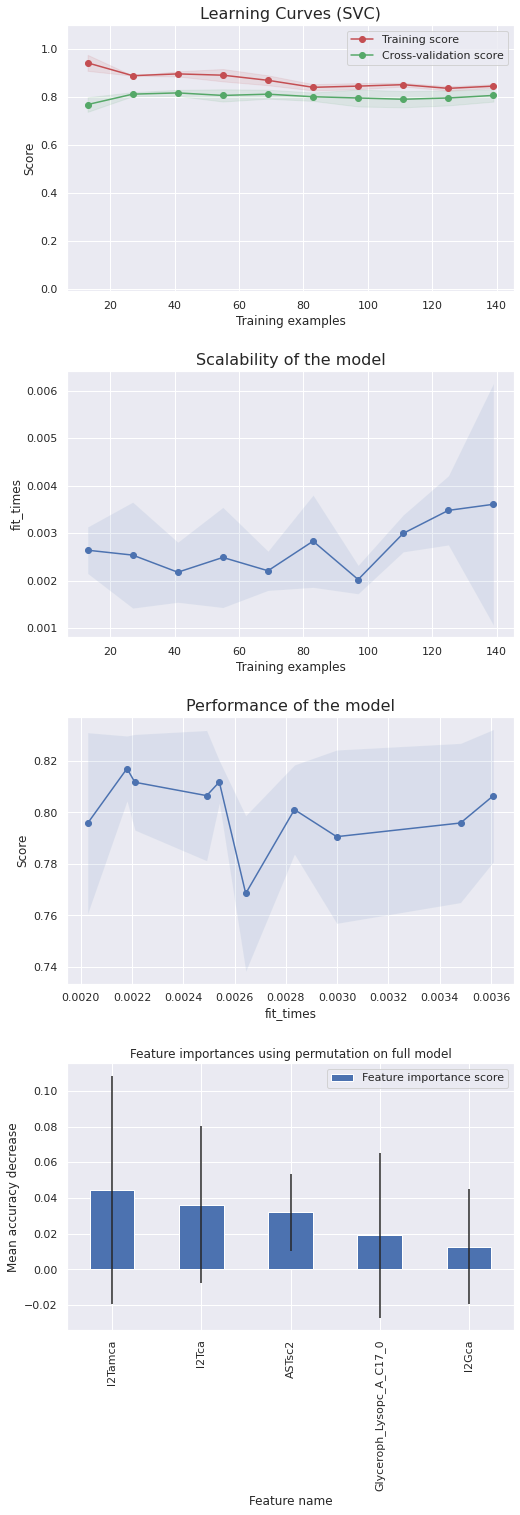




##################################################################---------------####################################################################
#################################################################| SGDClassifier |###################################################################
##################################################################---------------####################################################################

Corresponding classes to labels : {'Incident': 0, 'Non-case': 1}

Confusion matrix :


Incident  Non-case
true/pred                    
Incident         16         8
Non-case          3        20


Classification report :


precision  recall  f1-score  support
Incident           0.84    0.67      0.74    24.00
Non-case           0.71    0.87      0.78    23.00
accuracy           0.77    0.77      0.77     0.77
macro avg          0.78    0.77      0.76    47.00
weighted avg       0.78    0.77      0.76    47.00

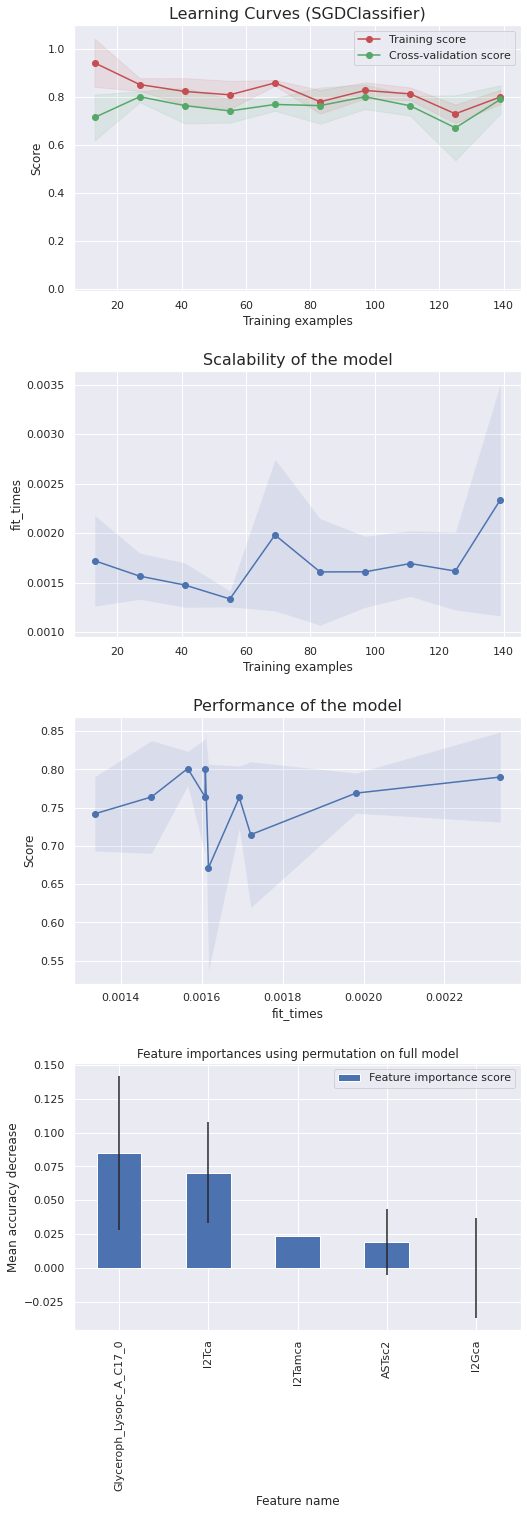




###############################################################----------------------################################################################
##############################################################| KNeighborsClassifier |###############################################################
###############################################################----------------------################################################################

Corresponding classes to labels : {'Incident': 0, 'Non-case': 1}

Confusion matrix :


Incident  Non-case
true/pred                    
Incident         15         9
Non-case          5        18


Classification report :


precision  recall  f1-score  support
Incident           0.75    0.62      0.68    24.00
Non-case           0.67    0.78      0.72    23.00
accuracy           0.70    0.70      0.70     0.70
macro avg          0.71    0.70      0.70    47.00
weighted avg       0.71    0.70      0.70    47.00

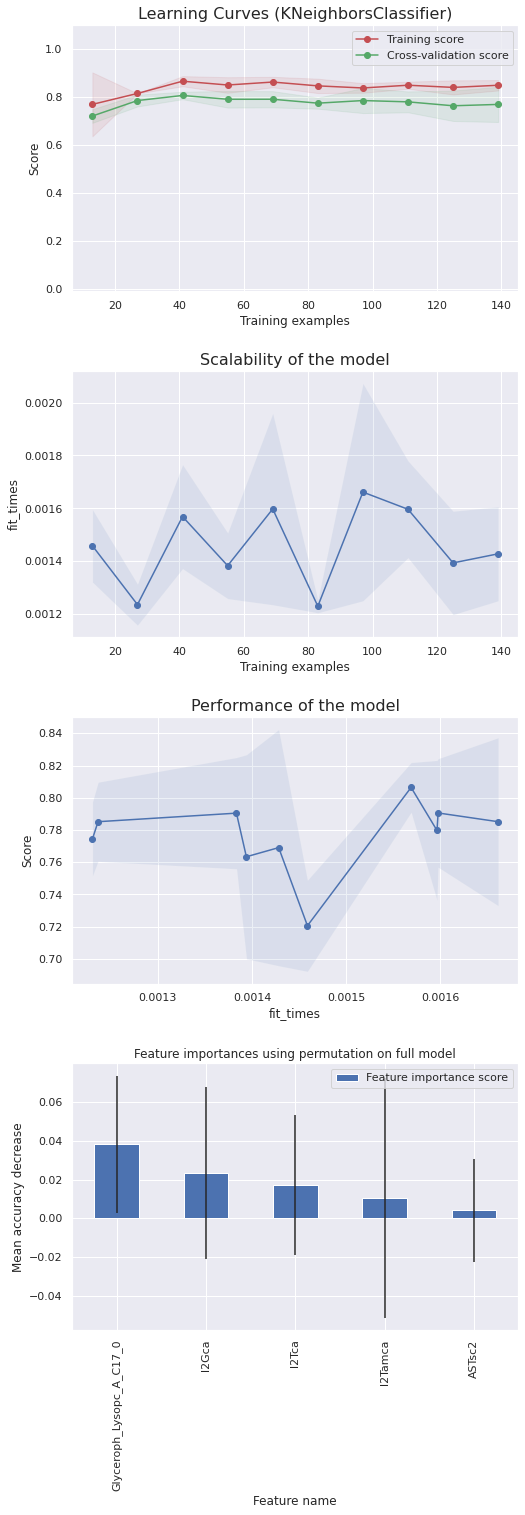




#################################################################-----------------###################################################################
################################################################| NearestCentroid |##################################################################
#################################################################-----------------###################################################################

Corresponding classes to labels : {'Incident': 0, 'Non-case': 1}

Confusion matrix :


Incident  Non-case
true/pred                    
Incident         17         7
Non-case          3        20


Classification report :


precision  recall  f1-score  support
Incident           0.85    0.71      0.77    24.00
Non-case           0.74    0.87      0.80    23.00
accuracy           0.79    0.79      0.79     0.79
macro avg          0.80    0.79      0.79    47.00
weighted avg       0.80    0.79      0.79    47.00

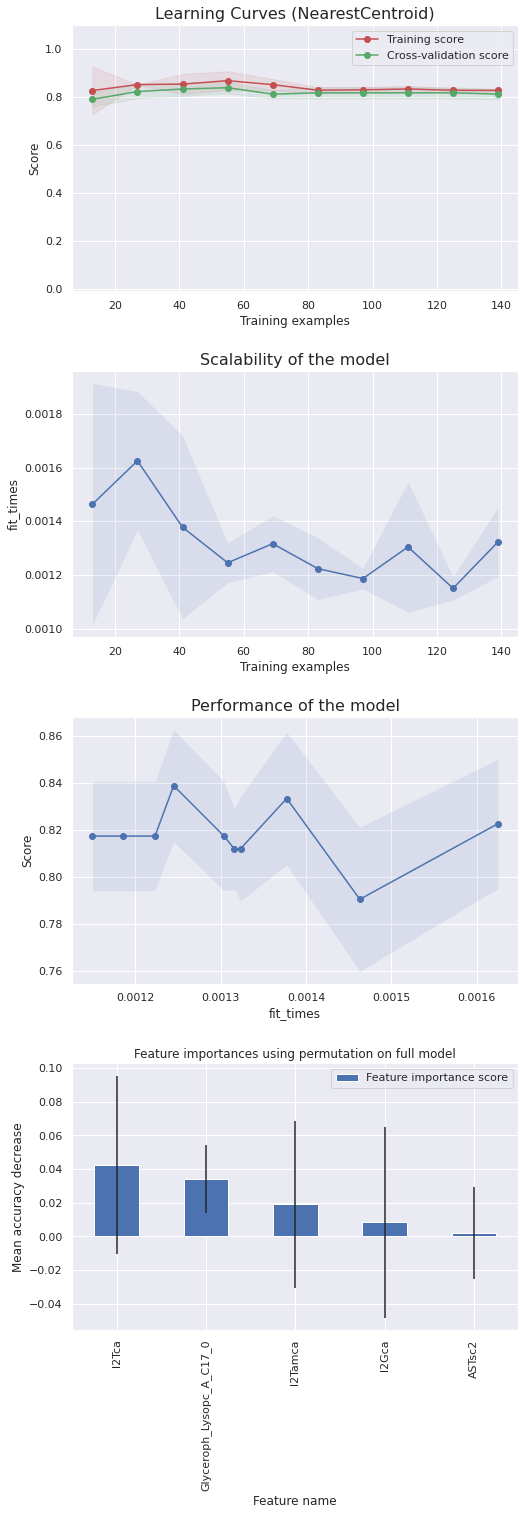




############################################################---------------------------##############################################################
###########################################################| GaussianProcessClassifier |#############################################################
############################################################---------------------------##############################################################

Corresponding classes to labels : {'Incident': 0, 'Non-case': 1}

Confusion matrix :


Incident  Non-case
true/pred                    
Incident         16         8
Non-case          4        19


Classification report :


precision  recall  f1-score  support
Incident           0.80    0.67      0.73    24.00
Non-case           0.70    0.83      0.76    23.00
accuracy           0.74    0.74      0.74     0.74
macro avg          0.75    0.75      0.74    47.00
weighted avg       0.75    0.74      0.74    47.00

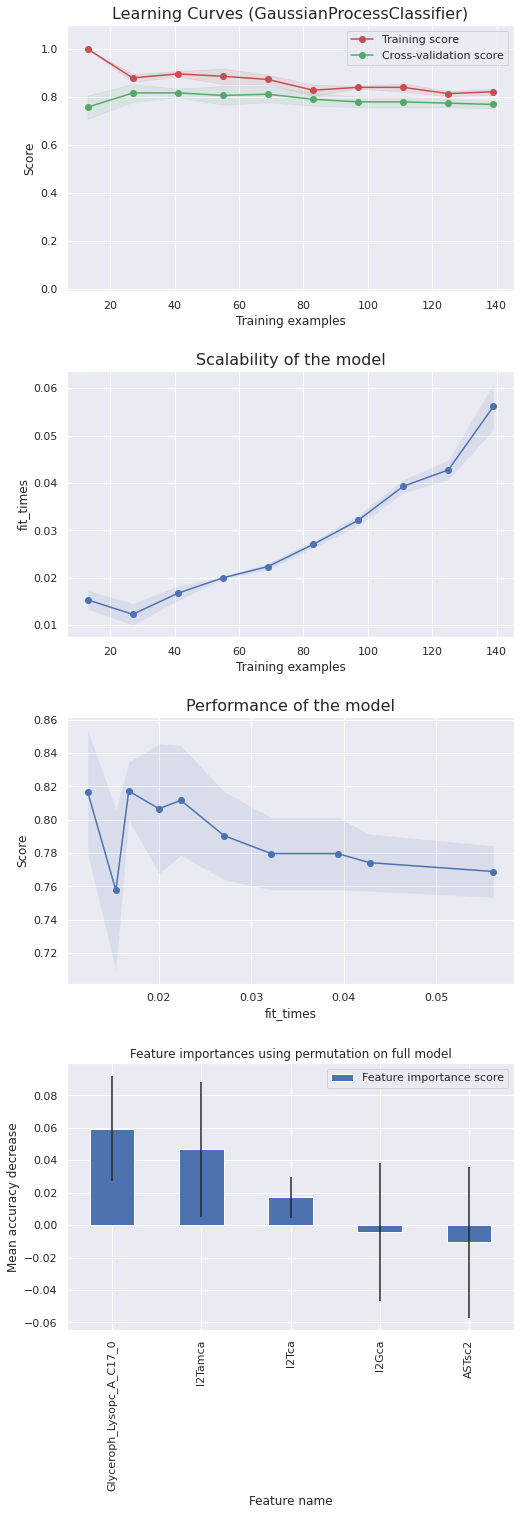




####################################################################------------#####################################################################
###################################################################| GaussianNB |####################################################################
####################################################################------------#####################################################################

Corresponding classes to labels : {'Incident': 0, 'Non-case': 1}

Confusion matrix :


Incident  Non-case
true/pred                    
Incident         14        10
Non-case          4        19


Classification report :


precision  recall  f1-score  support
Incident           0.78    0.58      0.67    24.00
Non-case           0.66    0.83      0.73    23.00
accuracy           0.70    0.70      0.70     0.70
macro avg          0.72    0.70      0.70    47.00
weighted avg       0.72    0.70      0.70    47.00

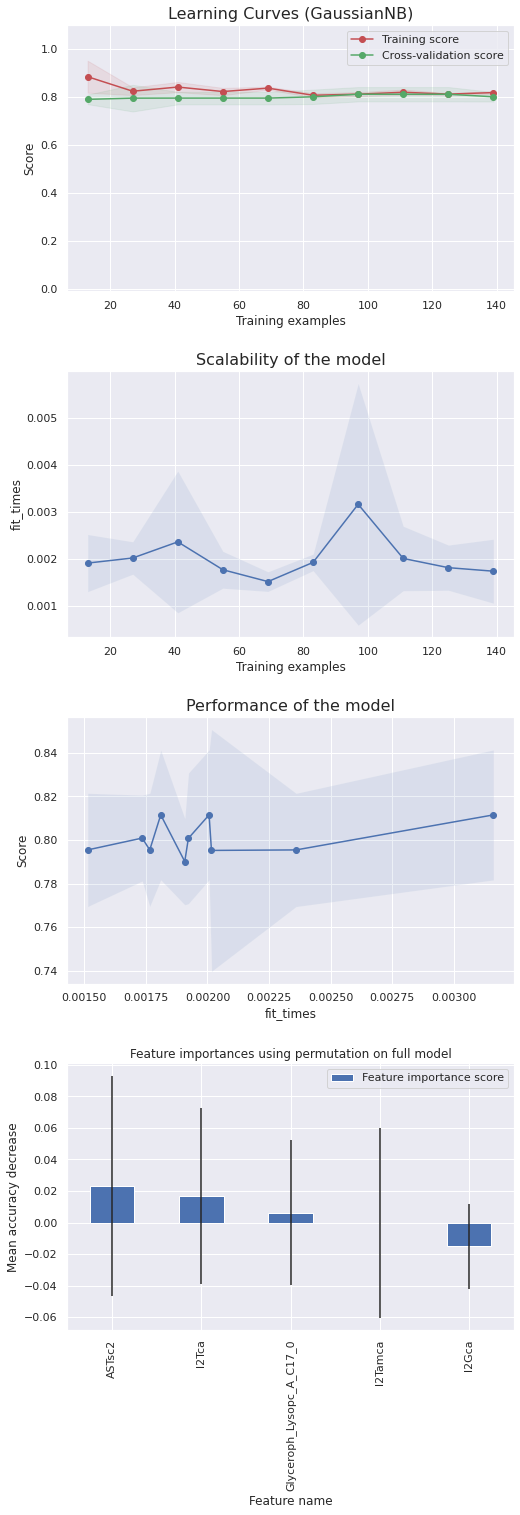




##############################################################------------------------###############################################################
#############################################################| DecisionTreeClassifier |##############################################################
##############################################################------------------------###############################################################

Corresponding classes to labels : {'Incident': 0, 'Non-case': 1}

Confusion matrix :


Incident  Non-case
true/pred                    
Incident         16         8
Non-case          9        14


Classification report :


precision  recall  f1-score  support
Incident           0.64    0.67      0.65    24.00
Non-case           0.64    0.61      0.62    23.00
accuracy           0.64    0.64      0.64     0.64
macro avg          0.64    0.64      0.64    47.00
weighted avg       0.64    0.64      0.64    47.00

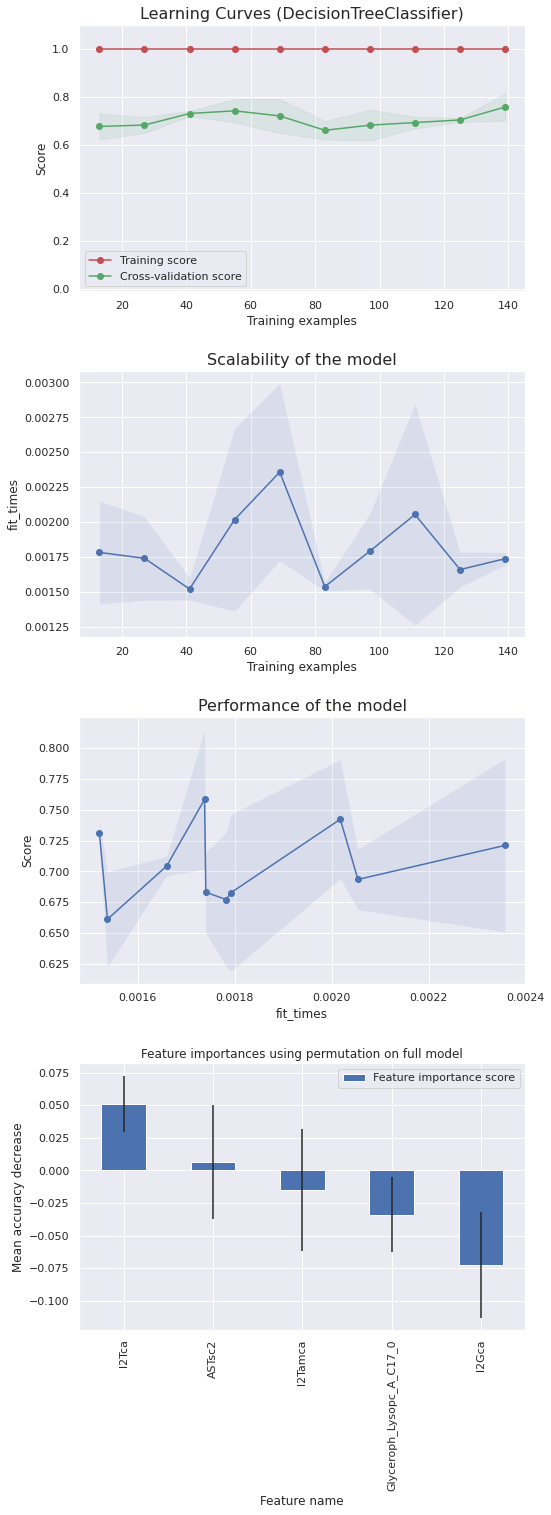




##############################################################------------------------###############################################################
#############################################################| RandomForestClassifier |##############################################################
##############################################################------------------------###############################################################

Corresponding classes to labels : {'Incident': 0, 'Non-case': 1}

Confusion matrix :


Incident  Non-case
true/pred                    
Incident         18         6
Non-case          4        19


Classification report :


precision  recall  f1-score  support
Incident           0.82    0.75      0.78    24.00
Non-case           0.76    0.83      0.79    23.00
accuracy           0.79    0.79      0.79     0.79
macro avg          0.79    0.79      0.79    47.00
weighted avg       0.79    0.79      0.79    47.00

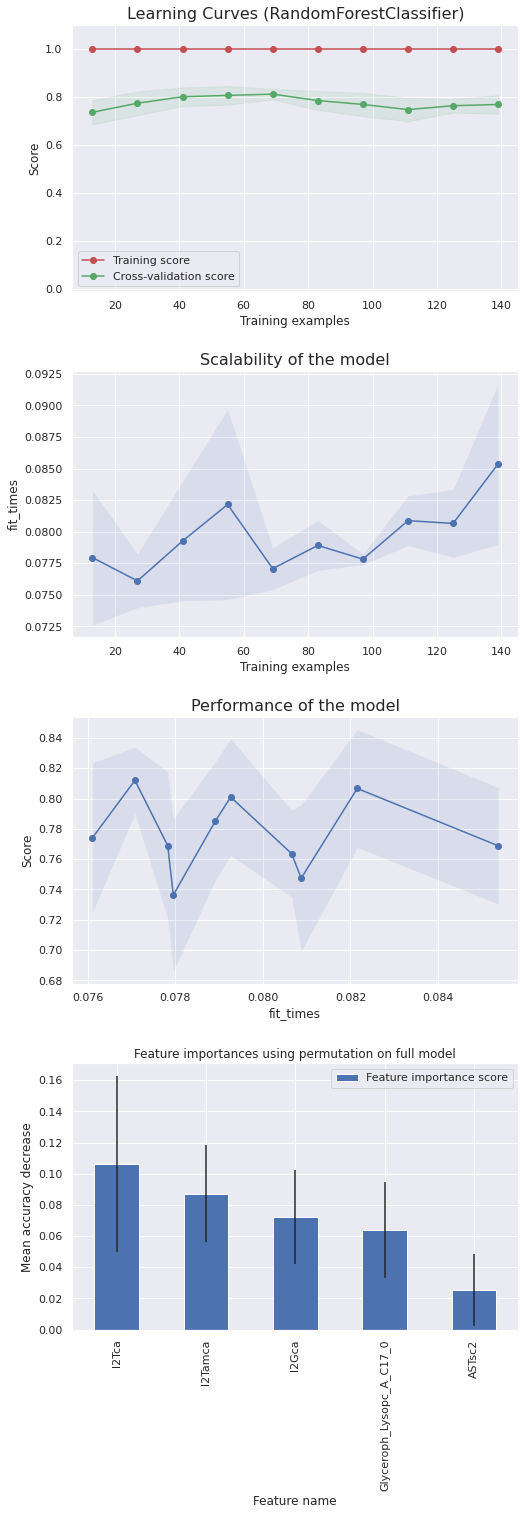




###############################################################----------------------################################################################
##############################################################| ExtraTreesClassifier |###############################################################
###############################################################----------------------################################################################

Corresponding classes to labels : {'Incident': 0, 'Non-case': 1}

Confusion matrix :


Incident  Non-case
true/pred                    
Incident         15         9
Non-case          6        17


Classification report :


precision  recall  f1-score  support
Incident           0.71    0.62      0.67    24.00
Non-case           0.65    0.74      0.69    23.00
accuracy           0.68    0.68      0.68     0.68
macro avg          0.68    0.68      0.68    47.00
weighted avg       0.68    0.68      0.68    47.00

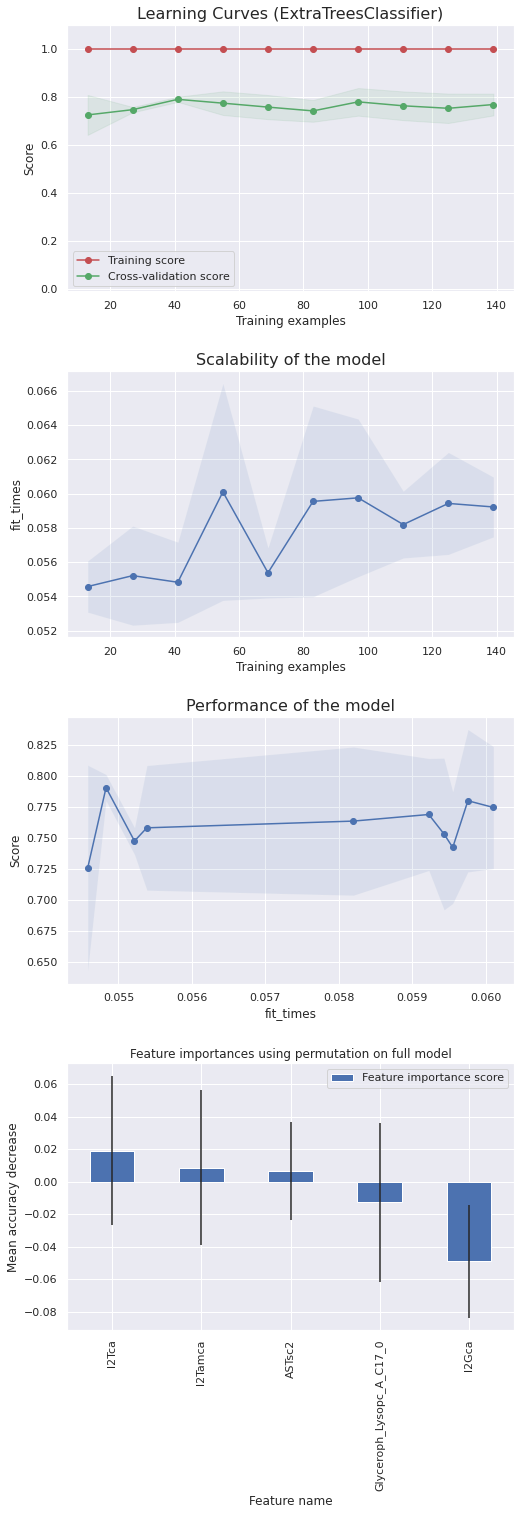




################################################################--------------------#################################################################
###############################################################| AdaBoostClassifier |################################################################
################################################################--------------------#################################################################

Corresponding classes to labels : {'Incident': 0, 'Non-case': 1}

Confusion matrix :


Incident  Non-case
true/pred                    
Incident         15         9
Non-case          9        14


Classification report :


precision  recall  f1-score  support
Incident           0.62    0.62      0.62    24.00
Non-case           0.61    0.61      0.61    23.00
accuracy           0.62    0.62      0.62     0.62
macro avg          0.62    0.62      0.62    47.00
weighted avg       0.62    0.62      0.62    47.00

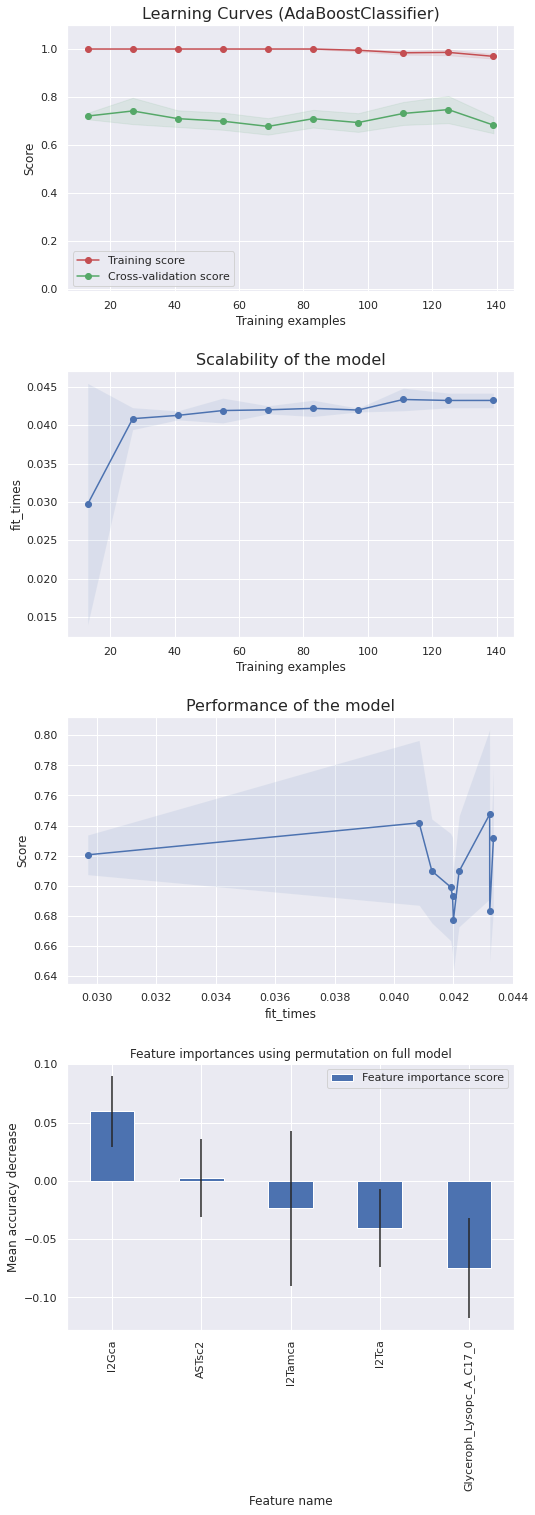




############################################################----------------------------#############################################################
###########################################################| GradientBoostingClassifier |############################################################
############################################################----------------------------#############################################################

Corresponding classes to labels : {'Incident': 0, 'Non-case': 1}

Confusion matrix :


Incident  Non-case
true/pred                    
Incident         14        10
Non-case          6        17


Classification report :


precision  recall  f1-score  support
Incident           0.70    0.58      0.64    24.00
Non-case           0.63    0.74      0.68    23.00
accuracy           0.66    0.66      0.66     0.66
macro avg          0.66    0.66      0.66    47.00
weighted avg       0.67    0.66      0.66    47.00

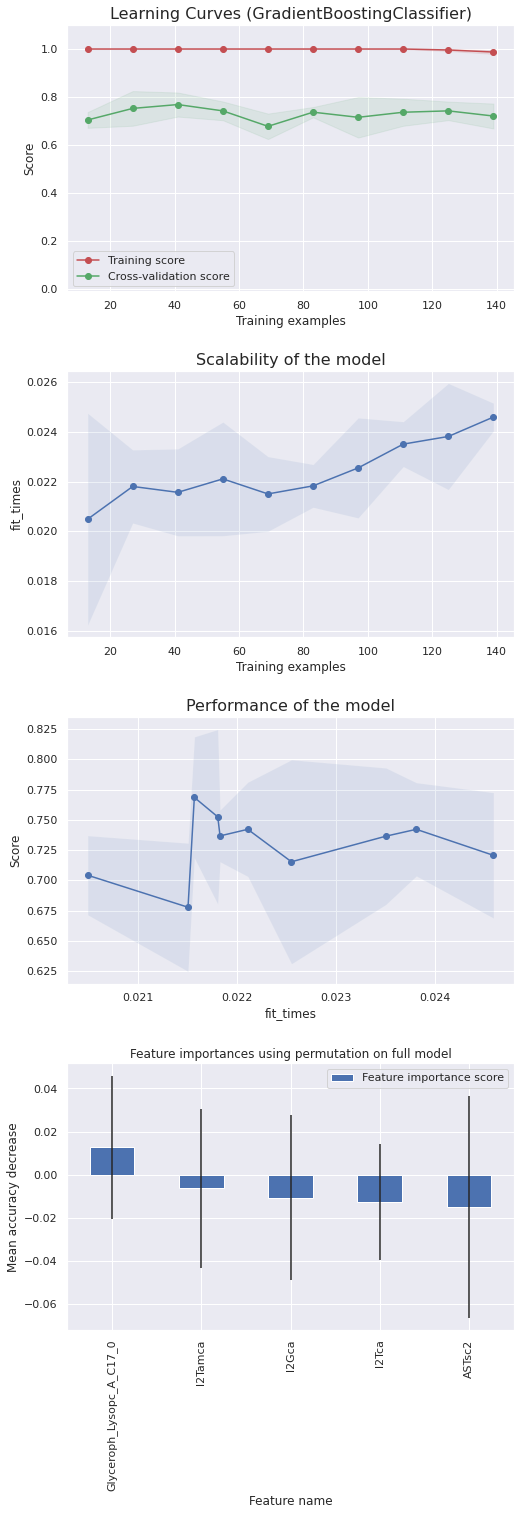




##########################################################--------------------------------###########################################################
#########################################################| HistGradientBoostingClassifier |##########################################################
##########################################################--------------------------------###########################################################

Corresponding classes to labels : {'Incident': 0, 'Non-case': 1}

Confusion matrix :


Incident  Non-case
true/pred                    
Incident         15         9
Non-case          6        17


Classification report :


precision  recall  f1-score  support
Incident           0.71    0.62      0.67    24.00
Non-case           0.65    0.74      0.69    23.00
accuracy           0.68    0.68      0.68     0.68
macro avg          0.68    0.68      0.68    47.00
weighted avg       0.68    0.68      0.68    47.00

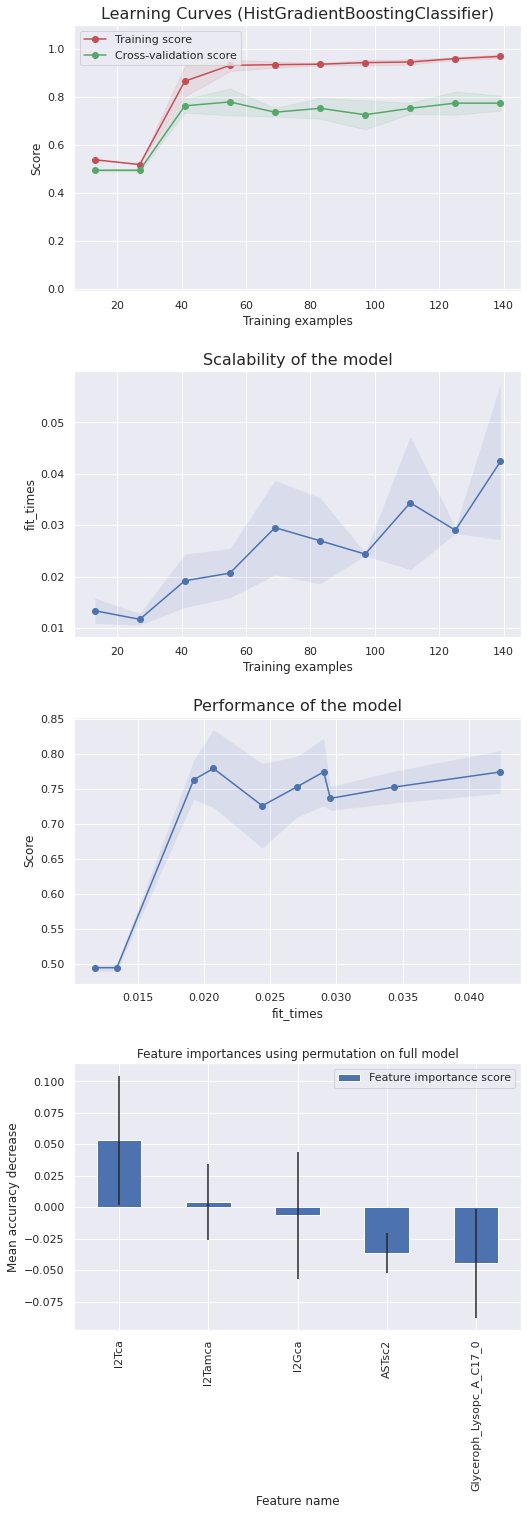




##################################################################---------------####################################################################
#################################################################| MLPClassifier |###################################################################
##################################################################---------------####################################################################

Corresponding classes to labels : {'Incident': 0, 'Non-case': 1}

Confusion matrix :


Incident  Non-case
true/pred                    
Incident         12        12
Non-case          2        21


Classification report :


precision  recall  f1-score  support
Incident           0.86    0.50      0.63    24.00
Non-case           0.64    0.91      0.75    23.00
accuracy           0.70    0.70      0.70     0.70
macro avg          0.75    0.71      0.69    47.00
weighted avg       0.75    0.70      0.69    47.00

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


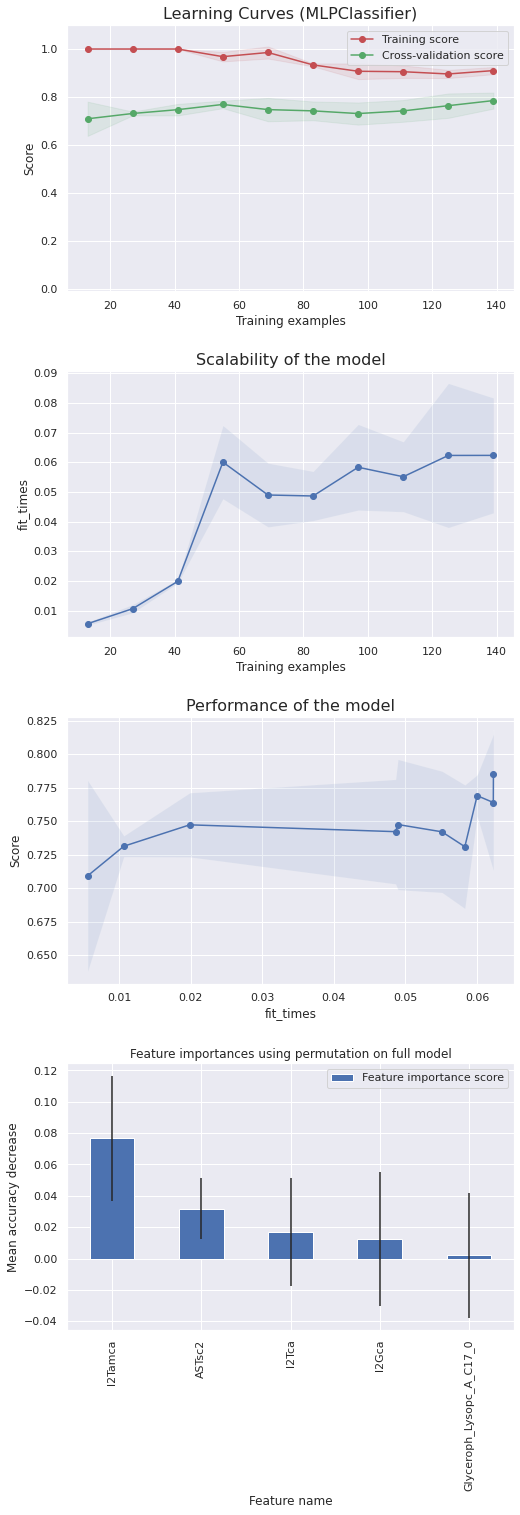




###################################################################################################################################################### 



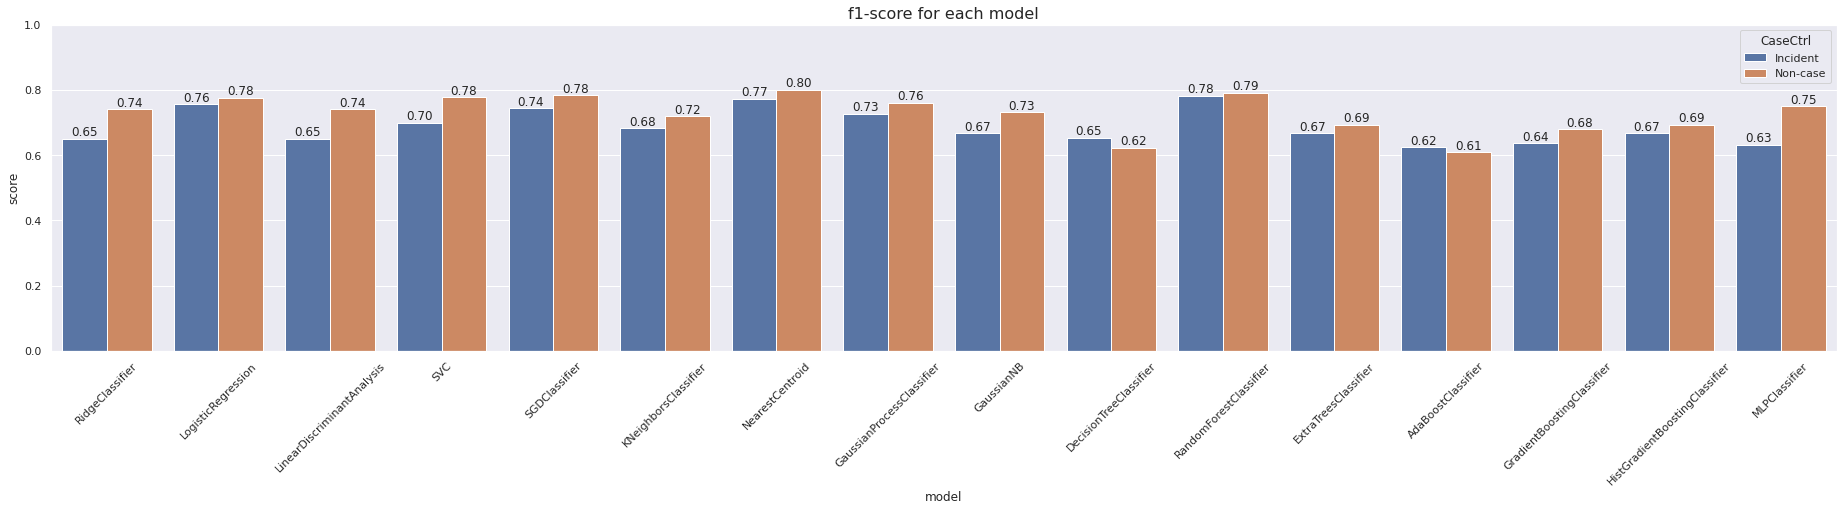


 ######################################################################################################################################################

Time to compute : 00h00m18s

 ######################################################################################################################################################






In [56]:
# Initialise models
RidgeClassifier_ = RidgeClassifier()
LogisticRegression_ = LogisticRegression()
LinearDiscriminantAnalysis_ = LinearDiscriminantAnalysis()
SVC_ = SVC(random_state=0)
SGDClassifier_ = SGDClassifier()
KNeighborsClassifier_ = KNeighborsClassifier()
NearestCentroid_ = NearestCentroid()
GaussianProcessClassifier_ = GaussianProcessClassifier(kernel=1.0 * RBF(1.0))
GaussianNB_ = GaussianNB()
DecisionTreeClassifier_ = DecisionTreeClassifier(random_state=0)
RandomForestClassifier_ = RandomForestClassifier(random_state=0)
ExtraTreesClassifier_ = ExtraTreesClassifier(random_state=0)
AdaBoostClassifier_ = AdaBoostClassifier(random_state=0)
GradientBoostingClassifier_ = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
HistGradientBoostingClassifier_ = HistGradientBoostingClassifier(max_iter=100)
MLPClassifier_ = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), max_iter=300, random_state=1)


# Create dict with all models
dict_models = {'RidgeClassifier': RidgeClassifier_,
               'LogisticRegression': LogisticRegression_,
               'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis_,
               'SVC': SVC_,
               'SGDClassifier': SGDClassifier_,
               'KNeighborsClassifier': KNeighborsClassifier_,
               'NearestCentroid': NearestCentroid_,
               'GaussianProcessClassifier': GaussianProcessClassifier_,
               'GaussianNB': GaussianNB_,
               'DecisionTreeClassifier': DecisionTreeClassifier_,
               'RandomForestClassifier': RandomForestClassifier_,
               'ExtraTreesClassifier': ExtraTreesClassifier_,
               'AdaBoostClassifier': AdaBoostClassifier_,
               'GradientBoostingClassifier': GradientBoostingClassifier_,
               'HistGradientBoostingClassifier': HistGradientBoostingClassifier_,
               'MLPClassifier': MLPClassifier_
              }


# Launch classification pipeline
df_scores, dict_df_feature_importance = pipeline_classification(X=peakTable_Agilent_imp_std_fs_nb_5, y=metadata_index['CaseCtrl'],
                                                                dict_models=dict_models, plot_each_model=True, plot_hist_score=True, score='f1-score')

### On the above barplot, we can choose a model and dig into its caracteristics, e.g. *RandomForestClassifier*

In [57]:
df_scores

RidgeClassifier  LogisticRegression  LinearDiscriminantAnalysis  \
Incident             0.65                0.76                        0.65   
Non-case             0.74                0.78                        0.74   

          SVC  SGDClassifier  KNeighborsClassifier  NearestCentroid  \
Incident 0.70           0.74                  0.68             0.77   
Non-case 0.78           0.78                  0.72             0.80   

          GaussianProcessClassifier  GaussianNB  DecisionTreeClassifier  \
Incident                       0.73        0.67                    0.65   
Non-case                       0.76        0.73                    0.62   

          RandomForestClassifier  ExtraTreesClassifier  AdaBoostClassifier  \
Incident                    0.78                  0.67                0.62   
Non-case                    0.79                  0.69                0.61   

          GradientBoostingClassifier  HistGradientBoostingClassifier  \
Incident                        0.64                            0.67   
Non-case                        0.68                            0.69   

          MLPClassifier  
Incident           0.63  
Non-case           0.75

In [58]:
dict_df_feature_importance['RandomForestClassifier']

Feature name  Feature importance score
0                     l2Tca                      0.11
3                   l2Tamca                      0.09
2                     l2Gca                      0.07
4  Glyceroph_Lysopc_A_C17_0                      0.06
1                    ASTsc2                      0.03

In [59]:
print()

### We can then dig into the dictionary file of metadata to check to which biological compounds corresponds the feature names above !

### Classification pipeline on <code>peakTable_Agilent_imp_std_fs_anova</code>

###################################################################################################################################################### 



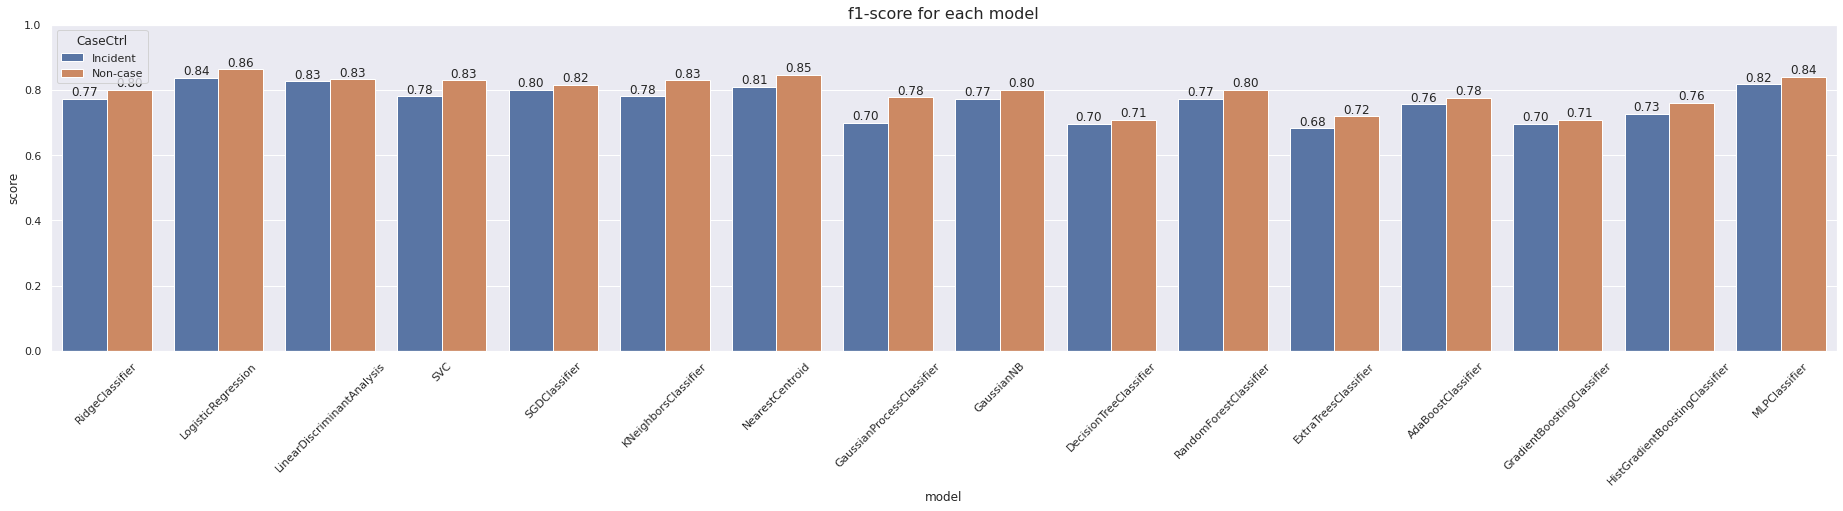


 ######################################################################################################################################################

Time to compute : 00h05m40s

 ######################################################################################################################################################






In [60]:
# Initialise models
RidgeClassifier_ = RidgeClassifier()
LogisticRegression_ = LogisticRegression()
LinearDiscriminantAnalysis_ = LinearDiscriminantAnalysis()
SVC_ = SVC(random_state=0)
SGDClassifier_ = SGDClassifier()
KNeighborsClassifier_ = KNeighborsClassifier()
NearestCentroid_ = NearestCentroid()
GaussianProcessClassifier_ = GaussianProcessClassifier(kernel=1.0 * RBF(1.0))
GaussianNB_ = GaussianNB()
DecisionTreeClassifier_ = DecisionTreeClassifier(random_state=0)
RandomForestClassifier_ = RandomForestClassifier(random_state=0)
ExtraTreesClassifier_ = ExtraTreesClassifier(random_state=0)
AdaBoostClassifier_ = AdaBoostClassifier(random_state=0)
GradientBoostingClassifier_ = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
HistGradientBoostingClassifier_ = HistGradientBoostingClassifier(max_iter=100)
MLPClassifier_ = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), max_iter=300, random_state=1)


# Create dict with all models
dict_models = {'RidgeClassifier': RidgeClassifier_,
               'LogisticRegression': LogisticRegression_,
               'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis_,
               'SVC': SVC_,
               'SGDClassifier': SGDClassifier_,
               'KNeighborsClassifier': KNeighborsClassifier_,
               'NearestCentroid': NearestCentroid_,
               'GaussianProcessClassifier': GaussianProcessClassifier_,
               'GaussianNB': GaussianNB_,
               'DecisionTreeClassifier': DecisionTreeClassifier_,
               'RandomForestClassifier': RandomForestClassifier_,
               'ExtraTreesClassifier': ExtraTreesClassifier_,
               'AdaBoostClassifier': AdaBoostClassifier_,
               'GradientBoostingClassifier': GradientBoostingClassifier_,
               'HistGradientBoostingClassifier': HistGradientBoostingClassifier_,
               'MLPClassifier': MLPClassifier_
              }


# Launch classification pipeline
df_scores, dict_df_feature_importance = pipeline_classification(X=peakTable_Agilent_imp_std_fs_anova, y=metadata_index['CaseCtrl'],
                                                                dict_models=dict_models, plot_each_model=False, plot_hist_score=True, score='f1-score')

In [61]:
print()

### Classification pipeline on <code>peakTable_Agilent_imp_std_fs_nb_1</code>

###################################################################################################################################################### 



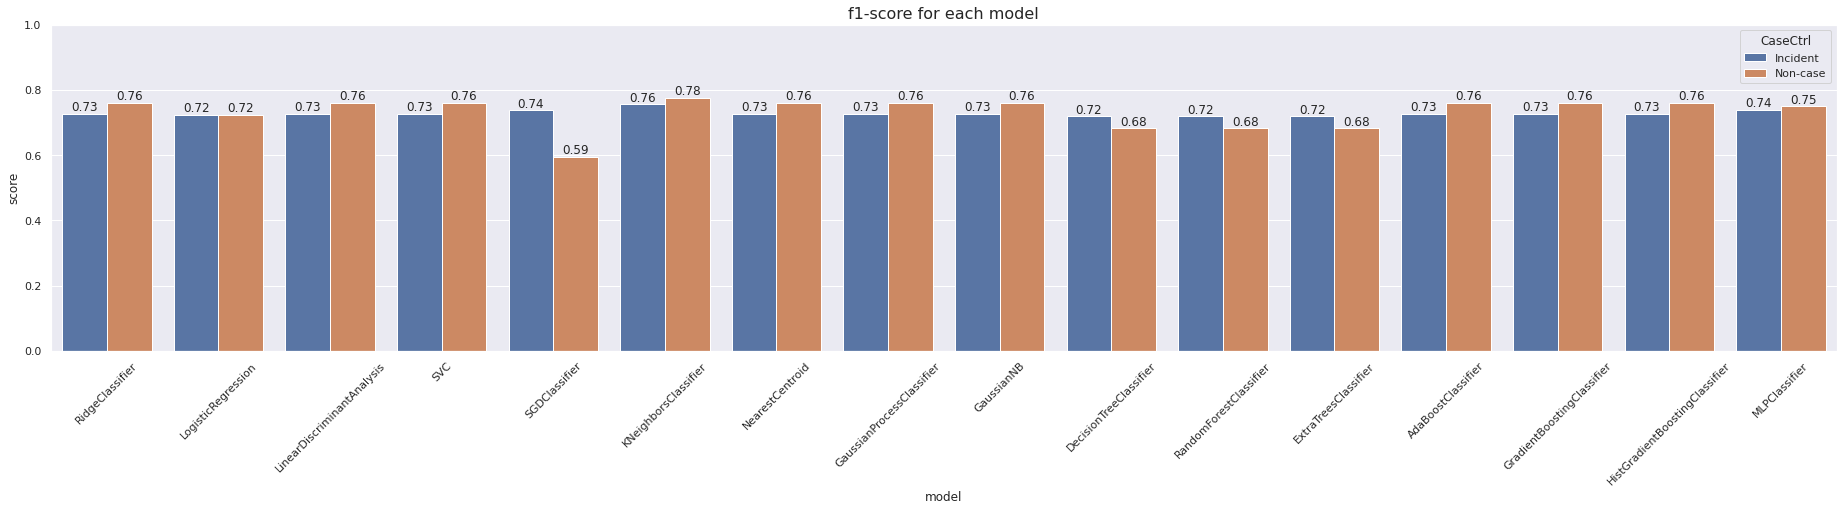


 ######################################################################################################################################################

Time to compute : 00h00m01s

 ######################################################################################################################################################






In [62]:
# Initialise models
RidgeClassifier_ = RidgeClassifier()
LogisticRegression_ = LogisticRegression()
LinearDiscriminantAnalysis_ = LinearDiscriminantAnalysis()
SVC_ = SVC(random_state=0)
SGDClassifier_ = SGDClassifier()
KNeighborsClassifier_ = KNeighborsClassifier()
NearestCentroid_ = NearestCentroid()
GaussianProcessClassifier_ = GaussianProcessClassifier(kernel=1.0 * RBF(1.0))
GaussianNB_ = GaussianNB()
DecisionTreeClassifier_ = DecisionTreeClassifier(random_state=0)
RandomForestClassifier_ = RandomForestClassifier(random_state=0)
ExtraTreesClassifier_ = ExtraTreesClassifier(random_state=0)
AdaBoostClassifier_ = AdaBoostClassifier(random_state=0)
GradientBoostingClassifier_ = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
HistGradientBoostingClassifier_ = HistGradientBoostingClassifier(max_iter=100)
MLPClassifier_ = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), max_iter=300, random_state=1)


# Create dict with all models
dict_models = {'RidgeClassifier': RidgeClassifier_,
               'LogisticRegression': LogisticRegression_,
               'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis_,
               'SVC': SVC_,
               'SGDClassifier': SGDClassifier_,
               'KNeighborsClassifier': KNeighborsClassifier_,
               'NearestCentroid': NearestCentroid_,
               'GaussianProcessClassifier': GaussianProcessClassifier_,
               'GaussianNB': GaussianNB_,
               'DecisionTreeClassifier': DecisionTreeClassifier_,
               'RandomForestClassifier': RandomForestClassifier_,
               'ExtraTreesClassifier': ExtraTreesClassifier_,
               'AdaBoostClassifier': AdaBoostClassifier_,
               'GradientBoostingClassifier': GradientBoostingClassifier_,
               'HistGradientBoostingClassifier': HistGradientBoostingClassifier_,
               'MLPClassifier': MLPClassifier_
              }


# Launch classification pipeline
df_scores, dict_df_feature_importance = pipeline_classification(X=peakTable_Agilent_imp_std_fs_nb_1, y=metadata_index['CaseCtrl'],
                                                                dict_models=dict_models, plot_each_model=False, plot_hist_score=True, score='f1-score')

In [63]:
print()

### Classification pipeline on <code>peakTable_Agilent_imp_std_fs_nb_50</code>

###################################################################################################################################################### 



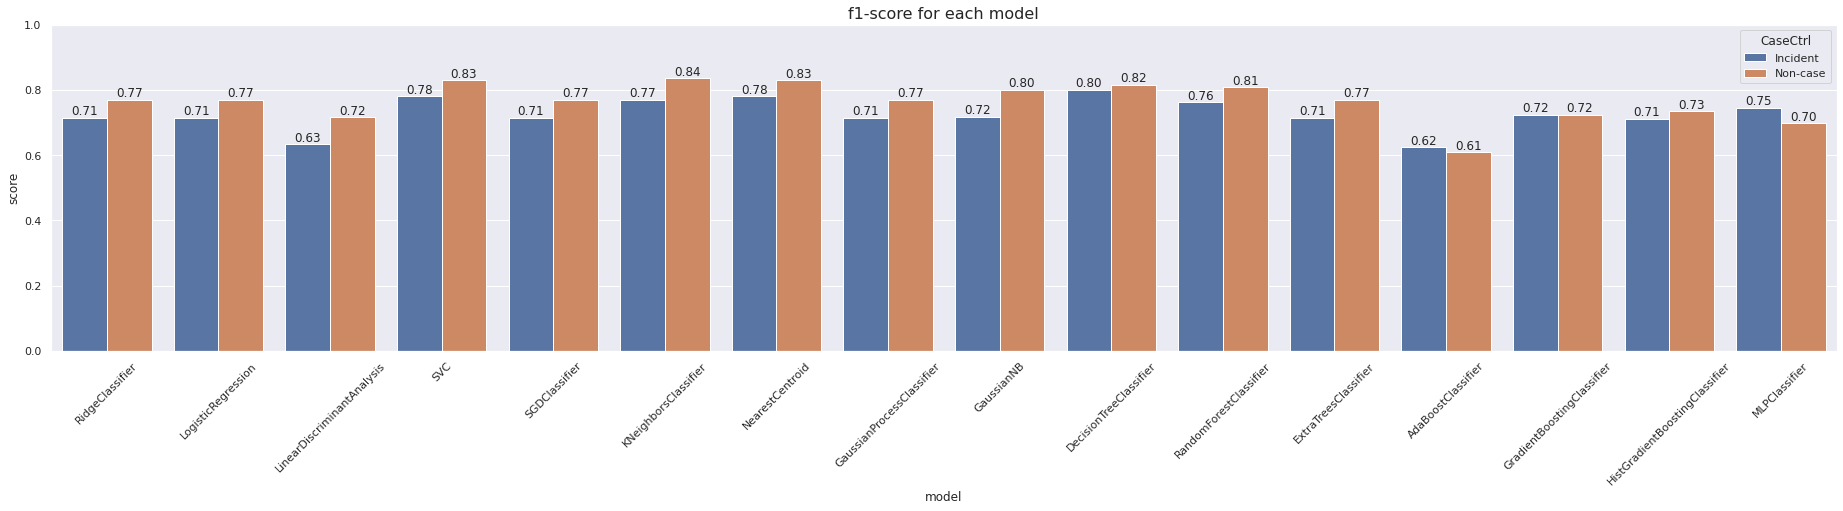


 ######################################################################################################################################################

Time to compute : 00h00m30s

 ######################################################################################################################################################






In [64]:
# Initialise models
RidgeClassifier_ = RidgeClassifier()
LogisticRegression_ = LogisticRegression()
LinearDiscriminantAnalysis_ = LinearDiscriminantAnalysis()
SVC_ = SVC(random_state=0)
SGDClassifier_ = SGDClassifier()
KNeighborsClassifier_ = KNeighborsClassifier()
NearestCentroid_ = NearestCentroid()
GaussianProcessClassifier_ = GaussianProcessClassifier(kernel=1.0 * RBF(1.0))
GaussianNB_ = GaussianNB()
DecisionTreeClassifier_ = DecisionTreeClassifier(random_state=0)
RandomForestClassifier_ = RandomForestClassifier(random_state=0)
ExtraTreesClassifier_ = ExtraTreesClassifier(random_state=0)
AdaBoostClassifier_ = AdaBoostClassifier(random_state=0)
GradientBoostingClassifier_ = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
HistGradientBoostingClassifier_ = HistGradientBoostingClassifier(max_iter=100)
MLPClassifier_ = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), max_iter=300, random_state=1)


# Create dict with all models
dict_models = {'RidgeClassifier': RidgeClassifier_,
               'LogisticRegression': LogisticRegression_,
               'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis_,
               'SVC': SVC_,
               'SGDClassifier': SGDClassifier_,
               'KNeighborsClassifier': KNeighborsClassifier_,
               'NearestCentroid': NearestCentroid_,
               'GaussianProcessClassifier': GaussianProcessClassifier_,
               'GaussianNB': GaussianNB_,
               'DecisionTreeClassifier': DecisionTreeClassifier_,
               'RandomForestClassifier': RandomForestClassifier_,
               'ExtraTreesClassifier': ExtraTreesClassifier_,
               'AdaBoostClassifier': AdaBoostClassifier_,
               'GradientBoostingClassifier': GradientBoostingClassifier_,
               'HistGradientBoostingClassifier': HistGradientBoostingClassifier_,
               'MLPClassifier': MLPClassifier_
              }


# Launch classification pipeline
df_scores, dict_df_feature_importance = pipeline_classification(X=peakTable_Agilent_imp_std_fs_nb_50, y=metadata_index['CaseCtrl'],
                                                                dict_models=dict_models, plot_each_model=False, plot_hist_score=True, score='f1-score')

In [65]:
print()

# 7 - Clustering

In [66]:
from clustering_functions import *

## a - Kmeans

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


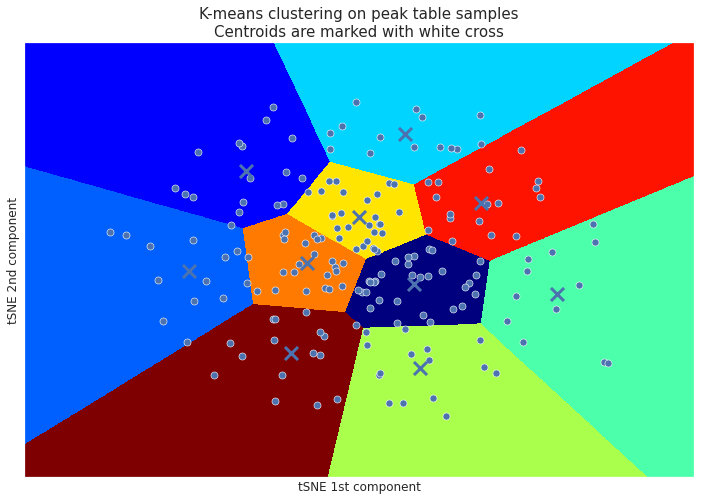

Inertia of k-means model : 69.61


In [67]:
kmeans = perform_kmeans(peakTable_Agilent_imp_std_PCA_tSNE.astype('double'), n_clusters=10, col_prefix='tSNE')

## b - Affinity propagation

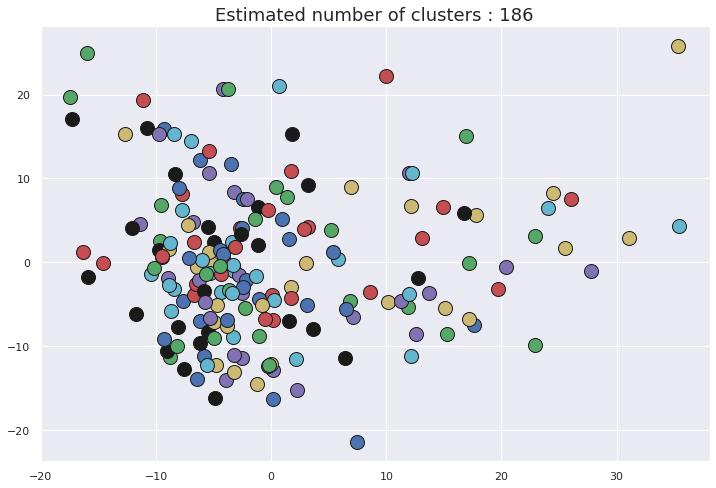

In [68]:
af = perform_affinity_propagation(peakTable_Agilent_imp_std_PCA)

In [69]:
pd.concat([peakTable_Agilent[targets], pd.DataFrame(af.labels_, columns=['af'])], axis=1)

onehotencoder__Case_HCC_Wide_No  onehotencoder__Case_HCC_Wide_Yes  \
0                               0.00                              1.00   
1                               1.00                              0.00   
2                               0.00                              1.00   
3                               1.00                              0.00   
4                               0.00                              1.00   
..                               ...                               ...   
181                             1.00                              0.00   
182                             0.00                              1.00   
183                             1.00                              0.00   
184                             0.00                              1.00   
185                             1.00                              0.00   

     onehotencoder__Case_HCC_No  onehotencoder__Case_HCC_Yes  \
0                          0.00                         1.00   
1                          1.00                         0.00   
2                          0.00                         1.00   
3                          1.00                         0.00   
4                          1.00                         0.00   
..                          ...                          ...   
181                        1.00                         0.00   
182                        0.00                         1.00   
183                        1.00                         0.00   
184                        0.00                         1.00   
185                        1.00                         0.00   

     onehotencoder__CaseCtrl_Incident  onehotencoder__CaseCtrl_Non-case  \
0                                1.00                              0.00   
1                                0.00                              1.00   
2                                1.00                              0.00   
3                                0.00                              1.00   
4                                1.00                              0.00   
..                                ...                               ...   
181                              0.00                              1.00   
182                              1.00                              0.00   
183                              0.00                              1.00   
184                              1.00                              0.00   
185                              0.00                              1.00   

     onehotencoder__Cncr_Caco_Live_Case  \
0                                  1.00   
1                                  0.00   
2                                  1.00   
3                                  0.00   
4                                  1.00   
..                                  ...   
181                                0.00   
182                                1.00   
183                                0.00   
184                                1.00   
185                                0.00   

     onehotencoder__Cncr_Caco_Live_Control   af  
0                                     0.00    0  
1                                     1.00    1  
2                                     0.00    2  
3                                     1.00    3  
4                                     0.00    4  
..                                     ...  ...  
181                                   1.00  181  
182                                   0.00  182  
183                                   1.00  183  
184                                   0.00  184  
185                                   1.00  185  

[186 rows x 9 columns]

## c - Hierarchical clustering

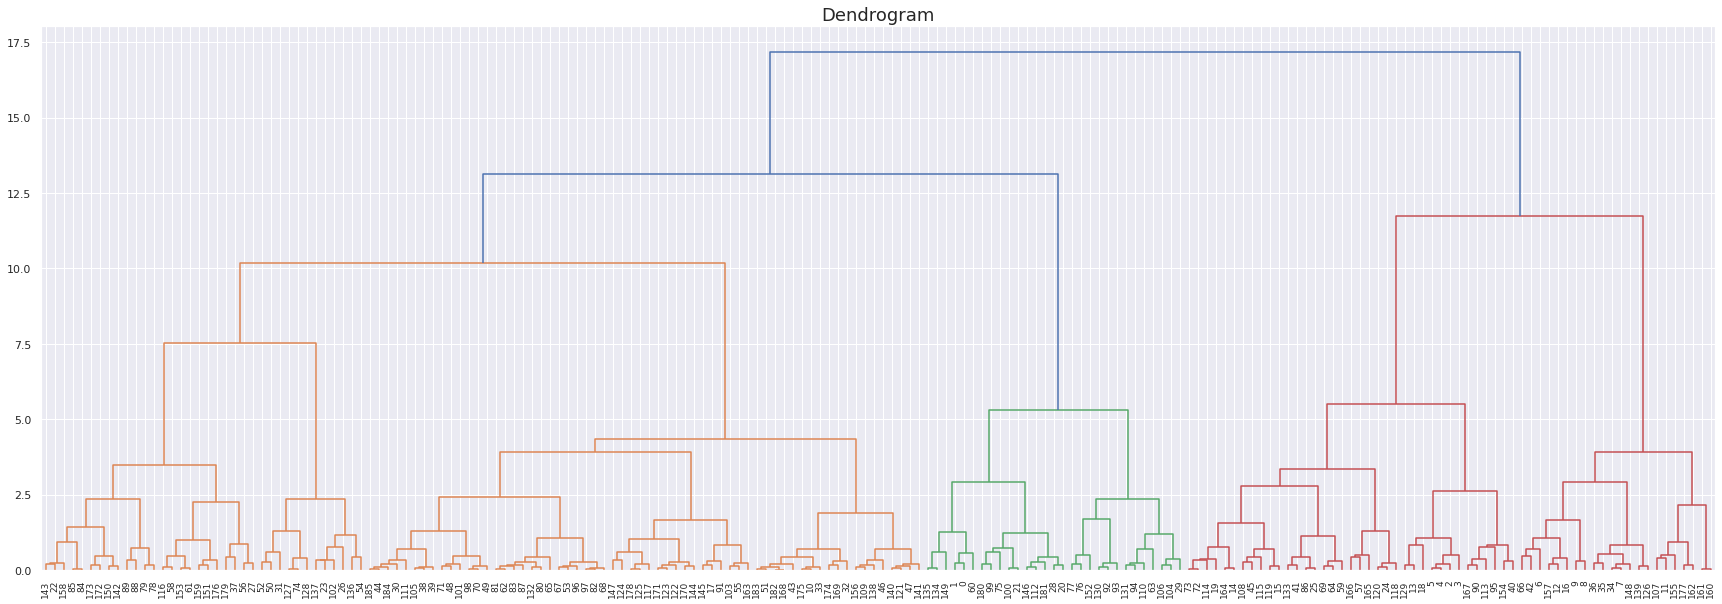

In [70]:
plot_dendrogram(peakTable_Agilent_imp_std_PCA_tSNE, hline=500)

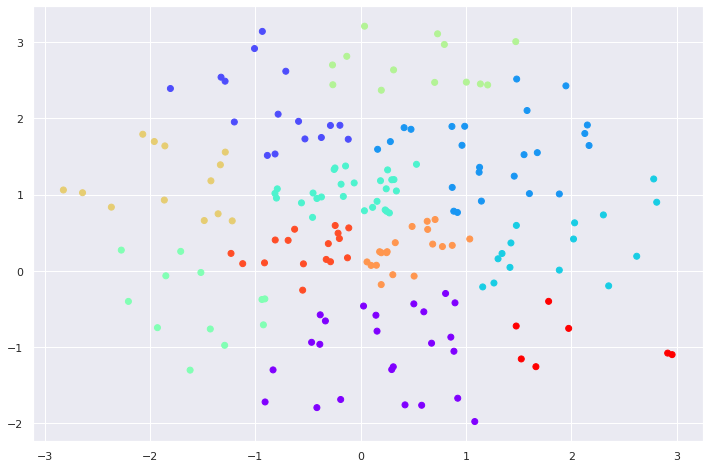

In [71]:
hc = perform_hierarchical_clustering(peakTable_Agilent_imp_std_PCA_tSNE, n_clusters=11)

In [72]:
results = pd.concat([pd.DataFrame(hc.labels_, columns=['hc_labels']), peakTable_Agilent_imp_std], axis=1)
results

hc_labels  Age_Blood  Height_Adj  Weight_Adj  Hip_Adj  Waist_Adj  \
0            1       1.87        1.47        2.34     2.46       2.12   
1            1       1.87       -0.04        0.20    -0.28      -0.28   
2            6      -0.76       -0.75       -0.93    -0.16      -1.14   
3            6      -0.82       -0.22       -1.07    -0.85      -1.87   
4            6       0.71       -1.01       -1.14    -1.33      -0.52   
..         ...        ...         ...         ...      ...        ...   
181          1       0.97       -0.77       -0.21    -0.40       0.51   
182          8       1.68       -0.58        0.02     1.55       0.15   
183          8       1.67       -0.77       -0.02     0.57       0.15   
184          4      -1.12        0.82        1.01     0.54       0.11   
185          4      -1.18        0.85        0.38    -0.40       0.03   

     Whr_Adj  Bmi_Adj  Height_C  Weight_C  ...  159.0888@0.88197106  \
0       0.60     0.96      2.16      2.74  ...                -0.14   
1      -0.15     0.34     -0.15      0.16  ...                -0.56   
2      -1.34    -0.34     -1.25     -1.20  ...                -0.91   
3      -1.88    -1.00     -0.43     -1.38  ...                -0.91   
4       0.50    -0.38     -1.65     -1.45  ...                -0.18   
..       ...      ...       ...       ...  ...                  ...   
181     1.04     0.63     -1.27     -0.34  ...                -0.84   
182    -0.91     0.71     -0.98     -0.06  ...                -0.34   
183    -0.26     0.88     -1.27     -0.11  ...                -0.43   
184    -0.26     0.35      1.16      1.13  ...                 0.35   
185     0.39    -0.29      1.21      0.38  ...                 0.07   

     472.2434@6.9100556  342.216@6.782953  429.7409@8.504203  \
0                 -0.89             -0.34               1.73   
1                 -0.23              0.75              -1.50   
2                 -0.89              0.02              -1.50   
3                  0.51             -0.18              -1.50   
4                 -0.89             -0.25               0.30   
..                  ...               ...                ...   
181               -0.54             -0.08               0.11   
182               -0.89             -0.12               0.11   
183               -0.89             -0.05              -1.50   
184               -0.12             -0.18               0.12   
185                2.65             -0.37               0.07   

     398.7578@8.768545  288.1272@6.883725  126.0287@1.5353005  \
0                 0.56               0.45                1.25   
1                 0.38               1.15               -1.48   
2                 0.40               0.01                1.14   
3                 0.39              -1.54               -1.48   
4                 0.48              -1.54                0.94   
..                 ...                ...                 ...   
181               0.50               0.80               -0.00   
182              -2.51               0.11               -0.05   
183              -2.51               0.04                0.18   
184               0.26              -0.44                0.13   
185              -0.10               0.10                1.09   

     419.2505@8.916426  103.0998@7.112515  267.142@6.969883  
0                 2.29              -1.51              0.46  
1                -2.46               1.43              0.63  
2                 0.77              -1.51             -0.06  
3                 1.16               1.40              0.63  
4                 1.52               0.42              0.00  
..                 ...                ...               ...  
181              -2.46               0.16              0.06  
182              -0.21               0.11             -0.09  
183              -2.46               1.19             -1.13  
184              -0.16               0.04             -1.13  
185              -0.79               1.11  

In [73]:
results.corr(method='pearson')

hc_labels  Age_Blood  Height_Adj  Weight_Adj  Hip_Adj  \
hc_labels                1.00       0.01       -0.05       -0.01     0.04   
Age_Blood                0.01       1.00       -0.18       -0.20    -0.08   
Height_Adj              -0.05      -0.18        1.00        0.59     0.05   
Weight_Adj              -0.01      -0.20        0.59        1.00     0.57   
Hip_Adj                  0.04      -0.08        0.05        0.57     1.00   
...                       ...        ...         ...         ...      ...   
288.1272@6.883725        0.07       0.09       -0.08        0.03     0.02   
126.0287@1.5353005       0.03      -0.02        0.12        0.24     0.12   
419.2505@8.916426        0.05       0.06       -0.02        0.01     0.06   
103.0998@7.112515        0.05       0.15       -0.08       -0.14    -0.03   
267.142@6.969883        -0.05       0.04       -0.05       -0.09     0.02   

                    Waist_Adj  Whr_Adj  Bmi_Adj  Height_C  Weight_C  ...  \
hc_labels                0.06     0.04     0.04     -0.10     -0.01  ...   
Age_Blood               -0.16    -0.16    -0.10     -0.21     -0.22  ...   
Height_Adj               0.27     0.31     0.26      0.56      0.41  ...   
Weight_Adj               0.68     0.44     0.83      0.49      0.85  ...   
Hip_Adj                  0.65     0.06     0.62      0.06      0.71  ...   
...                       ...      ...      ...       ...       ...  ...   
288.1272@6.883725       -0.03    -0.06     0.04      0.01     -0.01  ...   
126.0287@1.5353005       0.19     0.15     0.16      0.19      0.24  ...   
419.2505@8.916426        0.05     0.01     0.01     -0.02      0.03  ...   
103.0998@7.112515       -0.08    -0.08    -0.06     -0.16     -0.13  ...   
267.142@6.969883         0.02     0.02    -0.09     -0.03      0.03  ...   

                    159.0888@0.88197106  472.2434@6.9100556  342.216@6.782953  \
hc_labels                         -0.05                0.08             -0.06   
Age_Blood                          0.04               -0.10             -0.08   
Height_Adj                         0.06                0.23              0.04   
Weight_Adj                         0.03                0.24             -0.02   
Hip_Adj                           -0.08               -0.04             -0.05   
...                                 ...                 ...               ...   
288.1272@6.883725                  0.12               -0.06             -0.00   
126.0287@1.5353005                 0.08                0.22             -0.21   
419.2505@8.916426                 -0.03                0.03             -0.06   
103.0998@7.112515                 -0.04                0.03             -0.13   
267.142@6.969883                   0.02               -0.07              0.18   

                    429.7409@8.504203  398.7578@8.768545  288.1272@6.883725  \
hc_labels                       -0.05              -0.14               0.07   
Age_Blood                       -0.02              -0.05               0.09   
Height_Adj                      -0.03              -0.00              -0.08   
Weight_Adj                      -0.05              -0.07               0.03   
Hip_Adj                         -0.07              -0.06               0.02   
...                               ...                ...                ...   
288.1272@6.883725                0.09               0.10               1.00   
126.0287@1.5353005               0.10               0.09               0.08   
419.2505@8.916426                0.28               0.16              -0.02   
103.0998@7.112515                0.02               0.01               0.04   
267.142@6.969883                 0.00               0.13              -0.10   

                    126.0287@1.5353005  419.2505@8.916426  103.0998@7.112515  \
hc_labels                         0.03               0.05               0.05   
Age_Blood                        -0.02               0.06               0.15   
Height_Adj          

In [74]:
corr_sorted = results.corr(method='pearson')['hc_labels'].abs().sort_values()
corr_sorted

158.0843@2.3033335                      0.00
311.1524@6.334177                       0.00
231.1472@1.9500841                      0.00
389.766@8.766238                        0.00
153.0515@0.6549953                      0.00
                                        ... 
onehotencoder__Case_AOV_No               NaN
onehotencoder__Case_CCA_Intra_No         NaN
onehotencoder__Case_CCA_Extra_No         NaN
onehotencoder__Case_CCA_Extra_Peri_No    NaN
onehotencoder__Case_CCA_Extra_Dist_No    NaN
Name: hc_labels, Length: 2125, dtype: float64

In [75]:
corr_sorted[corr_sorted > 0.2][:-1]

Proline (HMDB0000162) / D-Proline (HMDB0003411)   0.21
141.0401@0.6327996                                0.21
Fetuin_A_LIVE_02                                  0.21
101.0479@0.638489                                 0.21
Met_Valine                                        0.22
onehotencoder__Diastol_1_93.0                     0.22
Shbg                                              0.23
Met_Glutamine                                     0.23
331.2356@4.72094                                  0.23
Tot_Protein_LIVE_03                               0.23
291.2174@6.2332644                                0.24
Met_Pufa                                          0.26
onehotencoder__Gldh_LIVE_02_0.0                   0.27
Adipo_LIVE_02                                     0.28
Name: hc_labels, dtype: float64

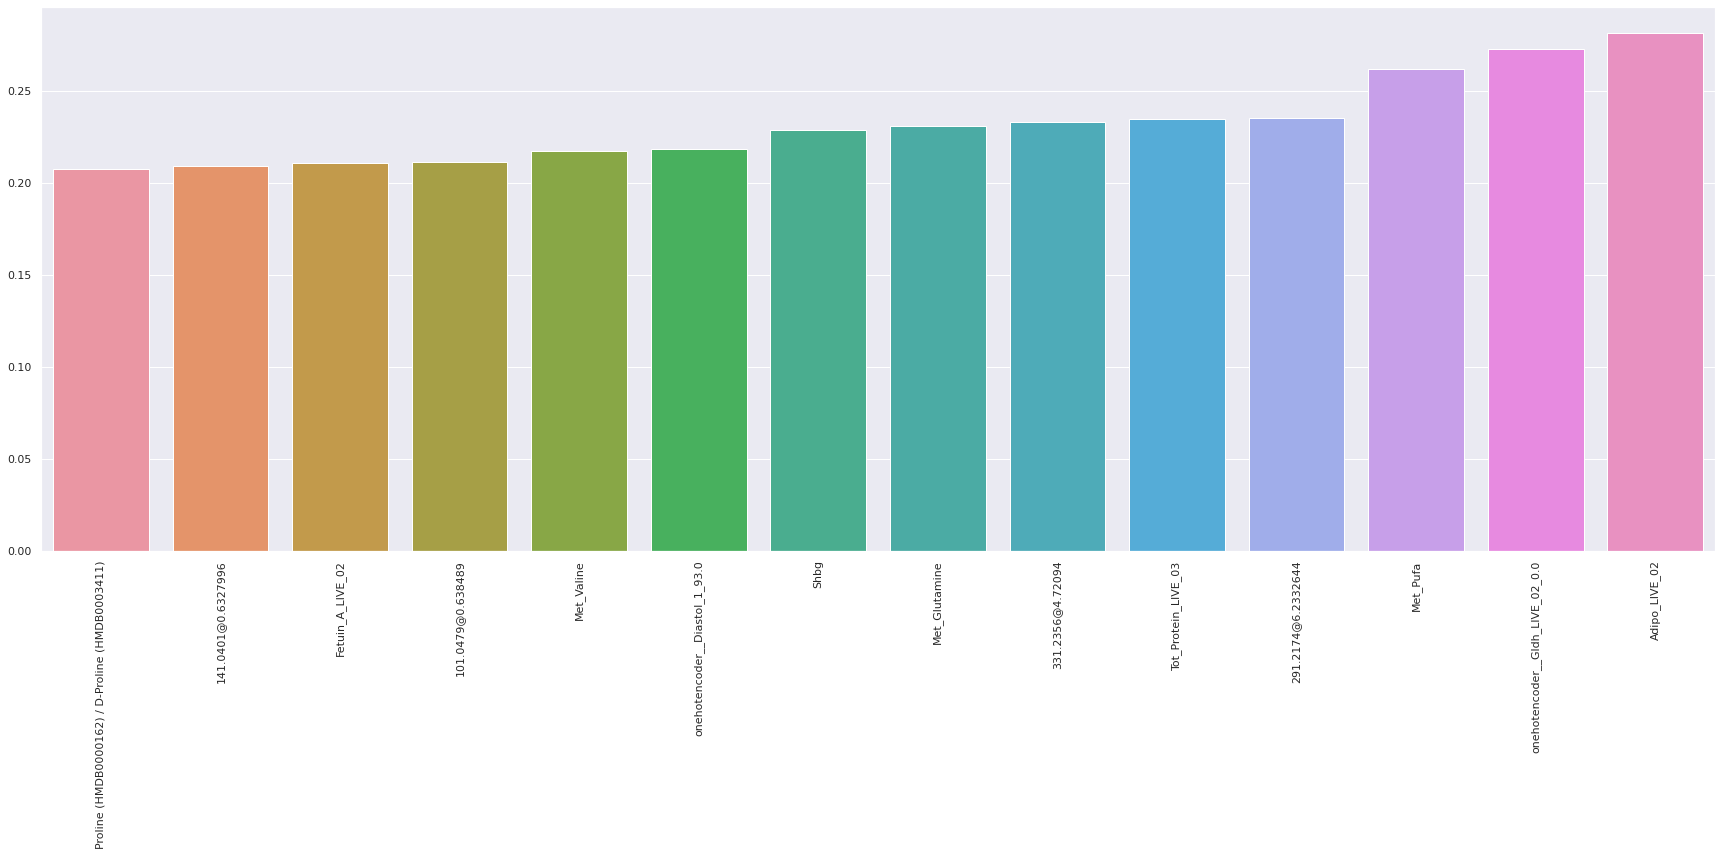

In [76]:
plt.figure(figsize=(30,10))
ax = sns.barplot(x=corr_sorted[corr_sorted > 0.2][:-1].index, y=corr_sorted[corr_sorted > 0.2][:-1].values)
plt.xticks(rotation=90);

In [77]:
pd.concat([peakTable_Agilent_imp_std, pd.DataFrame(hc.labels_, columns=['hc_labels'])], axis=1).corr()['hc_labels']

Age_Blood             0.01
Height_Adj           -0.05
Weight_Adj           -0.01
Hip_Adj               0.04
Waist_Adj             0.06
                      ... 
126.0287@1.5353005    0.03
419.2505@8.916426     0.05
103.0998@7.112515     0.05
267.142@6.969883     -0.05
hc_labels             1.00
Name: hc_labels, Length: 2125, dtype: float64